In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [2]:
# Fetching data
df = pd.read_csv('dataset.csv')

<AxesSubplot:xlabel='Time'>

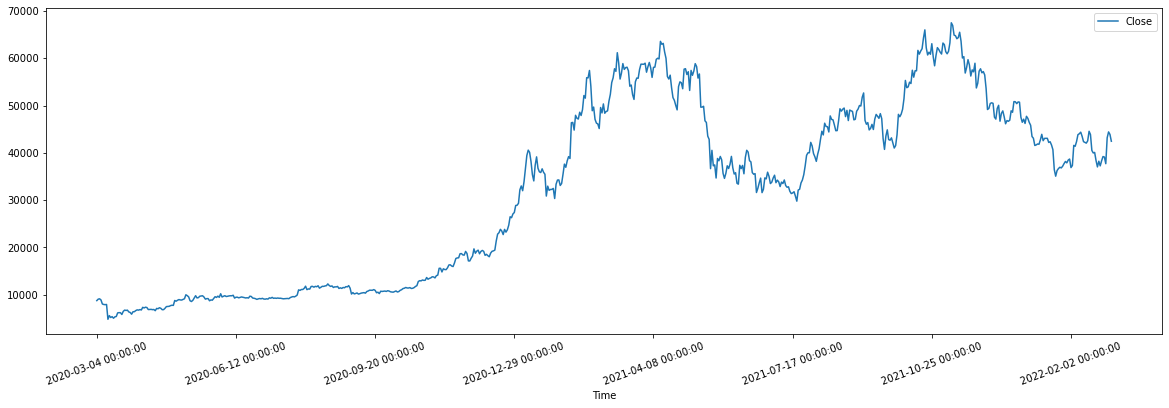

In [3]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [3]:
# Set Target Variable
output_var = pd.DataFrame(df["Close"])

# Selecting the Features
features = ["Compound", "Volume", "FundingRate", "Bitcoin_SVI", "Cryptocurrency_SVI", \
           "No. of Active Addresses", "No. of Unique Addresses", "Transactions", \
           "Compound_lag_1", "Volume_lag_1", "FundingRate_lag_1", "Bitcoin_SVI_lag_1", "Cryptocurrency_SVI_lag_1", \
           "No. of Active Addresses_lag_1", "No. of Unique Addresses_lag_1", "Transactions_lag_1", \
           "Compound_lag_2", "Volume_lag_2", "FundingRate_lag_2", "Bitcoin_SVI_lag_2", "Cryptocurrency_SVI_lag_2", \
           "No. of Active Addresses_lag_2", "No. of Unique Addresses_lag_2", "Transactions_lag_2", \
           "Compound_lag_3", "Volume_lag_3", "FundingRate_lag_3", "Bitcoin_SVI_lag_3", "Cryptocurrency_SVI_lag_3", \
           "No. of Active Addresses_lag_3", "No. of Unique Addresses_lag_3", "Transactions_lag_3", \
           "Compound_lag_4", "Volume_lag_4", "FundingRate_lag_4", "Bitcoin_SVI_lag_4", "Cryptocurrency_SVI_lag_4", \
           "No. of Active Addresses_lag_4", "No. of Unique Addresses_lag_4", "Transactions_lag_4", \
           "Compound_lag_5", "Volume_lag_5", "FundingRate_lag_5", "Bitcoin_SVI_lag_5", "Cryptocurrency_SVI_lag_5", \
           "No. of Active Addresses_lag_5", "No. of Unique Addresses_lag_5", "Transactions_lag_5"]

## Feature Scaling

In [5]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)

# # Data used to predict 4 March
# predict_feature = feature_transform[729:]

# # Drop the Last Row 
# feature_transform = feature_transform.drop([729])

feature_transform.head()

Compound    Volume  FundingRate  Bitcoin_SVI  Cryptocurrency_SVI  \
0  0.592928  0.023051     0.153846     0.041205            0.033594   
1  0.592928  0.012190     0.169231     0.034897            0.036302   
2  0.592928  0.005210     0.107692     0.044867            0.040714   
3  0.592928  0.015012     0.123077     0.064910            0.048335   
4  0.592928  0.025026     0.092308     0.066945            0.048335   

   No. of Active Addresses  No. of Unique Addresses  Transactions  \
0                 0.273629                 0.295175      0.556192   
1                 0.164620                 0.175348      0.464208   
2                 0.092122                 0.127702      0.417240   
3                 0.309585                 0.310685      0.562352   
4                 0.495286                 0.383030      0.678915   

   Compound_lag_1  Volume_lag_1  ...  No. of Unique Addresses_lag_4  \
0        0.592928      0.023051  ...                       0.295175   
1        0.592928      0.012190  ...                       0.175348   
2        0.592928      0.005210  ...                       0.127702   
3        0.592928      0.015012  ...                       0.310685   
4        0.592928      0.025026  ...                       0.383030   

   Transactions_lag_4  Compound_lag_5  Volume_lag_5  FundingRate_lag_5  \
0            0.556192        0.592928      0.023051           0.153846   
1            0.464208        0.592928      0.012190           0.169231   
2            0.417240        0.592928      0.005210           0.107692   
3            0.562352        0.592928      0.015012           0.123077   
4            0.678915        0.592928      0.025026           0.092308   

   Bitcoin_SVI_lag_5  Cryptocurrency_SVI_lag_5  No. of Active Addresses_lag_5  \
0           0.041205                  0.033594                       0.273629   
1           0.034897                  0.036302                       0.164620   
2           0.044867                  0.040714                       0.092122   
3           0.064910                  0.048335                       0.309585   
4           0.066945                  0.048335                       0.495286   

   No. of Unique Addresses_lag_5  Transactions_lag_5  
0                       0.295175            0.556192  
1                       0.175348            0.464208  
2                       0.127702            0.417240  
3                       0.310685            0.562352  
4                       0.383030            0.678915  

[5 rows x 48 columns]

In [6]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set

In [7]:
num_cv = int(cv_size*len(feature_transform))
num_test = int(test_size*len(feature_transform))
num_train = len(feature_transform) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
X_train, y_train = feature_transform[:num_train], output_var[:num_train].values.ravel()
X_cv, y_cv = feature_transform[num_train:num_train+num_cv], output_var[num_train:num_train+num_cv].values.ravel()
X_train_cv, y_train_cv = feature_transform[:num_train+num_cv], output_var[:num_train+num_cv].values.ravel()
X_test, y_test = feature_transform[num_train+num_cv:], output_var[num_train+num_cv:].values.ravel()
print("train.shape = " + str(X_train.shape))
print("cv.shape = " + str(X_cv.shape))
print("train_cv.shape = " + str(X_train_cv.shape))
print("test.shape = " + str(X_test.shape))

num_train = 420
num_cv = 140
num_test = 140
train.shape = (420, 48)
cv.shape = (140, 48)
train_cv.shape = (560, 48)
test.shape = (140, 48)


## Handling Missing Data

In [8]:
print(X_train.isna().sum())
print(X_cv.isna().sum())
print(X_train_cv.isna().sum())
print(X_test.isna().sum())

Compound                         0
Volume                           0
FundingRate                      0
Bitcoin_SVI                      0
Cryptocurrency_SVI               0
No. of Active Addresses          0
No. of Unique Addresses          1
Transactions                     0
Compound_lag_1                   0
Volume_lag_1                     0
FundingRate_lag_1                0
Bitcoin_SVI_lag_1                0
Cryptocurrency_SVI_lag_1         0
No. of Active Addresses_lag_1    0
No. of Unique Addresses_lag_1    1
Transactions_lag_1               0
Compound_lag_2                   0
Volume_lag_2                     0
FundingRate_lag_2                0
Bitcoin_SVI_lag_2                0
Cryptocurrency_SVI_lag_2         0
No. of Active Addresses_lag_2    0
No. of Unique Addresses_lag_2    1
Transactions_lag_2               0
Compound_lag_3                   0
Volume_lag_3                     0
FundingRate_lag_3                0
Bitcoin_SVI_lag_3                0
Cryptocurrency_SVI_l

In [9]:
KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train)
X_train = pd.DataFrame(KNN_miss_filling.transform(X_train))

KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train_cv)
X_train_cv = pd.DataFrame(KNN_miss_filling.transform(X_train_cv))

In [10]:
print(X_train.isna().sum())
print(X_cv.isna().sum())
print(X_train_cv.isna().sum())
print(X_test.isna().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
dtype: int64
Compound                         0
Volume                           0
FundingRate                      0
Bitcoin_SVI                      0
Cryptocurrency_SVI               0
No. of Active Addresses          0
No. of Unique Addresses          0
Transactions                     0
Compound_lag_1                   0
Volume_lag_1                     0
FundingRate_lag_1                0
Bitcoin_SVI_lag_1                0
Cryptocurrency_SVI_lag_1         0
No. of Active Addresses_lag_1    0
No. of Unique Addresses_lag_1    0
Transactions_lag_1               0
Compound_lag_2                   0
Volume_l

 ## Defining LSTM Model & MAPE Functions

In [11]:
def run(batchSize, numEpochs, X, Y, pred_set, actual_set):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)

    orig = actual_set

    rmse = sqrt(mean_squared_error(orig, predicted_Price))
    mape = get_mape(orig, predicted_Price)
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [12]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [13]:
# vary training batches
param_label = 'epochs'
param_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32

for param in param_list:
    rmse, mape = run(default_batch_size, param, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/500


2022-04-21 16:20:21.665817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 2ms/step - loss: 952143040.0000
Epoch 2/500
14/14 [==============================] - 0s 2ms/step - loss: 952116544.0000
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 952075712.0000
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 952014464.0000
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 951929920.0000
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 951821120.0000
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 951690048.0000
Epoch 8/500
14/14 [==============================] - 0s 1ms/step - loss: 951539968.0000
Epoch 9/500
14/14 [==============================] - 0s 1ms/step - loss: 951374272.0000
Epoch 10/500
14/14 [==============================] - 0s 1ms/step - loss: 951195136.0000
Epoch 11/500
14/14 [==============================] - 0s 1ms/step - loss: 951004288.0000
Epoch 12/500
14/14 [======================

14/14 [==============================] - 0s 1ms/step - loss: 797455552.0000
Epoch 185/500
14/14 [==============================] - 0s 1ms/step - loss: 796112000.0000
Epoch 186/500
14/14 [==============================] - 0s 1ms/step - loss: 794765632.0000
Epoch 187/500
14/14 [==============================] - 0s 1ms/step - loss: 793416640.0000
Epoch 188/500
14/14 [==============================] - 0s 1ms/step - loss: 792065216.0000
Epoch 189/500
14/14 [==============================] - 0s 1ms/step - loss: 790711104.0000
Epoch 190/500
14/14 [==============================] - 0s 1ms/step - loss: 789354304.0000
Epoch 191/500
14/14 [==============================] - 0s 1ms/step - loss: 787995200.0000
Epoch 192/500
14/14 [==============================] - 0s 1ms/step - loss: 786633600.0000
Epoch 193/500
14/14 [==============================] - 0s 1ms/step - loss: 785269568.0000
Epoch 194/500
14/14 [==============================] - 0s 1ms/step - loss: 783903040.0000
Epoch 195/500
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 538425024.0000
Epoch 367/500
14/14 [==============================] - 0s 1ms/step - loss: 537060352.0000
Epoch 368/500
14/14 [==============================] - 0s 1ms/step - loss: 535697632.0000
Epoch 369/500
14/14 [==============================] - 0s 1ms/step - loss: 534336736.0000
Epoch 370/500
14/14 [==============================] - 0s 1ms/step - loss: 532977888.0000
Epoch 371/500
14/14 [==============================] - 0s 1ms/step - loss: 531620928.0000
Epoch 372/500
14/14 [==============================] - 0s 1ms/step - loss: 530265952.0000
Epoch 373/500
14/14 [==============================] - 0s 1ms/step - loss: 528912960.0000
Epoch 374/500
14/14 [==============================] - 0s 1ms/step - loss: 527562016.0000
Epoch 375/500
14/14 [==============================] - 0s 1ms/step - loss: 526213088.0000
Epoch 376/500
14/14 [==============================] - 0s 1ms/step - loss: 524866112.0000
Epoch 377/500
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 942544896.0000
Epoch 46/1000
14/14 [==============================] - 0s 1ms/step - loss: 942157248.0000
Epoch 47/1000
14/14 [==============================] - 0s 1ms/step - loss: 941762880.0000
Epoch 48/1000
14/14 [==============================] - 0s 1ms/step - loss: 941361472.0000
Epoch 49/1000
14/14 [==============================] - 0s 1ms/step - loss: 940953280.0000
Epoch 50/1000
14/14 [==============================] - 0s 1ms/step - loss: 940538176.0000
Epoch 51/1000
14/14 [==============================] - 0s 1ms/step - loss: 940116480.0000
Epoch 52/1000
14/14 [==============================] - 0s 1ms/step - loss: 939687936.0000
Epoch 53/1000
14/14 [==============================] - 0s 1ms/step - loss: 939252736.0000
Epoch 54/1000
14/14 [==============================] - 0s 1ms/step - loss: 938810816.0000
Epoch 55/1000
14/14 [==============================] - 0s 1ms/step - loss: 938362304.0000
Epoch 56/1000
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 793630592.0000
Epoch 226/1000
14/14 [==============================] - 0s 1ms/step - loss: 792515520.0000
Epoch 227/1000
14/14 [==============================] - 0s 1ms/step - loss: 791398784.0000
Epoch 228/1000
14/14 [==============================] - 0s 1ms/step - loss: 790280192.0000
Epoch 229/1000
14/14 [==============================] - 0s 1ms/step - loss: 789159872.0000
Epoch 230/1000
14/14 [==============================] - 0s 1ms/step - loss: 788037952.0000
Epoch 231/1000
14/14 [==============================] - 0s 1ms/step - loss: 786914240.0000
Epoch 232/1000
14/14 [==============================] - 0s 1ms/step - loss: 785788992.0000
Epoch 233/1000
14/14 [==============================] - 0s 1ms/step - loss: 784662080.0000
Epoch 234/1000
14/14 [==============================] - 0s 1ms/step - loss: 783533504.0000
Epoch 235/1000
14/14 [==============================] - 0s 1ms/step - loss: 782403328.0000
Epoch 236/1000

14/14 [==============================] - 0s 1ms/step - loss: 580383936.0000
Epoch 406/1000
14/14 [==============================] - 0s 1ms/step - loss: 579207168.0000
Epoch 407/1000
14/14 [==============================] - 0s 1ms/step - loss: 578031360.0000
Epoch 408/1000
14/14 [==============================] - 0s 1ms/step - loss: 576856384.0000
Epoch 409/1000
14/14 [==============================] - 0s 1ms/step - loss: 575682368.0000
Epoch 410/1000
14/14 [==============================] - 0s 1ms/step - loss: 574509184.0000
Epoch 411/1000
14/14 [==============================] - 0s 1ms/step - loss: 573336896.0000
Epoch 412/1000
14/14 [==============================] - 0s 1ms/step - loss: 572165504.0000
Epoch 413/1000
14/14 [==============================] - 0s 1ms/step - loss: 570995136.0000
Epoch 414/1000
14/14 [==============================] - 0s 1ms/step - loss: 569825664.0000
Epoch 415/1000
14/14 [==============================] - 0s 1ms/step - loss: 568657152.0000
Epoch 416/1000

14/14 [==============================] - 0s 1ms/step - loss: 391675872.0000
Epoch 586/1000
14/14 [==============================] - 0s 1ms/step - loss: 390800032.0000
Epoch 587/1000
14/14 [==============================] - 0s 2ms/step - loss: 389926400.0000
Epoch 588/1000
14/14 [==============================] - 0s 2ms/step - loss: 389055104.0000
Epoch 589/1000
14/14 [==============================] - 0s 2ms/step - loss: 388186080.0000
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 387319296.0000
Epoch 591/1000
14/14 [==============================] - 0s 1ms/step - loss: 386454784.0000
Epoch 592/1000
14/14 [==============================] - 0s 1ms/step - loss: 385592672.0000
Epoch 593/1000
14/14 [==============================] - 0s 1ms/step - loss: 384732768.0000
Epoch 594/1000
14/14 [==============================] - 0s 1ms/step - loss: 383875104.0000
Epoch 595/1000
14/14 [==============================] - 0s 1ms/step - loss: 383019808.0000
Epoch 596/1000

14/14 [==============================] - 0s 1ms/step - loss: 261017680.0000
Epoch 766/1000
14/14 [==============================] - 0s 1ms/step - loss: 260135360.0000
Epoch 767/1000
14/14 [==============================] - 0s 1ms/step - loss: 259267792.0000
Epoch 768/1000
14/14 [==============================] - 0s 1ms/step - loss: 258413008.0000
Epoch 769/1000
14/14 [==============================] - 0s 1ms/step - loss: 257569552.0000
Epoch 770/1000
14/14 [==============================] - 0s 1ms/step - loss: 256736064.0000
Epoch 771/1000
14/14 [==============================] - 0s 1ms/step - loss: 255911488.0000
Epoch 772/1000
14/14 [==============================] - 0s 1ms/step - loss: 255094784.0000
Epoch 773/1000
14/14 [==============================] - 0s 1ms/step - loss: 254285120.0000
Epoch 774/1000
14/14 [==============================] - 0s 1ms/step - loss: 253481840.0000
Epoch 775/1000
14/14 [==============================] - 0s 1ms/step - loss: 252684288.0000
Epoch 776/1000

14/14 [==============================] - 0s 1ms/step - loss: 145262400.0000
Epoch 946/1000
14/14 [==============================] - 0s 1ms/step - loss: 144754672.0000
Epoch 947/1000
14/14 [==============================] - 0s 1ms/step - loss: 144248352.0000
Epoch 948/1000
14/14 [==============================] - 0s 1ms/step - loss: 143743440.0000
Epoch 949/1000
14/14 [==============================] - 0s 1ms/step - loss: 143239936.0000
Epoch 950/1000
14/14 [==============================] - 0s 1ms/step - loss: 142737872.0000
Epoch 951/1000
14/14 [==============================] - 0s 1ms/step - loss: 142237216.0000
Epoch 952/1000
14/14 [==============================] - 0s 1ms/step - loss: 141737952.0000
Epoch 953/1000
14/14 [==============================] - 0s 1ms/step - loss: 141240128.0000
Epoch 954/1000
14/14 [==============================] - 0s 1ms/step - loss: 140743728.0000
Epoch 955/1000
14/14 [==============================] - 0s 1ms/step - loss: 140248768.0000
Epoch 956/1000

14/14 [==============================] - 0s 1ms/step - loss: 873224064.0000
Epoch 124/1500
14/14 [==============================] - 0s 1ms/step - loss: 872121024.0000
Epoch 125/1500
14/14 [==============================] - 0s 1ms/step - loss: 871012864.0000
Epoch 126/1500
14/14 [==============================] - 0s 1ms/step - loss: 869899328.0000
Epoch 127/1500
14/14 [==============================] - 0s 1ms/step - loss: 868780800.0000
Epoch 128/1500
14/14 [==============================] - 0s 1ms/step - loss: 867657088.0000
Epoch 129/1500
14/14 [==============================] - 0s 1ms/step - loss: 866528384.0000
Epoch 130/1500
14/14 [==============================] - 0s 1ms/step - loss: 865394688.0000
Epoch 131/1500
14/14 [==============================] - 0s 1ms/step - loss: 864255936.0000
Epoch 132/1500
14/14 [==============================] - 0s 1ms/step - loss: 863112384.0000
Epoch 133/1500
14/14 [==============================] - 0s 1ms/step - loss: 861963904.0000
Epoch 134/1500

14/14 [==============================] - 0s 1ms/step - loss: 628033600.0000
Epoch 304/1500
14/14 [==============================] - 0s 1ms/step - loss: 626585920.0000
Epoch 305/1500
14/14 [==============================] - 0s 1ms/step - loss: 625139008.0000
Epoch 306/1500
14/14 [==============================] - 0s 1ms/step - loss: 623692672.0000
Epoch 307/1500
14/14 [==============================] - 0s 1ms/step - loss: 622247168.0000
Epoch 308/1500
14/14 [==============================] - 0s 1ms/step - loss: 620802304.0000
Epoch 309/1500
14/14 [==============================] - 0s 1ms/step - loss: 619358272.0000
Epoch 310/1500
14/14 [==============================] - 0s 1ms/step - loss: 617915008.0000
Epoch 311/1500
14/14 [==============================] - 0s 1ms/step - loss: 616472576.0000
Epoch 312/1500
14/14 [==============================] - 0s 1ms/step - loss: 615030912.0000
Epoch 313/1500
14/14 [==============================] - 0s 1ms/step - loss: 613590208.0000
Epoch 314/1500

14/14 [==============================] - 0s 1ms/step - loss: 395862240.0000
Epoch 484/1500
14/14 [==============================] - 0s 1ms/step - loss: 394809920.0000
Epoch 485/1500
14/14 [==============================] - 0s 1ms/step - loss: 393760896.0000
Epoch 486/1500
14/14 [==============================] - 0s 1ms/step - loss: 392715040.0000
Epoch 487/1500
14/14 [==============================] - 0s 1ms/step - loss: 391672480.0000
Epoch 488/1500
14/14 [==============================] - 0s 1ms/step - loss: 390633152.0000
Epoch 489/1500
14/14 [==============================] - 0s 1ms/step - loss: 389597088.0000
Epoch 490/1500
14/14 [==============================] - 0s 1ms/step - loss: 388564320.0000
Epoch 491/1500
14/14 [==============================] - 0s 1ms/step - loss: 387534848.0000
Epoch 492/1500
14/14 [==============================] - 0s 1ms/step - loss: 386508640.0000
Epoch 493/1500
14/14 [==============================] - 0s 1ms/step - loss: 385485664.0000
Epoch 494/1500

14/14 [==============================] - 0s 1ms/step - loss: 244094784.0000
Epoch 664/1500
14/14 [==============================] - 0s 1ms/step - loss: 243165904.0000
Epoch 665/1500
14/14 [==============================] - 0s 1ms/step - loss: 242246224.0000
Epoch 666/1500
14/14 [==============================] - 0s 1ms/step - loss: 241334896.0000
Epoch 667/1500
14/14 [==============================] - 0s 1ms/step - loss: 240431072.0000
Epoch 668/1500
14/14 [==============================] - 0s 1ms/step - loss: 239534048.0000
Epoch 669/1500
14/14 [==============================] - 0s 1ms/step - loss: 238643312.0000
Epoch 670/1500
14/14 [==============================] - 0s 1ms/step - loss: 237758368.0000
Epoch 671/1500
14/14 [==============================] - 0s 1ms/step - loss: 236878800.0000
Epoch 672/1500
14/14 [==============================] - 0s 1ms/step - loss: 236004192.0000
Epoch 673/1500
14/14 [==============================] - 0s 1ms/step - loss: 235134336.0000
Epoch 674/1500

14/14 [==============================] - 0s 1ms/step - loss: 121041600.0000
Epoch 844/1500
14/14 [==============================] - 0s 1ms/step - loss: 120540504.0000
Epoch 845/1500
14/14 [==============================] - 0s 1ms/step - loss: 120041344.0000
Epoch 846/1500
14/14 [==============================] - 0s 1ms/step - loss: 119544136.0000
Epoch 847/1500
14/14 [==============================] - 0s 1ms/step - loss: 119048864.0000
Epoch 848/1500
14/14 [==============================] - 0s 1ms/step - loss: 118555520.0000
Epoch 849/1500
14/14 [==============================] - 0s 1ms/step - loss: 118064120.0000
Epoch 850/1500
14/14 [==============================] - 0s 1ms/step - loss: 117574648.0000
Epoch 851/1500
14/14 [==============================] - 0s 1ms/step - loss: 117087104.0000
Epoch 852/1500
14/14 [==============================] - 0s 1ms/step - loss: 116601488.0000
Epoch 853/1500
14/14 [==============================] - 0s 1ms/step - loss: 116117824.0000
Epoch 854/1500

14/14 [==============================] - 0s 1ms/step - loss: 60115708.0000
Epoch 1024/1500
14/14 [==============================] - 0s 1ms/step - loss: 59921004.0000
Epoch 1025/1500
14/14 [==============================] - 0s 1ms/step - loss: 59727540.0000
Epoch 1026/1500
14/14 [==============================] - 0s 1ms/step - loss: 59535352.0000
Epoch 1027/1500
14/14 [==============================] - 0s 1ms/step - loss: 59344408.0000
Epoch 1028/1500
14/14 [==============================] - 0s 1ms/step - loss: 59154696.0000
Epoch 1029/1500
14/14 [==============================] - 0s 1ms/step - loss: 58966216.0000
Epoch 1030/1500
14/14 [==============================] - 0s 1ms/step - loss: 58778964.0000
Epoch 1031/1500
14/14 [==============================] - 0s 1ms/step - loss: 58592960.0000
Epoch 1032/1500
14/14 [==============================] - 0s 1ms/step - loss: 58408164.0000
Epoch 1033/1500
14/14 [==============================] - 0s 1ms/step - loss: 58224580.0000
Epoch 1034/1500

14/14 [==============================] - 0s 1ms/step - loss: 40620744.0000
Epoch 1204/1500
14/14 [==============================] - 0s 1ms/step - loss: 40573692.0000
Epoch 1205/1500
14/14 [==============================] - 0s 1ms/step - loss: 40527052.0000
Epoch 1206/1500
14/14 [==============================] - 0s 1ms/step - loss: 40480820.0000
Epoch 1207/1500
14/14 [==============================] - 0s 1ms/step - loss: 40434976.0000
Epoch 1208/1500
14/14 [==============================] - 0s 1ms/step - loss: 40389528.0000
Epoch 1209/1500
14/14 [==============================] - 0s 1ms/step - loss: 40344480.0000
Epoch 1210/1500
14/14 [==============================] - 0s 1ms/step - loss: 40299816.0000
Epoch 1211/1500
14/14 [==============================] - 0s 1ms/step - loss: 40255528.0000
Epoch 1212/1500
14/14 [==============================] - 0s 1ms/step - loss: 40211632.0000
Epoch 1213/1500
14/14 [==============================] - 0s 1ms/step - loss: 40168120.0000
Epoch 1214/1500

14/14 [==============================] - 0s 2ms/step - loss: 36030144.0000
Epoch 1384/1500
14/14 [==============================] - 0s 2ms/step - loss: 36015804.0000
Epoch 1385/1500
14/14 [==============================] - 0s 1ms/step - loss: 36001516.0000
Epoch 1386/1500
14/14 [==============================] - 0s 1ms/step - loss: 35987268.0000
Epoch 1387/1500
14/14 [==============================] - 0s 1ms/step - loss: 35973072.0000
Epoch 1388/1500
14/14 [==============================] - 0s 1ms/step - loss: 35958924.0000
Epoch 1389/1500
14/14 [==============================] - 0s 1ms/step - loss: 35944808.0000
Epoch 1390/1500
14/14 [==============================] - 0s 1ms/step - loss: 35930752.0000
Epoch 1391/1500
14/14 [==============================] - 0s 1ms/step - loss: 35916720.0000
Epoch 1392/1500
14/14 [==============================] - 0s 1ms/step - loss: 35902736.0000
Epoch 1393/1500
14/14 [==============================] - 0s 1ms/step - loss: 35888800.0000
Epoch 1394/1500

14/14 [==============================] - 0s 1ms/step - loss: 935646144.0000
Epoch 62/2000
14/14 [==============================] - 0s 1ms/step - loss: 935154688.0000
Epoch 63/2000
14/14 [==============================] - 0s 1ms/step - loss: 934656896.0000
Epoch 64/2000
14/14 [==============================] - 0s 1ms/step - loss: 934152704.0000
Epoch 65/2000
14/14 [==============================] - 0s 1ms/step - loss: 933642496.0000
Epoch 66/2000
14/14 [==============================] - 0s 1ms/step - loss: 933125760.0000
Epoch 67/2000
14/14 [==============================] - 0s 1ms/step - loss: 932602944.0000
Epoch 68/2000
14/14 [==============================] - 0s 1ms/step - loss: 932073792.0000
Epoch 69/2000
14/14 [==============================] - 0s 1ms/step - loss: 931538752.0000
Epoch 70/2000
14/14 [==============================] - 0s 1ms/step - loss: 930997504.0000
Epoch 71/2000
14/14 [==============================] - 0s 1ms/step - loss: 930450112.0000
Epoch 72/2000
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 776008192.0000
Epoch 242/2000
14/14 [==============================] - 0s 1ms/step - loss: 774868224.0000
Epoch 243/2000
14/14 [==============================] - 0s 2ms/step - loss: 773726976.0000
Epoch 244/2000
14/14 [==============================] - 0s 1ms/step - loss: 772584192.0000
Epoch 245/2000
14/14 [==============================] - 0s 1ms/step - loss: 771440064.0000
Epoch 246/2000
14/14 [==============================] - 0s 1ms/step - loss: 770294400.0000
Epoch 247/2000
14/14 [==============================] - 0s 1ms/step - loss: 769147328.0000
Epoch 248/2000
14/14 [==============================] - 0s 1ms/step - loss: 767999040.0000
Epoch 249/2000
14/14 [==============================] - 0s 1ms/step - loss: 766849216.0000
Epoch 250/2000
14/14 [==============================] - 0s 1ms/step - loss: 765698112.0000
Epoch 251/2000
14/14 [==============================] - 0s 1ms/step - loss: 764545728.0000
Epoch 252/2000

14/14 [==============================] - 0s 1ms/step - loss: 562163648.0000
Epoch 422/2000
14/14 [==============================] - 0s 1ms/step - loss: 561001920.0000
Epoch 423/2000
14/14 [==============================] - 0s 1ms/step - loss: 559841280.0000
Epoch 424/2000
14/14 [==============================] - 0s 1ms/step - loss: 558681664.0000
Epoch 425/2000
14/14 [==============================] - 0s 1ms/step - loss: 557523008.0000
Epoch 426/2000
14/14 [==============================] - 0s 1ms/step - loss: 556365504.0000
Epoch 427/2000
14/14 [==============================] - 0s 1ms/step - loss: 555209024.0000
Epoch 428/2000
14/14 [==============================] - 0s 1ms/step - loss: 554053696.0000
Epoch 429/2000
14/14 [==============================] - 0s 1ms/step - loss: 552899392.0000
Epoch 430/2000
14/14 [==============================] - 0s 1ms/step - loss: 551746240.0000
Epoch 431/2000
14/14 [==============================] - 0s 1ms/step - loss: 550594176.0000
Epoch 432/2000

14/14 [==============================] - 0s 1ms/step - loss: 378325472.0000
Epoch 602/2000
14/14 [==============================] - 0s 1ms/step - loss: 377485376.0000
Epoch 603/2000
14/14 [==============================] - 0s 1ms/step - loss: 376647616.0000
Epoch 604/2000
14/14 [==============================] - 0s 1ms/step - loss: 375812096.0000
Epoch 605/2000
14/14 [==============================] - 0s 1ms/step - loss: 374978976.0000
Epoch 606/2000
14/14 [==============================] - 0s 1ms/step - loss: 374148160.0000
Epoch 607/2000
14/14 [==============================] - 0s 1ms/step - loss: 373319648.0000
Epoch 608/2000
14/14 [==============================] - 0s 1ms/step - loss: 372493504.0000
Epoch 609/2000
14/14 [==============================] - 0s 1ms/step - loss: 371669664.0000
Epoch 610/2000
14/14 [==============================] - 0s 1ms/step - loss: 370848160.0000
Epoch 611/2000
14/14 [==============================] - 0s 1ms/step - loss: 370029088.0000
Epoch 612/2000

14/14 [==============================] - 0s 1ms/step - loss: 248908032.0000
Epoch 782/2000
14/14 [==============================] - 0s 1ms/step - loss: 248127744.0000
Epoch 783/2000
14/14 [==============================] - 0s 1ms/step - loss: 247352304.0000
Epoch 784/2000
14/14 [==============================] - 0s 1ms/step - loss: 246581344.0000
Epoch 785/2000
14/14 [==============================] - 0s 1ms/step - loss: 245814560.0000
Epoch 786/2000
14/14 [==============================] - 0s 1ms/step - loss: 245051712.0000
Epoch 787/2000
14/14 [==============================] - 0s 1ms/step - loss: 244292592.0000
Epoch 788/2000
14/14 [==============================] - 0s 1ms/step - loss: 243537008.0000
Epoch 789/2000
14/14 [==============================] - 0s 1ms/step - loss: 242784720.0000
Epoch 790/2000
14/14 [==============================] - 0s 1ms/step - loss: 242035600.0000
Epoch 791/2000
14/14 [==============================] - 0s 1ms/step - loss: 241289504.0000
Epoch 792/2000

14/14 [==============================] - 0s 1ms/step - loss: 138170080.0000
Epoch 962/2000
14/14 [==============================] - 0s 1ms/step - loss: 137683856.0000
Epoch 963/2000
14/14 [==============================] - 0s 1ms/step - loss: 137199024.0000
Epoch 964/2000
14/14 [==============================] - 0s 1ms/step - loss: 136715584.0000
Epoch 965/2000
14/14 [==============================] - 0s 1ms/step - loss: 136233520.0000
Epoch 966/2000
14/14 [==============================] - 0s 1ms/step - loss: 135752864.0000
Epoch 967/2000
14/14 [==============================] - 0s 1ms/step - loss: 135273632.0000
Epoch 968/2000
14/14 [==============================] - 0s 1ms/step - loss: 134795744.0000
Epoch 969/2000
14/14 [==============================] - 0s 1ms/step - loss: 134319312.0000
Epoch 970/2000
14/14 [==============================] - 0s 1ms/step - loss: 133844232.0000
Epoch 971/2000
14/14 [==============================] - 0s 1ms/step - loss: 133370568.0000
Epoch 972/2000

14/14 [==============================] - 0s 1ms/step - loss: 73331864.0000
Epoch 1141/2000
14/14 [==============================] - 0s 1ms/step - loss: 73090160.0000
Epoch 1142/2000
14/14 [==============================] - 0s 1ms/step - loss: 72849680.0000
Epoch 1143/2000
14/14 [==============================] - 0s 1ms/step - loss: 72610392.0000
Epoch 1144/2000
14/14 [==============================] - 0s 1ms/step - loss: 72372344.0000
Epoch 1145/2000
14/14 [==============================] - 0s 1ms/step - loss: 72135488.0000
Epoch 1146/2000
14/14 [==============================] - 0s 1ms/step - loss: 71899864.0000
Epoch 1147/2000
14/14 [==============================] - 0s 1ms/step - loss: 71665448.0000
Epoch 1148/2000
14/14 [==============================] - 0s 1ms/step - loss: 71432200.0000
Epoch 1149/2000
14/14 [==============================] - 0s 1ms/step - loss: 71200176.0000
Epoch 1150/2000
14/14 [==============================] - 0s 1ms/step - loss: 70969352.0000
Epoch 1151/2000

14/14 [==============================] - 0s 1ms/step - loss: 45934016.0000
Epoch 1321/2000
14/14 [==============================] - 0s 1ms/step - loss: 45851896.0000
Epoch 1322/2000
14/14 [==============================] - 0s 1ms/step - loss: 45770336.0000
Epoch 1323/2000
14/14 [==============================] - 0s 1ms/step - loss: 45689344.0000
Epoch 1324/2000
14/14 [==============================] - 0s 1ms/step - loss: 45608916.0000
Epoch 1325/2000
14/14 [==============================] - 0s 1ms/step - loss: 45529048.0000
Epoch 1326/2000
14/14 [==============================] - 0s 1ms/step - loss: 45449736.0000
Epoch 1327/2000
14/14 [==============================] - 0s 1ms/step - loss: 45370976.0000
Epoch 1328/2000
14/14 [==============================] - 0s 1ms/step - loss: 45292784.0000
Epoch 1329/2000
14/14 [==============================] - 0s 1ms/step - loss: 45215120.0000
Epoch 1330/2000
14/14 [==============================] - 0s 1ms/step - loss: 45137992.0000
Epoch 1331/2000

14/14 [==============================] - 0s 1ms/step - loss: 37605280.0000
Epoch 1501/2000
14/14 [==============================] - 0s 1ms/step - loss: 37582228.0000
Epoch 1502/2000
14/14 [==============================] - 0s 1ms/step - loss: 37559312.0000
Epoch 1503/2000
14/14 [==============================] - 0s 1ms/step - loss: 37536536.0000
Epoch 1504/2000
14/14 [==============================] - 0s 1ms/step - loss: 37513896.0000
Epoch 1505/2000
14/14 [==============================] - 0s 1ms/step - loss: 37491392.0000
Epoch 1506/2000
14/14 [==============================] - 0s 1ms/step - loss: 37469012.0000
Epoch 1507/2000
14/14 [==============================] - 0s 1ms/step - loss: 37446772.0000
Epoch 1508/2000
14/14 [==============================] - 0s 1ms/step - loss: 37424656.0000
Epoch 1509/2000
14/14 [==============================] - 0s 1ms/step - loss: 37402676.0000
Epoch 1510/2000
14/14 [==============================] - 0s 1ms/step - loss: 37380812.0000
Epoch 1511/2000

14/14 [==============================] - 0s 1ms/step - loss: 34631604.0000
Epoch 1681/2000
14/14 [==============================] - 0s 1ms/step - loss: 34618560.0000
Epoch 1682/2000
14/14 [==============================] - 0s 1ms/step - loss: 34605532.0000
Epoch 1683/2000
14/14 [==============================] - 0s 1ms/step - loss: 34592544.0000
Epoch 1684/2000
14/14 [==============================] - 0s 1ms/step - loss: 34579580.0000
Epoch 1685/2000
14/14 [==============================] - 0s 1ms/step - loss: 34566636.0000
Epoch 1686/2000
14/14 [==============================] - 0s 1ms/step - loss: 34553740.0000
Epoch 1687/2000
14/14 [==============================] - 0s 1ms/step - loss: 34540856.0000
Epoch 1688/2000
14/14 [==============================] - 0s 1ms/step - loss: 34528000.0000
Epoch 1689/2000
14/14 [==============================] - 0s 1ms/step - loss: 34515176.0000
Epoch 1690/2000
14/14 [==============================] - 0s 1ms/step - loss: 34502380.0000
Epoch 1691/2000

14/14 [==============================] - 0s 1ms/step - loss: 32653110.0000
Epoch 1861/2000
14/14 [==============================] - 0s 1ms/step - loss: 32644088.0000
Epoch 1862/2000
14/14 [==============================] - 0s 1ms/step - loss: 32635096.0000
Epoch 1863/2000
14/14 [==============================] - 0s 1ms/step - loss: 32626110.0000
Epoch 1864/2000
14/14 [==============================] - 0s 1ms/step - loss: 32617146.0000
Epoch 1865/2000
14/14 [==============================] - 0s 1ms/step - loss: 32608196.0000
Epoch 1866/2000
14/14 [==============================] - 0s 1ms/step - loss: 32599262.0000
Epoch 1867/2000
14/14 [==============================] - 0s 1ms/step - loss: 32590334.0000
Epoch 1868/2000
14/14 [==============================] - 0s 1ms/step - loss: 32581436.0000
Epoch 1869/2000
14/14 [==============================] - 0s 1ms/step - loss: 32572558.0000
Epoch 1870/2000
14/14 [==============================] - 0s 1ms/step - loss: 32563688.0000
Epoch 1871/2000

14/14 [==============================] - 0s 1ms/step - loss: 946183808.0000
Epoch 39/2500
14/14 [==============================] - 0s 1ms/step - loss: 945899136.0000
Epoch 40/2500
14/14 [==============================] - 0s 1ms/step - loss: 945608320.0000
Epoch 41/2500
14/14 [==============================] - 0s 1ms/step - loss: 945311680.0000
Epoch 42/2500
14/14 [==============================] - 0s 1ms/step - loss: 945008768.0000
Epoch 43/2500
14/14 [==============================] - 0s 1ms/step - loss: 944700032.0000
Epoch 44/2500
14/14 [==============================] - 0s 1ms/step - loss: 944385280.0000
Epoch 45/2500
14/14 [==============================] - 0s 1ms/step - loss: 944064640.0000
Epoch 46/2500
14/14 [==============================] - 0s 1ms/step - loss: 943737984.0000
Epoch 47/2500
14/14 [==============================] - 0s 1ms/step - loss: 943405440.0000
Epoch 48/2500
14/14 [==============================] - 0s 1ms/step - loss: 943067072.0000
Epoch 49/2500
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 822990656.0000
Epoch 219/2500
14/14 [==============================] - 0s 1ms/step - loss: 822030656.0000
Epoch 220/2500
14/14 [==============================] - 0s 1ms/step - loss: 821068864.0000
Epoch 221/2500
14/14 [==============================] - 0s 1ms/step - loss: 820105152.0000
Epoch 222/2500
14/14 [==============================] - 0s 1ms/step - loss: 819139584.0000
Epoch 223/2500
14/14 [==============================] - 0s 1ms/step - loss: 818172224.0000
Epoch 224/2500
14/14 [==============================] - 0s 1ms/step - loss: 817203072.0000
Epoch 225/2500
14/14 [==============================] - 0s 1ms/step - loss: 816232000.0000
Epoch 226/2500
14/14 [==============================] - 0s 1ms/step - loss: 815259264.0000
Epoch 227/2500
14/14 [==============================] - 0s 1ms/step - loss: 814284672.0000
Epoch 228/2500
14/14 [==============================] - 0s 1ms/step - loss: 813308224.0000
Epoch 229/2500

14/14 [==============================] - 0s 1ms/step - loss: 632536768.0000
Epoch 399/2500
14/14 [==============================] - 0s 1ms/step - loss: 631442944.0000
Epoch 400/2500
14/14 [==============================] - 0s 1ms/step - loss: 630349376.0000
Epoch 401/2500
14/14 [==============================] - 0s 1ms/step - loss: 629256000.0000
Epoch 402/2500
14/14 [==============================] - 0s 1ms/step - loss: 628162880.0000
Epoch 403/2500
14/14 [==============================] - 0s 1ms/step - loss: 627070144.0000
Epoch 404/2500
14/14 [==============================] - 0s 1ms/step - loss: 625977664.0000
Epoch 405/2500
14/14 [==============================] - 0s 1ms/step - loss: 624885440.0000
Epoch 406/2500
14/14 [==============================] - 0s 1ms/step - loss: 623793536.0000
Epoch 407/2500
14/14 [==============================] - 0s 1ms/step - loss: 622701824.0000
Epoch 408/2500
14/14 [==============================] - 0s 1ms/step - loss: 621610496.0000
Epoch 409/2500

14/14 [==============================] - 0s 1ms/step - loss: 447788128.0000
Epoch 579/2500
14/14 [==============================] - 0s 1ms/step - loss: 446871456.0000
Epoch 580/2500
14/14 [==============================] - 0s 1ms/step - loss: 445956384.0000
Epoch 581/2500
14/14 [==============================] - 0s 1ms/step - loss: 445042816.0000
Epoch 582/2500
14/14 [==============================] - 0s 1ms/step - loss: 444130912.0000
Epoch 583/2500
14/14 [==============================] - 0s 1ms/step - loss: 443220672.0000
Epoch 584/2500
14/14 [==============================] - 0s 1ms/step - loss: 442312128.0000
Epoch 585/2500
14/14 [==============================] - 0s 1ms/step - loss: 441405056.0000
Epoch 586/2500
14/14 [==============================] - 0s 1ms/step - loss: 440499680.0000
Epoch 587/2500
14/14 [==============================] - 0s 1ms/step - loss: 439595968.0000
Epoch 588/2500
14/14 [==============================] - 0s 1ms/step - loss: 438693920.0000
Epoch 589/2500

14/14 [==============================] - 0s 1ms/step - loss: 312305824.0000
Epoch 759/2500
14/14 [==============================] - 0s 1ms/step - loss: 311731008.0000
Epoch 760/2500
14/14 [==============================] - 0s 1ms/step - loss: 311158208.0000
Epoch 761/2500
14/14 [==============================] - 0s 1ms/step - loss: 310587424.0000
Epoch 762/2500
14/14 [==============================] - 0s 1ms/step - loss: 310018592.0000
Epoch 763/2500
14/14 [==============================] - 0s 1ms/step - loss: 309451776.0000
Epoch 764/2500
14/14 [==============================] - 0s 1ms/step - loss: 308886912.0000
Epoch 765/2500
14/14 [==============================] - 0s 1ms/step - loss: 308324064.0000
Epoch 766/2500
14/14 [==============================] - 0s 1ms/step - loss: 307763232.0000
Epoch 767/2500
14/14 [==============================] - 0s 1ms/step - loss: 307204416.0000
Epoch 768/2500
14/14 [==============================] - 0s 1ms/step - loss: 306647584.0000
Epoch 769/2500

14/14 [==============================] - 0s 1ms/step - loss: 194783216.0000
Epoch 939/2500
14/14 [==============================] - 0s 1ms/step - loss: 194205136.0000
Epoch 940/2500
14/14 [==============================] - 0s 1ms/step - loss: 193628240.0000
Epoch 941/2500
14/14 [==============================] - 0s 1ms/step - loss: 193052512.0000
Epoch 942/2500
14/14 [==============================] - 0s 1ms/step - loss: 192477968.0000
Epoch 943/2500
14/14 [==============================] - 0s 1ms/step - loss: 191904544.0000
Epoch 944/2500
14/14 [==============================] - 0s 1ms/step - loss: 191332320.0000
Epoch 945/2500
14/14 [==============================] - 0s 1ms/step - loss: 190761216.0000
Epoch 946/2500
14/14 [==============================] - 0s 1ms/step - loss: 190191328.0000
Epoch 947/2500
14/14 [==============================] - 0s 1ms/step - loss: 189622592.0000
Epoch 948/2500
14/14 [==============================] - 0s 1ms/step - loss: 189054992.0000
Epoch 949/2500

14/14 [==============================] - 0s 1ms/step - loss: 110239880.0000
Epoch 1117/2500
14/14 [==============================] - 0s 1ms/step - loss: 109870648.0000
Epoch 1118/2500
14/14 [==============================] - 0s 1ms/step - loss: 109502592.0000
Epoch 1119/2500
14/14 [==============================] - 0s 1ms/step - loss: 109135736.0000
Epoch 1120/2500
14/14 [==============================] - 0s 1ms/step - loss: 108770096.0000
Epoch 1121/2500
14/14 [==============================] - 0s 1ms/step - loss: 108405656.0000
Epoch 1122/2500
14/14 [==============================] - 0s 1ms/step - loss: 108042384.0000
Epoch 1123/2500
14/14 [==============================] - 0s 1ms/step - loss: 107680328.0000
Epoch 1124/2500
14/14 [==============================] - 0s 1ms/step - loss: 107319464.0000
Epoch 1125/2500
14/14 [==============================] - 0s 1ms/step - loss: 106959800.0000
Epoch 1126/2500
14/14 [==============================] - 0s 1ms/step - loss: 106601336.0000
Epoc

14/14 [==============================] - 0s 1ms/step - loss: 62407576.0000
Epoch 1296/2500
14/14 [==============================] - 0s 1ms/step - loss: 62233948.0000
Epoch 1297/2500
14/14 [==============================] - 0s 1ms/step - loss: 62061160.0000
Epoch 1298/2500
14/14 [==============================] - 0s 1ms/step - loss: 61889264.0000
Epoch 1299/2500
14/14 [==============================] - 0s 1ms/step - loss: 61718224.0000
Epoch 1300/2500
14/14 [==============================] - 0s 1ms/step - loss: 61548076.0000
Epoch 1301/2500
14/14 [==============================] - 0s 1ms/step - loss: 61378776.0000
Epoch 1302/2500
14/14 [==============================] - 0s 1ms/step - loss: 61210340.0000
Epoch 1303/2500
14/14 [==============================] - 0s 1ms/step - loss: 61042760.0000
Epoch 1304/2500
14/14 [==============================] - 0s 1ms/step - loss: 60876016.0000
Epoch 1305/2500
14/14 [==============================] - 0s 1ms/step - loss: 60710136.0000
Epoch 1306/2500

14/14 [==============================] - 0s 1ms/step - loss: 42724568.0000
Epoch 1476/2500
14/14 [==============================] - 0s 1ms/step - loss: 42665992.0000
Epoch 1477/2500
14/14 [==============================] - 0s 1ms/step - loss: 42607832.0000
Epoch 1478/2500
14/14 [==============================] - 0s 1ms/step - loss: 42550064.0000
Epoch 1479/2500
14/14 [==============================] - 0s 1ms/step - loss: 42492692.0000
Epoch 1480/2500
14/14 [==============================] - 0s 1ms/step - loss: 42435700.0000
Epoch 1481/2500
14/14 [==============================] - 0s 1ms/step - loss: 42379124.0000
Epoch 1482/2500
14/14 [==============================] - 0s 1ms/step - loss: 42322924.0000
Epoch 1483/2500
14/14 [==============================] - 0s 1ms/step - loss: 42267116.0000
Epoch 1484/2500
14/14 [==============================] - 0s 1ms/step - loss: 42211704.0000
Epoch 1485/2500
14/14 [==============================] - 0s 1ms/step - loss: 42156656.0000
Epoch 1486/2500

14/14 [==============================] - 0s 1ms/step - loss: 36642464.0000
Epoch 1656/2500
14/14 [==============================] - 0s 1ms/step - loss: 36624304.0000
Epoch 1657/2500
14/14 [==============================] - 0s 1ms/step - loss: 36606240.0000
Epoch 1658/2500
14/14 [==============================] - 0s 1ms/step - loss: 36588272.0000
Epoch 1659/2500
14/14 [==============================] - 0s 1ms/step - loss: 36570392.0000
Epoch 1660/2500
14/14 [==============================] - 0s 1ms/step - loss: 36552612.0000
Epoch 1661/2500
14/14 [==============================] - 0s 1ms/step - loss: 36534928.0000
Epoch 1662/2500
14/14 [==============================] - 0s 1ms/step - loss: 36517336.0000
Epoch 1663/2500
14/14 [==============================] - 0s 1ms/step - loss: 36499828.0000
Epoch 1664/2500
14/14 [==============================] - 0s 1ms/step - loss: 36482416.0000
Epoch 1665/2500
14/14 [==============================] - 0s 1ms/step - loss: 36465096.0000
Epoch 1666/2500

14/14 [==============================] - 0s 2ms/step - loss: 34203312.0000
Epoch 1836/2500
14/14 [==============================] - 0s 1ms/step - loss: 34191120.0000
Epoch 1837/2500
14/14 [==============================] - 0s 2ms/step - loss: 34178924.0000
Epoch 1838/2500
14/14 [==============================] - 0s 1ms/step - loss: 34166732.0000
Epoch 1839/2500
14/14 [==============================] - 0s 1ms/step - loss: 34154524.0000
Epoch 1840/2500
14/14 [==============================] - 0s 1ms/step - loss: 34142320.0000
Epoch 1841/2500
14/14 [==============================] - 0s 1ms/step - loss: 34130116.0000
Epoch 1842/2500
14/14 [==============================] - 0s 1ms/step - loss: 34117896.0000
Epoch 1843/2500
14/14 [==============================] - 0s 1ms/step - loss: 34105696.0000
Epoch 1844/2500
14/14 [==============================] - 0s 1ms/step - loss: 34093480.0000
Epoch 1845/2500
14/14 [==============================] - 0s 1ms/step - loss: 34081256.0000
Epoch 1846/2500

14/14 [==============================] - 0s 1ms/step - loss: 32297786.0000
Epoch 2016/2500
14/14 [==============================] - 0s 1ms/step - loss: 32289290.0000
Epoch 2017/2500
14/14 [==============================] - 0s 1ms/step - loss: 32280802.0000
Epoch 2018/2500
14/14 [==============================] - 0s 2ms/step - loss: 32272348.0000
Epoch 2019/2500
14/14 [==============================] - 0s 1ms/step - loss: 32263902.0000
Epoch 2020/2500
14/14 [==============================] - 0s 1ms/step - loss: 32255476.0000
Epoch 2021/2500
14/14 [==============================] - 0s 1ms/step - loss: 32247066.0000
Epoch 2022/2500
14/14 [==============================] - 0s 1ms/step - loss: 32238674.0000
Epoch 2023/2500
14/14 [==============================] - 0s 1ms/step - loss: 32230302.0000
Epoch 2024/2500
14/14 [==============================] - 0s 1ms/step - loss: 32221948.0000
Epoch 2025/2500
14/14 [==============================] - 0s 1ms/step - loss: 32213606.0000
Epoch 2026/2500

14/14 [==============================] - 0s 1ms/step - loss: 30961568.0000
Epoch 2196/2500
14/14 [==============================] - 0s 1ms/step - loss: 30954610.0000
Epoch 2197/2500
14/14 [==============================] - 0s 1ms/step - loss: 30947642.0000
Epoch 2198/2500
14/14 [==============================] - 0s 1ms/step - loss: 30940660.0000
Epoch 2199/2500
14/14 [==============================] - 0s 1ms/step - loss: 30933664.0000
Epoch 2200/2500
14/14 [==============================] - 0s 1ms/step - loss: 30926660.0000
Epoch 2201/2500
14/14 [==============================] - 0s 1ms/step - loss: 30919646.0000
Epoch 2202/2500
14/14 [==============================] - 0s 1ms/step - loss: 30912612.0000
Epoch 2203/2500
14/14 [==============================] - 0s 1ms/step - loss: 30905576.0000
Epoch 2204/2500
14/14 [==============================] - 0s 1ms/step - loss: 30898518.0000
Epoch 2205/2500
14/14 [==============================] - 0s 1ms/step - loss: 30891446.0000
Epoch 2206/2500

14/14 [==============================] - 0s 1ms/step - loss: 29488158.0000
Epoch 2376/2500
14/14 [==============================] - 0s 1ms/step - loss: 29481538.0000
Epoch 2377/2500
14/14 [==============================] - 0s 1ms/step - loss: 29474924.0000
Epoch 2378/2500
14/14 [==============================] - 0s 1ms/step - loss: 29468318.0000
Epoch 2379/2500
14/14 [==============================] - 0s 1ms/step - loss: 29461716.0000
Epoch 2380/2500
14/14 [==============================] - 0s 1ms/step - loss: 29455134.0000
Epoch 2381/2500
14/14 [==============================] - 0s 1ms/step - loss: 29448548.0000
Epoch 2382/2500
14/14 [==============================] - 0s 1ms/step - loss: 29441968.0000
Epoch 2383/2500
14/14 [==============================] - 0s 1ms/step - loss: 29435400.0000
Epoch 2384/2500
14/14 [==============================] - 0s 1ms/step - loss: 29428838.0000
Epoch 2385/2500
14/14 [==============================] - 0s 1ms/step - loss: 29422278.0000
Epoch 2386/2500

14/14 [==============================] - 0s 1ms/step - loss: 942185728.0000
Epoch 54/3000
14/14 [==============================] - 0s 1ms/step - loss: 941845760.0000
Epoch 55/3000
14/14 [==============================] - 0s 1ms/step - loss: 941500544.0000
Epoch 56/3000
14/14 [==============================] - 0s 1ms/step - loss: 941150144.0000
Epoch 57/3000
14/14 [==============================] - 0s 1ms/step - loss: 940794816.0000
Epoch 58/3000
14/14 [==============================] - 0s 1ms/step - loss: 940434240.0000
Epoch 59/3000
14/14 [==============================] - 0s 1ms/step - loss: 940068736.0000
Epoch 60/3000
14/14 [==============================] - 0s 1ms/step - loss: 939698176.0000
Epoch 61/3000
14/14 [==============================] - 0s 1ms/step - loss: 939322560.0000
Epoch 62/3000
14/14 [==============================] - 0s 1ms/step - loss: 938941888.0000
Epoch 63/3000
14/14 [==============================] - 0s 1ms/step - loss: 938556416.0000
Epoch 64/3000
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 820328128.0000
Epoch 234/3000
14/14 [==============================] - 0s 1ms/step - loss: 819416512.0000
Epoch 235/3000
14/14 [==============================] - 0s 1ms/step - loss: 818502912.0000
Epoch 236/3000
14/14 [==============================] - 0s 1ms/step - loss: 817587904.0000
Epoch 237/3000
14/14 [==============================] - 0s 1ms/step - loss: 816671232.0000
Epoch 238/3000
14/14 [==============================] - 0s 1ms/step - loss: 815752960.0000
Epoch 239/3000
14/14 [==============================] - 0s 1ms/step - loss: 814833024.0000
Epoch 240/3000
14/14 [==============================] - 0s 1ms/step - loss: 813911488.0000
Epoch 241/3000
14/14 [==============================] - 0s 1ms/step - loss: 812988416.0000
Epoch 242/3000
14/14 [==============================] - 0s 1ms/step - loss: 812063744.0000
Epoch 243/3000
14/14 [==============================] - 0s 1ms/step - loss: 811137664.0000
Epoch 244/3000

14/14 [==============================] - 0s 1ms/step - loss: 640149568.0000
Epoch 414/3000
14/14 [==============================] - 0s 1ms/step - loss: 639111744.0000
Epoch 415/3000
14/14 [==============================] - 0s 1ms/step - loss: 638074048.0000
Epoch 416/3000
14/14 [==============================] - 0s 1ms/step - loss: 637036544.0000
Epoch 417/3000
14/14 [==============================] - 0s 1ms/step - loss: 635999104.0000
Epoch 418/3000
14/14 [==============================] - 0s 1ms/step - loss: 634961792.0000
Epoch 419/3000
14/14 [==============================] - 0s 1ms/step - loss: 633924800.0000
Epoch 420/3000
14/14 [==============================] - 0s 1ms/step - loss: 632887872.0000
Epoch 421/3000
14/14 [==============================] - 0s 1ms/step - loss: 631851200.0000
Epoch 422/3000
14/14 [==============================] - 0s 1ms/step - loss: 630814656.0000
Epoch 423/3000
14/14 [==============================] - 0s 1ms/step - loss: 629778304.0000
Epoch 424/3000

14/14 [==============================] - 0s 1ms/step - loss: 462757568.0000
Epoch 594/3000
14/14 [==============================] - 0s 1ms/step - loss: 461862080.0000
Epoch 595/3000
14/14 [==============================] - 0s 1ms/step - loss: 460967904.0000
Epoch 596/3000
14/14 [==============================] - 0s 1ms/step - loss: 460075040.0000
Epoch 597/3000
14/14 [==============================] - 0s 1ms/step - loss: 459183648.0000
Epoch 598/3000
14/14 [==============================] - 0s 1ms/step - loss: 458293600.0000
Epoch 599/3000
14/14 [==============================] - 0s 1ms/step - loss: 457404896.0000
Epoch 600/3000
14/14 [==============================] - 0s 1ms/step - loss: 456517600.0000
Epoch 601/3000
14/14 [==============================] - 0s 1ms/step - loss: 455631744.0000
Epoch 602/3000
14/14 [==============================] - 0s 1ms/step - loss: 454747168.0000
Epoch 603/3000
14/14 [==============================] - 0s 1ms/step - loss: 453864032.0000
Epoch 604/3000

14/14 [==============================] - 0s 2ms/step - loss: 327154880.0000
Epoch 774/3000
14/14 [==============================] - 0s 1ms/step - loss: 326559552.0000
Epoch 775/3000
14/14 [==============================] - 0s 1ms/step - loss: 325966016.0000
Epoch 776/3000
14/14 [==============================] - 0s 1ms/step - loss: 325374368.0000
Epoch 777/3000
14/14 [==============================] - 0s 1ms/step - loss: 324784512.0000
Epoch 778/3000
14/14 [==============================] - 0s 1ms/step - loss: 324196480.0000
Epoch 779/3000
14/14 [==============================] - 0s 1ms/step - loss: 323610240.0000
Epoch 780/3000
14/14 [==============================] - 0s 1ms/step - loss: 323025888.0000
Epoch 781/3000
14/14 [==============================] - 0s 1ms/step - loss: 322443360.0000
Epoch 782/3000
14/14 [==============================] - 0s 1ms/step - loss: 321862656.0000
Epoch 783/3000
14/14 [==============================] - 0s 1ms/step - loss: 321283712.0000
Epoch 784/3000

14/14 [==============================] - 0s 1ms/step - loss: 213930544.0000
Epoch 954/3000
14/14 [==============================] - 0s 1ms/step - loss: 213342752.0000
Epoch 955/3000
14/14 [==============================] - 0s 1ms/step - loss: 212756048.0000
Epoch 956/3000
14/14 [==============================] - 0s 1ms/step - loss: 212170416.0000
Epoch 957/3000
14/14 [==============================] - 0s 1ms/step - loss: 211585840.0000
Epoch 958/3000
14/14 [==============================] - 0s 1ms/step - loss: 211002384.0000
Epoch 959/3000
14/14 [==============================] - 0s 1ms/step - loss: 210419952.0000
Epoch 960/3000
14/14 [==============================] - 0s 1ms/step - loss: 209838624.0000
Epoch 961/3000
14/14 [==============================] - 0s 1ms/step - loss: 209258336.0000
Epoch 962/3000
14/14 [==============================] - 0s 1ms/step - loss: 208679168.0000
Epoch 963/3000
14/14 [==============================] - 0s 1ms/step - loss: 208100960.0000
Epoch 964/3000

14/14 [==============================] - 0s 1ms/step - loss: 125673504.0000
Epoch 1132/3000
14/14 [==============================] - 0s 1ms/step - loss: 125272696.0000
Epoch 1133/3000
14/14 [==============================] - 0s 1ms/step - loss: 124873024.0000
Epoch 1134/3000
14/14 [==============================] - 0s 1ms/step - loss: 124474464.0000
Epoch 1135/3000
14/14 [==============================] - 0s 1ms/step - loss: 124077000.0000
Epoch 1136/3000
14/14 [==============================] - 0s 1ms/step - loss: 123680680.0000
Epoch 1137/3000
14/14 [==============================] - 0s 1ms/step - loss: 123285464.0000
Epoch 1138/3000
14/14 [==============================] - 0s 1ms/step - loss: 122891360.0000
Epoch 1139/3000
14/14 [==============================] - 0s 1ms/step - loss: 122498376.0000
Epoch 1140/3000
14/14 [==============================] - 0s 1ms/step - loss: 122106520.0000
Epoch 1141/3000
14/14 [==============================] - 0s 1ms/step - loss: 121715784.0000
Epoc

14/14 [==============================] - 0s 1ms/step - loss: 71523632.0000
Epoch 1311/3000
14/14 [==============================] - 0s 1ms/step - loss: 71315160.0000
Epoch 1312/3000
14/14 [==============================] - 0s 1ms/step - loss: 71107576.0000
Epoch 1313/3000
14/14 [==============================] - 0s 1ms/step - loss: 70900968.0000
Epoch 1314/3000
14/14 [==============================] - 0s 1ms/step - loss: 70695272.0000
Epoch 1315/3000
14/14 [==============================] - 0s 1ms/step - loss: 70490504.0000
Epoch 1316/3000
14/14 [==============================] - 0s 1ms/step - loss: 70286672.0000
Epoch 1317/3000
14/14 [==============================] - 0s 1ms/step - loss: 70083752.0000
Epoch 1318/3000
14/14 [==============================] - 0s 1ms/step - loss: 69881744.0000
Epoch 1319/3000
14/14 [==============================] - 0s 1ms/step - loss: 69680672.0000
Epoch 1320/3000
14/14 [==============================] - 0s 1ms/step - loss: 69480504.0000
Epoch 1321/3000

14/14 [==============================] - 0s 1ms/step - loss: 46504032.0000
Epoch 1491/3000
14/14 [==============================] - 0s 1ms/step - loss: 46422448.0000
Epoch 1492/3000
14/14 [==============================] - 0s 1ms/step - loss: 46341368.0000
Epoch 1493/3000
14/14 [==============================] - 0s 1ms/step - loss: 46260772.0000
Epoch 1494/3000
14/14 [==============================] - 0s 1ms/step - loss: 46180668.0000
Epoch 1495/3000
14/14 [==============================] - 0s 1ms/step - loss: 46101060.0000
Epoch 1496/3000
14/14 [==============================] - 0s 1ms/step - loss: 46021940.0000
Epoch 1497/3000
14/14 [==============================] - 0s 1ms/step - loss: 45943312.0000
Epoch 1498/3000
14/14 [==============================] - 0s 1ms/step - loss: 45865164.0000
Epoch 1499/3000
14/14 [==============================] - 0s 1ms/step - loss: 45787492.0000
Epoch 1500/3000
14/14 [==============================] - 0s 1ms/step - loss: 45710296.0000
Epoch 1501/3000

14/14 [==============================] - 0s 1ms/step - loss: 37796372.0000
Epoch 1671/3000
14/14 [==============================] - 0s 1ms/step - loss: 37771468.0000
Epoch 1672/3000
14/14 [==============================] - 0s 1ms/step - loss: 37746724.0000
Epoch 1673/3000
14/14 [==============================] - 0s 1ms/step - loss: 37722132.0000
Epoch 1674/3000
14/14 [==============================] - 0s 1ms/step - loss: 37697696.0000
Epoch 1675/3000
14/14 [==============================] - 0s 1ms/step - loss: 37673412.0000
Epoch 1676/3000
14/14 [==============================] - 0s 1ms/step - loss: 37649280.0000
Epoch 1677/3000
14/14 [==============================] - 0s 1ms/step - loss: 37625304.0000
Epoch 1678/3000
14/14 [==============================] - 0s 1ms/step - loss: 37601484.0000
Epoch 1679/3000
14/14 [==============================] - 0s 1ms/step - loss: 37577800.0000
Epoch 1680/3000
14/14 [==============================] - 0s 1ms/step - loss: 37554268.0000
Epoch 1681/3000

14/14 [==============================] - 0s 1ms/step - loss: 34821012.0000
Epoch 1851/3000
14/14 [==============================] - 0s 1ms/step - loss: 34808596.0000
Epoch 1852/3000
14/14 [==============================] - 0s 1ms/step - loss: 34796192.0000
Epoch 1853/3000
14/14 [==============================] - 0s 1ms/step - loss: 34783784.0000
Epoch 1854/3000
14/14 [==============================] - 0s 1ms/step - loss: 34771400.0000
Epoch 1855/3000
14/14 [==============================] - 0s 1ms/step - loss: 34759016.0000
Epoch 1856/3000
14/14 [==============================] - 0s 1ms/step - loss: 34746644.0000
Epoch 1857/3000
14/14 [==============================] - 0s 1ms/step - loss: 34734280.0000
Epoch 1858/3000
14/14 [==============================] - 0s 1ms/step - loss: 34721924.0000
Epoch 1859/3000
14/14 [==============================] - 0s 1ms/step - loss: 34709576.0000
Epoch 1860/3000
14/14 [==============================] - 0s 1ms/step - loss: 34697232.0000
Epoch 1861/3000

14/14 [==============================] - 0s 1ms/step - loss: 32743346.0000
Epoch 2031/3000
14/14 [==============================] - 0s 1ms/step - loss: 32733292.0000
Epoch 2032/3000
14/14 [==============================] - 0s 1ms/step - loss: 32723240.0000
Epoch 2033/3000
14/14 [==============================] - 0s 1ms/step - loss: 32713224.0000
Epoch 2034/3000
14/14 [==============================] - 0s 1ms/step - loss: 32703220.0000
Epoch 2035/3000
14/14 [==============================] - 0s 1ms/step - loss: 32693238.0000
Epoch 2036/3000
14/14 [==============================] - 0s 1ms/step - loss: 32683282.0000
Epoch 2037/3000
14/14 [==============================] - 0s 1ms/step - loss: 32673336.0000
Epoch 2038/3000
14/14 [==============================] - 0s 1ms/step - loss: 32663420.0000
Epoch 2039/3000
14/14 [==============================] - 0s 1ms/step - loss: 32653522.0000
Epoch 2040/3000
14/14 [==============================] - 0s 1ms/step - loss: 32643642.0000
Epoch 2041/3000

14/14 [==============================] - 0s 1ms/step - loss: 31215758.0000
Epoch 2211/3000
14/14 [==============================] - 0s 1ms/step - loss: 31208474.0000
Epoch 2212/3000
14/14 [==============================] - 0s 1ms/step - loss: 31201202.0000
Epoch 2213/3000
14/14 [==============================] - 0s 1ms/step - loss: 31193942.0000
Epoch 2214/3000
14/14 [==============================] - 0s 1ms/step - loss: 31186680.0000
Epoch 2215/3000
14/14 [==============================] - 0s 1ms/step - loss: 31179432.0000
Epoch 2216/3000
14/14 [==============================] - 0s 1ms/step - loss: 31172196.0000
Epoch 2217/3000
14/14 [==============================] - 0s 1ms/step - loss: 31164970.0000
Epoch 2218/3000
14/14 [==============================] - 0s 1ms/step - loss: 31157752.0000
Epoch 2219/3000
14/14 [==============================] - 0s 1ms/step - loss: 31150546.0000
Epoch 2220/3000
14/14 [==============================] - 0s 1ms/step - loss: 31143338.0000
Epoch 2221/3000

14/14 [==============================] - 0s 1ms/step - loss: 29994408.0000
Epoch 2391/3000
14/14 [==============================] - 0s 1ms/step - loss: 29987752.0000
Epoch 2392/3000
14/14 [==============================] - 0s 1ms/step - loss: 29981098.0000
Epoch 2393/3000
14/14 [==============================] - 0s 1ms/step - loss: 29974440.0000
Epoch 2394/3000
14/14 [==============================] - 0s 1ms/step - loss: 29967792.0000
Epoch 2395/3000
14/14 [==============================] - 0s 1ms/step - loss: 29961142.0000
Epoch 2396/3000
14/14 [==============================] - 0s 1ms/step - loss: 29954492.0000
Epoch 2397/3000
14/14 [==============================] - 0s 1ms/step - loss: 29947844.0000
Epoch 2398/3000
14/14 [==============================] - 0s 1ms/step - loss: 29941194.0000
Epoch 2399/3000
14/14 [==============================] - 0s 1ms/step - loss: 29934556.0000
Epoch 2400/3000
14/14 [==============================] - 0s 1ms/step - loss: 29927914.0000
Epoch 2401/3000

14/14 [==============================] - 0s 1ms/step - loss: 28906520.0000
Epoch 2571/3000
14/14 [==============================] - 0s 1ms/step - loss: 28901078.0000
Epoch 2572/3000
14/14 [==============================] - 0s 1ms/step - loss: 28895630.0000
Epoch 2573/3000
14/14 [==============================] - 0s 1ms/step - loss: 28890194.0000
Epoch 2574/3000
14/14 [==============================] - 0s 1ms/step - loss: 28884760.0000
Epoch 2575/3000
14/14 [==============================] - 0s 1ms/step - loss: 28879336.0000
Epoch 2576/3000
14/14 [==============================] - 0s 1ms/step - loss: 28873898.0000
Epoch 2577/3000
14/14 [==============================] - 0s 1ms/step - loss: 28868474.0000
Epoch 2578/3000
14/14 [==============================] - 0s 1ms/step - loss: 28863056.0000
Epoch 2579/3000
14/14 [==============================] - 0s 1ms/step - loss: 28857634.0000
Epoch 2580/3000
14/14 [==============================] - 0s 1ms/step - loss: 28852222.0000
Epoch 2581/3000

14/14 [==============================] - 0s 1ms/step - loss: 27939906.0000
Epoch 2751/3000
14/14 [==============================] - 0s 1ms/step - loss: 27934834.0000
Epoch 2752/3000
14/14 [==============================] - 0s 1ms/step - loss: 27929774.0000
Epoch 2753/3000
14/14 [==============================] - 0s 1ms/step - loss: 27924718.0000
Epoch 2754/3000
14/14 [==============================] - 0s 1ms/step - loss: 27919664.0000
Epoch 2755/3000
14/14 [==============================] - 0s 1ms/step - loss: 27914622.0000
Epoch 2756/3000
14/14 [==============================] - 0s 1ms/step - loss: 27909590.0000
Epoch 2757/3000
14/14 [==============================] - 0s 1ms/step - loss: 27904568.0000
Epoch 2758/3000
14/14 [==============================] - 0s 1ms/step - loss: 27899552.0000
Epoch 2759/3000
14/14 [==============================] - 0s 1ms/step - loss: 27894538.0000
Epoch 2760/3000
14/14 [==============================] - 0s 1ms/step - loss: 27889538.0000
Epoch 2761/3000

14/14 [==============================] - 0s 1ms/step - loss: 27132870.0000
Epoch 2931/3000
14/14 [==============================] - 0s 1ms/step - loss: 27128866.0000
Epoch 2932/3000
14/14 [==============================] - 0s 1ms/step - loss: 27124868.0000
Epoch 2933/3000
14/14 [==============================] - 0s 1ms/step - loss: 27120876.0000
Epoch 2934/3000
14/14 [==============================] - 0s 1ms/step - loss: 27116886.0000
Epoch 2935/3000
14/14 [==============================] - 0s 1ms/step - loss: 27112904.0000
Epoch 2936/3000
14/14 [==============================] - 0s 1ms/step - loss: 27108924.0000
Epoch 2937/3000
14/14 [==============================] - 0s 1ms/step - loss: 27104946.0000
Epoch 2938/3000
14/14 [==============================] - 0s 1ms/step - loss: 27100976.0000
Epoch 2939/3000
14/14 [==============================] - 0s 1ms/step - loss: 27097006.0000
Epoch 2940/3000
14/14 [==============================] - 0s 1ms/step - loss: 27093044.0000
Epoch 2941/3000

14/14 [==============================] - 0s 1ms/step - loss: 949558272.0000
Epoch 19/3500
14/14 [==============================] - 0s 1ms/step - loss: 949303616.0000
Epoch 20/3500
14/14 [==============================] - 0s 1ms/step - loss: 949039552.0000
Epoch 21/3500
14/14 [==============================] - 0s 1ms/step - loss: 948765824.0000
Epoch 22/3500
14/14 [==============================] - 0s 1ms/step - loss: 948482816.0000
Epoch 23/3500
14/14 [==============================] - 0s 1ms/step - loss: 948190208.0000
Epoch 24/3500
14/14 [==============================] - 0s 1ms/step - loss: 947888128.0000
Epoch 25/3500
14/14 [==============================] - 0s 1ms/step - loss: 947576448.0000
Epoch 26/3500
14/14 [==============================] - 0s 1ms/step - loss: 947255488.0000
Epoch 27/3500
14/14 [==============================] - 0s 1ms/step - loss: 946924800.0000
Epoch 28/3500
14/14 [==============================] - 0s 1ms/step - loss: 946584768.0000
Epoch 29/3500
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 891102976.0000
Epoch 110/3500
14/14 [==============================] - 0s 1ms/step - loss: 890128384.0000
Epoch 111/3500
14/14 [==============================] - 0s 1ms/step - loss: 889148288.0000
Epoch 112/3500
14/14 [==============================] - 0s 1ms/step - loss: 888162432.0000
Epoch 113/3500
14/14 [==============================] - 0s 1ms/step - loss: 887170944.0000
Epoch 114/3500
14/14 [==============================] - 0s 1ms/step - loss: 886173952.0000
Epoch 115/3500
14/14 [==============================] - 0s 1ms/step - loss: 885171456.0000
Epoch 116/3500
14/14 [==============================] - 0s 1ms/step - loss: 884163520.0000
Epoch 117/3500
14/14 [==============================] - 0s 1ms/step - loss: 883150080.0000
Epoch 118/3500
14/14 [==============================] - 0s 1ms/step - loss: 882131328.0000
Epoch 119/3500
14/14 [==============================] - 0s 1ms/step - loss: 881107392.0000
Epoch 120/3500

14/14 [==============================] - 0s 1ms/step - loss: 661204160.0000
Epoch 290/3500
14/14 [==============================] - 0s 1ms/step - loss: 659794304.0000
Epoch 291/3500
14/14 [==============================] - 0s 1ms/step - loss: 658384384.0000
Epoch 292/3500
14/14 [==============================] - 0s 1ms/step - loss: 656974784.0000
Epoch 293/3500
14/14 [==============================] - 0s 1ms/step - loss: 655565376.0000
Epoch 294/3500
14/14 [==============================] - 0s 1ms/step - loss: 654156032.0000
Epoch 295/3500
14/14 [==============================] - 0s 1ms/step - loss: 652746880.0000
Epoch 296/3500
14/14 [==============================] - 0s 1ms/step - loss: 651338048.0000
Epoch 297/3500
14/14 [==============================] - 0s 1ms/step - loss: 649929408.0000
Epoch 298/3500
14/14 [==============================] - 0s 1ms/step - loss: 648521152.0000
Epoch 299/3500
14/14 [==============================] - 0s 1ms/step - loss: 647113152.0000
Epoch 300/3500

14/14 [==============================] - 0s 1ms/step - loss: 427121312.0000
Epoch 470/3500
14/14 [==============================] - 0s 1ms/step - loss: 426013888.0000
Epoch 471/3500
14/14 [==============================] - 0s 1ms/step - loss: 424909248.0000
Epoch 472/3500
14/14 [==============================] - 0s 1ms/step - loss: 423807456.0000
Epoch 473/3500
14/14 [==============================] - 0s 1ms/step - loss: 422708576.0000
Epoch 474/3500
14/14 [==============================] - 0s 1ms/step - loss: 421612544.0000
Epoch 475/3500
14/14 [==============================] - 0s 1ms/step - loss: 420519296.0000
Epoch 476/3500
14/14 [==============================] - 0s 1ms/step - loss: 419429024.0000
Epoch 477/3500
14/14 [==============================] - 0s 1ms/step - loss: 418341600.0000
Epoch 478/3500
14/14 [==============================] - 0s 1ms/step - loss: 417257152.0000
Epoch 479/3500
14/14 [==============================] - 0s 1ms/step - loss: 416175488.0000
Epoch 480/3500

14/14 [==============================] - 0s 1ms/step - loss: 277515264.0000
Epoch 650/3500
14/14 [==============================] - 0s 1ms/step - loss: 276961632.0000
Epoch 651/3500
14/14 [==============================] - 0s 1ms/step - loss: 276409088.0000
Epoch 652/3500
14/14 [==============================] - 0s 1ms/step - loss: 275856576.0000
Epoch 653/3500
14/14 [==============================] - 0s 1ms/step - loss: 275302240.0000
Epoch 654/3500
14/14 [==============================] - 0s 1ms/step - loss: 274743072.0000
Epoch 655/3500
14/14 [==============================] - 0s 1ms/step - loss: 274173664.0000
Epoch 656/3500
14/14 [==============================] - 0s 1ms/step - loss: 273585344.0000
Epoch 657/3500
14/14 [==============================] - 0s 1ms/step - loss: 272963584.0000
Epoch 658/3500
14/14 [==============================] - 0s 1ms/step - loss: 272285408.0000
Epoch 659/3500
14/14 [==============================] - 0s 1ms/step - loss: 271516864.0000
Epoch 660/3500

14/14 [==============================] - 0s 1ms/step - loss: 141300880.0000
Epoch 830/3500
14/14 [==============================] - 0s 1ms/step - loss: 140743104.0000
Epoch 831/3500
14/14 [==============================] - 0s 1ms/step - loss: 140187168.0000
Epoch 832/3500
14/14 [==============================] - 0s 1ms/step - loss: 139633040.0000
Epoch 833/3500
14/14 [==============================] - 0s 1ms/step - loss: 139080704.0000
Epoch 834/3500
14/14 [==============================] - 0s 1ms/step - loss: 138530208.0000
Epoch 835/3500
14/14 [==============================] - 0s 1ms/step - loss: 137981552.0000
Epoch 836/3500
14/14 [==============================] - 0s 1ms/step - loss: 137434704.0000
Epoch 837/3500
14/14 [==============================] - 0s 1ms/step - loss: 136889664.0000
Epoch 838/3500
14/14 [==============================] - 0s 1ms/step - loss: 136346448.0000
Epoch 839/3500
14/14 [==============================] - 0s 1ms/step - loss: 135805040.0000
Epoch 840/3500

14/14 [==============================] - 0s 1ms/step - loss: 69289384.0000
Epoch 1011/3500
14/14 [==============================] - 0s 2ms/step - loss: 69043672.0000
Epoch 1012/3500
14/14 [==============================] - 0s 1ms/step - loss: 68799416.0000
Epoch 1013/3500
14/14 [==============================] - 0s 1ms/step - loss: 68556640.0000
Epoch 1014/3500
14/14 [==============================] - 0s 1ms/step - loss: 68315304.0000
Epoch 1015/3500
14/14 [==============================] - 0s 1ms/step - loss: 68075432.0000
Epoch 1016/3500
14/14 [==============================] - 0s 1ms/step - loss: 67836992.0000
Epoch 1017/3500
14/14 [==============================] - 0s 1ms/step - loss: 67599984.0000
Epoch 1018/3500
14/14 [==============================] - 0s 1ms/step - loss: 67364416.0000
Epoch 1019/3500
14/14 [==============================] - 0s 1ms/step - loss: 67130280.0000
Epoch 1020/3500
14/14 [==============================] - 0s 1ms/step - loss: 66897556.0000
Epoch 1021/3500

14/14 [==============================] - 0s 1ms/step - loss: 43446124.0000
Epoch 1191/3500
14/14 [==============================] - 0s 1ms/step - loss: 43378784.0000
Epoch 1192/3500
14/14 [==============================] - 0s 1ms/step - loss: 43311996.0000
Epoch 1193/3500
14/14 [==============================] - 0s 1ms/step - loss: 43245764.0000
Epoch 1194/3500
14/14 [==============================] - 0s 1ms/step - loss: 43180104.0000
Epoch 1195/3500
14/14 [==============================] - 0s 1ms/step - loss: 43114972.0000
Epoch 1196/3500
14/14 [==============================] - 0s 1ms/step - loss: 43050412.0000
Epoch 1197/3500
14/14 [==============================] - 0s 1ms/step - loss: 42986388.0000
Epoch 1198/3500
14/14 [==============================] - 0s 1ms/step - loss: 42922888.0000
Epoch 1199/3500
14/14 [==============================] - 0s 1ms/step - loss: 42859924.0000
Epoch 1200/3500
14/14 [==============================] - 0s 1ms/step - loss: 42797484.0000
Epoch 1201/3500

14/14 [==============================] - 0s 1ms/step - loss: 36978612.0000
Epoch 1371/3500
14/14 [==============================] - 0s 1ms/step - loss: 36960240.0000
Epoch 1372/3500
14/14 [==============================] - 0s 1ms/step - loss: 36941960.0000
Epoch 1373/3500
14/14 [==============================] - 0s 1ms/step - loss: 36923752.0000
Epoch 1374/3500
14/14 [==============================] - 0s 1ms/step - loss: 36905636.0000
Epoch 1375/3500
14/14 [==============================] - 0s 1ms/step - loss: 36887596.0000
Epoch 1376/3500
14/14 [==============================] - 0s 1ms/step - loss: 36869620.0000
Epoch 1377/3500
14/14 [==============================] - 0s 1ms/step - loss: 36851732.0000
Epoch 1378/3500
14/14 [==============================] - 0s 1ms/step - loss: 36833920.0000
Epoch 1379/3500
14/14 [==============================] - 0s 1ms/step - loss: 36816180.0000
Epoch 1380/3500
14/14 [==============================] - 0s 1ms/step - loss: 36798508.0000
Epoch 1381/3500

14/14 [==============================] - 0s 1ms/step - loss: 34361928.0000
Epoch 1551/3500
14/14 [==============================] - 0s 1ms/step - loss: 34349876.0000
Epoch 1552/3500
14/14 [==============================] - 0s 1ms/step - loss: 34337832.0000
Epoch 1553/3500
14/14 [==============================] - 0s 1ms/step - loss: 34325816.0000
Epoch 1554/3500
14/14 [==============================] - 0s 1ms/step - loss: 34313812.0000
Epoch 1555/3500
14/14 [==============================] - 0s 1ms/step - loss: 34301824.0000
Epoch 1556/3500
14/14 [==============================] - 0s 1ms/step - loss: 34289852.0000
Epoch 1557/3500
14/14 [==============================] - 0s 1ms/step - loss: 34277904.0000
Epoch 1558/3500
14/14 [==============================] - 0s 1ms/step - loss: 34265964.0000
Epoch 1559/3500
14/14 [==============================] - 0s 1ms/step - loss: 34254044.0000
Epoch 1560/3500
14/14 [==============================] - 0s 1ms/step - loss: 34242144.0000
Epoch 1561/3500

14/14 [==============================] - 0s 1ms/step - loss: 32415078.0000
Epoch 1731/3500
14/14 [==============================] - 0s 1ms/step - loss: 32405530.0000
Epoch 1732/3500
14/14 [==============================] - 0s 1ms/step - loss: 32395986.0000
Epoch 1733/3500
14/14 [==============================] - 0s 1ms/step - loss: 32386470.0000
Epoch 1734/3500
14/14 [==============================] - 0s 1ms/step - loss: 32376958.0000
Epoch 1735/3500
14/14 [==============================] - 0s 1ms/step - loss: 32367468.0000
Epoch 1736/3500
14/14 [==============================] - 0s 1ms/step - loss: 32357986.0000
Epoch 1737/3500
14/14 [==============================] - 0s 1ms/step - loss: 32348528.0000
Epoch 1738/3500
14/14 [==============================] - 0s 1ms/step - loss: 32339078.0000
Epoch 1739/3500
14/14 [==============================] - 0s 1ms/step - loss: 32329648.0000
Epoch 1740/3500
14/14 [==============================] - 0s 1ms/step - loss: 32320230.0000
Epoch 1741/3500

14/14 [==============================] - 0s 1ms/step - loss: 30906792.0000
Epoch 1911/3500
14/14 [==============================] - 0s 1ms/step - loss: 30899310.0000
Epoch 1912/3500
14/14 [==============================] - 0s 1ms/step - loss: 30891832.0000
Epoch 1913/3500
14/14 [==============================] - 0s 1ms/step - loss: 30884360.0000
Epoch 1914/3500
14/14 [==============================] - 0s 1ms/step - loss: 30876894.0000
Epoch 1915/3500
14/14 [==============================] - 0s 1ms/step - loss: 30869436.0000
Epoch 1916/3500
14/14 [==============================] - 0s 1ms/step - loss: 30861978.0000
Epoch 1917/3500
14/14 [==============================] - 0s 1ms/step - loss: 30854524.0000
Epoch 1918/3500
14/14 [==============================] - 0s 1ms/step - loss: 30847080.0000
Epoch 1919/3500
14/14 [==============================] - 0s 1ms/step - loss: 30839642.0000
Epoch 1920/3500
14/14 [==============================] - 0s 1ms/step - loss: 30832204.0000
Epoch 1921/3500

14/14 [==============================] - 0s 1ms/step - loss: 29624084.0000
Epoch 2091/3500
14/14 [==============================] - 0s 1ms/step - loss: 29617590.0000
Epoch 2092/3500
14/14 [==============================] - 0s 1ms/step - loss: 29611110.0000
Epoch 2093/3500
14/14 [==============================] - 0s 1ms/step - loss: 29604634.0000
Epoch 2094/3500
14/14 [==============================] - 0s 1ms/step - loss: 29598168.0000
Epoch 2095/3500
14/14 [==============================] - 0s 2ms/step - loss: 29591712.0000
Epoch 2096/3500
14/14 [==============================] - 0s 1ms/step - loss: 29585266.0000
Epoch 2097/3500
14/14 [==============================] - 0s 1ms/step - loss: 29578832.0000
Epoch 2098/3500
14/14 [==============================] - 0s 1ms/step - loss: 29572404.0000
Epoch 2099/3500
14/14 [==============================] - 0s 1ms/step - loss: 29565984.0000
Epoch 2100/3500
14/14 [==============================] - 0s 1ms/step - loss: 29559570.0000
Epoch 2101/3500

14/14 [==============================] - 0s 1ms/step - loss: 28565130.0000
Epoch 2271/3500
14/14 [==============================] - 0s 1ms/step - loss: 28559656.0000
Epoch 2272/3500
14/14 [==============================] - 0s 2ms/step - loss: 28554182.0000
Epoch 2273/3500
14/14 [==============================] - 0s 1ms/step - loss: 28548708.0000
Epoch 2274/3500
14/14 [==============================] - 0s 2ms/step - loss: 28543240.0000
Epoch 2275/3500
14/14 [==============================] - 0s 1ms/step - loss: 28537770.0000
Epoch 2276/3500
14/14 [==============================] - 0s 1ms/step - loss: 28532302.0000
Epoch 2277/3500
14/14 [==============================] - 0s 1ms/step - loss: 28526836.0000
Epoch 2278/3500
14/14 [==============================] - 0s 2ms/step - loss: 28521372.0000
Epoch 2279/3500
14/14 [==============================] - 0s 1ms/step - loss: 28515906.0000
Epoch 2280/3500
14/14 [==============================] - 0s 1ms/step - loss: 28510444.0000
Epoch 2281/3500

14/14 [==============================] - 0s 1ms/step - loss: 27475118.0000
Epoch 2451/3500
14/14 [==============================] - 0s 1ms/step - loss: 27469282.0000
Epoch 2452/3500
14/14 [==============================] - 0s 1ms/step - loss: 27463460.0000
Epoch 2453/3500
14/14 [==============================] - 0s 1ms/step - loss: 27457654.0000
Epoch 2454/3500
14/14 [==============================] - 0s 1ms/step - loss: 27451870.0000
Epoch 2455/3500
14/14 [==============================] - 0s 1ms/step - loss: 27446096.0000
Epoch 2456/3500
14/14 [==============================] - 0s 1ms/step - loss: 27440338.0000
Epoch 2457/3500
14/14 [==============================] - 0s 1ms/step - loss: 27434592.0000
Epoch 2458/3500
14/14 [==============================] - 0s 1ms/step - loss: 27428862.0000
Epoch 2459/3500
14/14 [==============================] - 0s 1ms/step - loss: 27423150.0000
Epoch 2460/3500
14/14 [==============================] - 0s 1ms/step - loss: 27417446.0000
Epoch 2461/3500

14/14 [==============================] - 0s 1ms/step - loss: 25739818.0000
Epoch 2631/3500
14/14 [==============================] - 0s 1ms/step - loss: 25732192.0000
Epoch 2632/3500
14/14 [==============================] - 0s 1ms/step - loss: 25724614.0000
Epoch 2633/3500
14/14 [==============================] - 0s 1ms/step - loss: 25717084.0000
Epoch 2634/3500
14/14 [==============================] - 0s 1ms/step - loss: 25709594.0000
Epoch 2635/3500
14/14 [==============================] - 0s 1ms/step - loss: 25702154.0000
Epoch 2636/3500
14/14 [==============================] - 0s 1ms/step - loss: 25694750.0000
Epoch 2637/3500
14/14 [==============================] - 0s 1ms/step - loss: 25687386.0000
Epoch 2638/3500
14/14 [==============================] - 0s 1ms/step - loss: 25680070.0000
Epoch 2639/3500
14/14 [==============================] - 0s 1ms/step - loss: 25672796.0000
Epoch 2640/3500
14/14 [==============================] - 0s 1ms/step - loss: 25665558.0000
Epoch 2641/3500

14/14 [==============================] - 0s 1ms/step - loss: 24725482.0000
Epoch 2811/3500
14/14 [==============================] - 0s 1ms/step - loss: 24720840.0000
Epoch 2812/3500
14/14 [==============================] - 0s 1ms/step - loss: 24716202.0000
Epoch 2813/3500
14/14 [==============================] - 0s 1ms/step - loss: 24711570.0000
Epoch 2814/3500
14/14 [==============================] - 0s 1ms/step - loss: 24706946.0000
Epoch 2815/3500
14/14 [==============================] - 0s 1ms/step - loss: 24702330.0000
Epoch 2816/3500
14/14 [==============================] - 0s 1ms/step - loss: 24697712.0000
Epoch 2817/3500
14/14 [==============================] - 0s 1ms/step - loss: 24693104.0000
Epoch 2818/3500
14/14 [==============================] - 0s 1ms/step - loss: 24688502.0000
Epoch 2819/3500
14/14 [==============================] - 0s 1ms/step - loss: 24683902.0000
Epoch 2820/3500
14/14 [==============================] - 0s 1ms/step - loss: 24679312.0000
Epoch 2821/3500

14/14 [==============================] - 0s 1ms/step - loss: 23454952.0000
Epoch 2991/3500
14/14 [==============================] - 0s 1ms/step - loss: 23449420.0000
Epoch 2992/3500
14/14 [==============================] - 0s 1ms/step - loss: 23443934.0000
Epoch 2993/3500
14/14 [==============================] - 0s 1ms/step - loss: 23438488.0000
Epoch 2994/3500
14/14 [==============================] - 0s 1ms/step - loss: 23433082.0000
Epoch 2995/3500
14/14 [==============================] - 0s 1ms/step - loss: 23427722.0000
Epoch 2996/3500
14/14 [==============================] - 0s 1ms/step - loss: 23422404.0000
Epoch 2997/3500
14/14 [==============================] - 0s 1ms/step - loss: 23417114.0000
Epoch 2998/3500
14/14 [==============================] - 0s 1ms/step - loss: 23411866.0000
Epoch 2999/3500
14/14 [==============================] - 0s 1ms/step - loss: 23406650.0000
Epoch 3000/3500
14/14 [==============================] - 0s 1ms/step - loss: 23401476.0000
Epoch 3001/3500

14/14 [==============================] - 0s 1ms/step - loss: 22739166.0000
Epoch 3171/3500
14/14 [==============================] - 0s 1ms/step - loss: 22735890.0000
Epoch 3172/3500
14/14 [==============================] - 0s 1ms/step - loss: 22732612.0000
Epoch 3173/3500
14/14 [==============================] - 0s 1ms/step - loss: 22729342.0000
Epoch 3174/3500
14/14 [==============================] - 0s 1ms/step - loss: 22726070.0000
Epoch 3175/3500
14/14 [==============================] - 0s 1ms/step - loss: 22722808.0000
Epoch 3176/3500
14/14 [==============================] - 0s 1ms/step - loss: 22719548.0000
Epoch 3177/3500
14/14 [==============================] - 0s 1ms/step - loss: 22716294.0000
Epoch 3178/3500
14/14 [==============================] - 0s 1ms/step - loss: 22713042.0000
Epoch 3179/3500
14/14 [==============================] - 0s 1ms/step - loss: 22709796.0000
Epoch 3180/3500
14/14 [==============================] - 0s 1ms/step - loss: 22706552.0000
Epoch 3181/3500

14/14 [==============================] - 0s 1ms/step - loss: 22198114.0000
Epoch 3351/3500
14/14 [==============================] - 0s 1ms/step - loss: 22195324.0000
Epoch 3352/3500
14/14 [==============================] - 0s 1ms/step - loss: 22192542.0000
Epoch 3353/3500
14/14 [==============================] - 0s 1ms/step - loss: 22189760.0000
Epoch 3354/3500
14/14 [==============================] - 0s 1ms/step - loss: 22186978.0000
Epoch 3355/3500
14/14 [==============================] - 0s 1ms/step - loss: 22184196.0000
Epoch 3356/3500
14/14 [==============================] - 0s 1ms/step - loss: 22181420.0000
Epoch 3357/3500
14/14 [==============================] - 0s 1ms/step - loss: 22178642.0000
Epoch 3358/3500
14/14 [==============================] - 0s 1ms/step - loss: 22175870.0000
Epoch 3359/3500
14/14 [==============================] - 0s 1ms/step - loss: 22173102.0000
Epoch 3360/3500
14/14 [==============================] - 0s 1ms/step - loss: 22170332.0000
Epoch 3361/3500

14/14 [==============================] - 0s 1ms/step - loss: 948167360.0000
Epoch 29/4000
14/14 [==============================] - 0s 1ms/step - loss: 947906432.0000
Epoch 30/4000
14/14 [==============================] - 0s 1ms/step - loss: 947638144.0000
Epoch 31/4000
14/14 [==============================] - 0s 1ms/step - loss: 947362560.0000
Epoch 32/4000
14/14 [==============================] - 0s 1ms/step - loss: 947079488.0000
Epoch 33/4000
14/14 [==============================] - 0s 1ms/step - loss: 946789056.0000
Epoch 34/4000
14/14 [==============================] - 0s 1ms/step - loss: 946491264.0000
Epoch 35/4000
14/14 [==============================] - 0s 1ms/step - loss: 946186112.0000
Epoch 36/4000
14/14 [==============================] - 0s 1ms/step - loss: 945873856.0000
Epoch 37/4000
14/14 [==============================] - 0s 1ms/step - loss: 945554240.0000
Epoch 38/4000
14/14 [==============================] - 0s 1ms/step - loss: 945227456.0000
Epoch 39/4000
14/14 [===

Epoch 119/4000
14/14 [==============================] - 0s 1ms/step - loss: 897922880.0000
Epoch 120/4000
14/14 [==============================] - 0s 1ms/step - loss: 897122432.0000
Epoch 121/4000
14/14 [==============================] - 0s 1ms/step - loss: 896317568.0000
Epoch 122/4000
14/14 [==============================] - 0s 1ms/step - loss: 895508416.0000
Epoch 123/4000
14/14 [==============================] - 0s 1ms/step - loss: 894694976.0000
Epoch 124/4000
14/14 [==============================] - 0s 1ms/step - loss: 893877312.0000
Epoch 125/4000
14/14 [==============================] - 0s 1ms/step - loss: 893055296.0000
Epoch 126/4000
14/14 [==============================] - 0s 1ms/step - loss: 892229312.0000
Epoch 127/4000
14/14 [==============================] - 0s 1ms/step - loss: 891399040.0000
Epoch 128/4000
14/14 [==============================] - 0s 1ms/step - loss: 890564800.0000
Epoch 129/4000
14/14 [==============================] - 0s 1ms/step - loss: 889726272.0000

14/14 [==============================] - 0s 1ms/step - loss: 811784192.0000
Epoch 210/4000
14/14 [==============================] - 0s 1ms/step - loss: 810701376.0000
Epoch 211/4000
14/14 [==============================] - 0s 1ms/step - loss: 809616320.0000
Epoch 212/4000
14/14 [==============================] - 0s 1ms/step - loss: 808529152.0000
Epoch 213/4000
14/14 [==============================] - 0s 1ms/step - loss: 807440064.0000
Epoch 214/4000
14/14 [==============================] - 0s 1ms/step - loss: 806348992.0000
Epoch 215/4000
14/14 [==============================] - 0s 1ms/step - loss: 805255808.0000
Epoch 216/4000
14/14 [==============================] - 0s 1ms/step - loss: 804160768.0000
Epoch 217/4000
14/14 [==============================] - 0s 1ms/step - loss: 803063808.0000
Epoch 218/4000
14/14 [==============================] - 0s 1ms/step - loss: 801964672.0000
Epoch 219/4000
14/14 [==============================] - 0s 1ms/step - loss: 800863744.0000
Epoch 220/4000

14/14 [==============================] - 0s 1ms/step - loss: 600009088.0000
Epoch 390/4000
14/14 [==============================] - 0s 1ms/step - loss: 598820160.0000
Epoch 391/4000
14/14 [==============================] - 0s 1ms/step - loss: 597631808.0000
Epoch 392/4000
14/14 [==============================] - 0s 1ms/step - loss: 596444224.0000
Epoch 393/4000
14/14 [==============================] - 0s 1ms/step - loss: 595257344.0000
Epoch 394/4000
14/14 [==============================] - 0s 1ms/step - loss: 594071104.0000
Epoch 395/4000
14/14 [==============================] - 0s 1ms/step - loss: 592885568.0000
Epoch 396/4000
14/14 [==============================] - 0s 1ms/step - loss: 591700800.0000
Epoch 397/4000
14/14 [==============================] - 0s 1ms/step - loss: 590516800.0000
Epoch 398/4000
14/14 [==============================] - 0s 1ms/step - loss: 589333440.0000
Epoch 399/4000
14/14 [==============================] - 0s 1ms/step - loss: 588150976.0000
Epoch 400/4000

14/14 [==============================] - 0s 1ms/step - loss: 406568256.0000
Epoch 570/4000
14/14 [==============================] - 0s 1ms/step - loss: 405655584.0000
Epoch 571/4000
14/14 [==============================] - 0s 1ms/step - loss: 404745056.0000
Epoch 572/4000
14/14 [==============================] - 0s 1ms/step - loss: 403836768.0000
Epoch 573/4000
14/14 [==============================] - 0s 1ms/step - loss: 402930688.0000
Epoch 574/4000
14/14 [==============================] - 0s 1ms/step - loss: 402026816.0000
Epoch 575/4000
14/14 [==============================] - 0s 1ms/step - loss: 401125184.0000
Epoch 576/4000
14/14 [==============================] - 0s 1ms/step - loss: 400225792.0000
Epoch 577/4000
14/14 [==============================] - 0s 1ms/step - loss: 399328480.0000
Epoch 578/4000
14/14 [==============================] - 0s 1ms/step - loss: 398433472.0000
Epoch 579/4000
14/14 [==============================] - 0s 1ms/step - loss: 397540736.0000
Epoch 580/4000

14/14 [==============================] - 0s 1ms/step - loss: 279747040.0000
Epoch 750/4000
14/14 [==============================] - 0s 1ms/step - loss: 279159200.0000
Epoch 751/4000
14/14 [==============================] - 0s 1ms/step - loss: 278515552.0000
Epoch 752/4000
14/14 [==============================] - 0s 1ms/step - loss: 277786496.0000
Epoch 753/4000
14/14 [==============================] - 0s 1ms/step - loss: 276938080.0000
Epoch 754/4000
14/14 [==============================] - 0s 1ms/step - loss: 275942400.0000
Epoch 755/4000
14/14 [==============================] - 0s 1ms/step - loss: 274794848.0000
Epoch 756/4000
14/14 [==============================] - 0s 1ms/step - loss: 273524512.0000
Epoch 757/4000
14/14 [==============================] - 0s 1ms/step - loss: 272184480.0000
Epoch 758/4000
14/14 [==============================] - 0s 1ms/step - loss: 270829248.0000
Epoch 759/4000
14/14 [==============================] - 0s 1ms/step - loss: 269499776.0000
Epoch 760/4000

14/14 [==============================] - 0s 1ms/step - loss: 154631136.0000
Epoch 930/4000
14/14 [==============================] - 0s 1ms/step - loss: 154101696.0000
Epoch 931/4000
14/14 [==============================] - 0s 1ms/step - loss: 153573584.0000
Epoch 932/4000
14/14 [==============================] - 0s 1ms/step - loss: 153046896.0000
Epoch 933/4000
14/14 [==============================] - 0s 1ms/step - loss: 152521600.0000
Epoch 934/4000
14/14 [==============================] - 0s 1ms/step - loss: 151997648.0000
Epoch 935/4000
14/14 [==============================] - 0s 1ms/step - loss: 151475072.0000
Epoch 936/4000
14/14 [==============================] - 0s 1ms/step - loss: 150953840.0000
Epoch 937/4000
14/14 [==============================] - 0s 1ms/step - loss: 150434016.0000
Epoch 938/4000
14/14 [==============================] - 0s 1ms/step - loss: 149915568.0000
Epoch 939/4000
14/14 [==============================] - 0s 1ms/step - loss: 149398464.0000
Epoch 940/4000

Epoch 1019/4000
14/14 [==============================] - 0s 1ms/step - loss: 112519952.0000
Epoch 1020/4000
14/14 [==============================] - 0s 1ms/step - loss: 112115496.0000
Epoch 1021/4000
14/14 [==============================] - 0s 1ms/step - loss: 111712472.0000
Epoch 1022/4000
14/14 [==============================] - 0s 1ms/step - loss: 111310840.0000
Epoch 1023/4000
14/14 [==============================] - 0s 1ms/step - loss: 110910592.0000
Epoch 1024/4000
14/14 [==============================] - 0s 1ms/step - loss: 110511784.0000
Epoch 1025/4000
14/14 [==============================] - 0s 1ms/step - loss: 110114344.0000
Epoch 1026/4000
14/14 [==============================] - 0s 1ms/step - loss: 109718344.0000
Epoch 1027/4000
14/14 [==============================] - 0s 1ms/step - loss: 109323704.0000
Epoch 1028/4000
14/14 [==============================] - 0s 1ms/step - loss: 108930488.0000
Epoch 1029/4000
14/14 [==============================] - 0s 1ms/step - loss: 108

14/14 [==============================] - 0s 1ms/step - loss: 61433412.0000
Epoch 1199/4000
14/14 [==============================] - 0s 1ms/step - loss: 61256140.0000
Epoch 1200/4000
14/14 [==============================] - 0s 1ms/step - loss: 61079864.0000
Epoch 1201/4000
14/14 [==============================] - 0s 1ms/step - loss: 60904556.0000
Epoch 1202/4000
14/14 [==============================] - 0s 1ms/step - loss: 60730248.0000
Epoch 1203/4000
14/14 [==============================] - 0s 1ms/step - loss: 60556940.0000
Epoch 1204/4000
14/14 [==============================] - 0s 1ms/step - loss: 60384608.0000
Epoch 1205/4000
14/14 [==============================] - 0s 1ms/step - loss: 60213228.0000
Epoch 1206/4000
14/14 [==============================] - 0s 1ms/step - loss: 60042820.0000
Epoch 1207/4000
14/14 [==============================] - 0s 1ms/step - loss: 59873372.0000
Epoch 1208/4000
14/14 [==============================] - 0s 1ms/step - loss: 59704896.0000
Epoch 1209/4000

14/14 [==============================] - 0s 1ms/step - loss: 42091784.0000
Epoch 1379/4000
14/14 [==============================] - 0s 1ms/step - loss: 42037400.0000
Epoch 1380/4000
14/14 [==============================] - 0s 1ms/step - loss: 41983408.0000
Epoch 1381/4000
14/14 [==============================] - 0s 1ms/step - loss: 41929840.0000
Epoch 1382/4000
14/14 [==============================] - 0s 1ms/step - loss: 41876660.0000
Epoch 1383/4000
14/14 [==============================] - 0s 1ms/step - loss: 41823876.0000
Epoch 1384/4000
14/14 [==============================] - 0s 1ms/step - loss: 41771484.0000
Epoch 1385/4000
14/14 [==============================] - 0s 1ms/step - loss: 41719488.0000
Epoch 1386/4000
14/14 [==============================] - 0s 1ms/step - loss: 41667868.0000
Epoch 1387/4000
14/14 [==============================] - 0s 1ms/step - loss: 41616652.0000
Epoch 1388/4000
14/14 [==============================] - 0s 1ms/step - loss: 41565804.0000
Epoch 1389/4000

14/14 [==============================] - 0s 1ms/step - loss: 36603124.0000
Epoch 1559/4000
14/14 [==============================] - 0s 1ms/step - loss: 36586964.0000
Epoch 1560/4000
14/14 [==============================] - 0s 1ms/step - loss: 36570884.0000
Epoch 1561/4000
14/14 [==============================] - 0s 1ms/step - loss: 36554884.0000
Epoch 1562/4000
14/14 [==============================] - 0s 1ms/step - loss: 36538956.0000
Epoch 1563/4000
14/14 [==============================] - 0s 1ms/step - loss: 36523100.0000
Epoch 1564/4000
14/14 [==============================] - 0s 1ms/step - loss: 36507328.0000
Epoch 1565/4000
14/14 [==============================] - 0s 1ms/step - loss: 36491616.0000
Epoch 1566/4000
14/14 [==============================] - 0s 1ms/step - loss: 36475988.0000
Epoch 1567/4000
14/14 [==============================] - 0s 1ms/step - loss: 36460416.0000
Epoch 1568/4000
14/14 [==============================] - 0s 1ms/step - loss: 36444932.0000
Epoch 1569/4000

14/14 [==============================] - 0s 1ms/step - loss: 34333132.0000
Epoch 1739/4000
14/14 [==============================] - 0s 1ms/step - loss: 34321656.0000
Epoch 1740/4000
14/14 [==============================] - 0s 1ms/step - loss: 34310164.0000
Epoch 1741/4000
14/14 [==============================] - 0s 1ms/step - loss: 34298680.0000
Epoch 1742/4000
14/14 [==============================] - 0s 1ms/step - loss: 34287184.0000
Epoch 1743/4000
14/14 [==============================] - 0s 2ms/step - loss: 34275680.0000
Epoch 1744/4000
14/14 [==============================] - 0s 2ms/step - loss: 34264180.0000
Epoch 1745/4000
14/14 [==============================] - 0s 1ms/step - loss: 34252672.0000
Epoch 1746/4000
14/14 [==============================] - 0s 1ms/step - loss: 34241148.0000
Epoch 1747/4000
14/14 [==============================] - 0s 1ms/step - loss: 34229624.0000
Epoch 1748/4000
14/14 [==============================] - 0s 1ms/step - loss: 34218092.0000
Epoch 1749/4000

14/14 [==============================] - 0s 1ms/step - loss: 32350188.0000
Epoch 1919/4000
14/14 [==============================] - 0s 2ms/step - loss: 32340370.0000
Epoch 1920/4000
14/14 [==============================] - 0s 2ms/step - loss: 32330574.0000
Epoch 1921/4000
14/14 [==============================] - 0s 1ms/step - loss: 32320786.0000
Epoch 1922/4000
14/14 [==============================] - 0s 1ms/step - loss: 32311008.0000
Epoch 1923/4000
14/14 [==============================] - 0s 1ms/step - loss: 32301244.0000
Epoch 1924/4000
14/14 [==============================] - 0s 1ms/step - loss: 32291492.0000
Epoch 1925/4000
14/14 [==============================] - 0s 1ms/step - loss: 32281752.0000
Epoch 1926/4000
14/14 [==============================] - 0s 1ms/step - loss: 32272020.0000
Epoch 1927/4000
14/14 [==============================] - 0s 1ms/step - loss: 32262312.0000
Epoch 1928/4000
14/14 [==============================] - 0s 1ms/step - loss: 32252612.0000
Epoch 1929/4000

14/14 [==============================] - 0s 1ms/step - loss: 30724010.0000
Epoch 2099/4000
14/14 [==============================] - 0s 1ms/step - loss: 30715800.0000
Epoch 2100/4000
14/14 [==============================] - 0s 1ms/step - loss: 30707588.0000
Epoch 2101/4000
14/14 [==============================] - 0s 1ms/step - loss: 30699394.0000
Epoch 2102/4000
14/14 [==============================] - 0s 1ms/step - loss: 30691208.0000
Epoch 2103/4000
14/14 [==============================] - 0s 1ms/step - loss: 30683036.0000
Epoch 2104/4000
14/14 [==============================] - 0s 1ms/step - loss: 30674886.0000
Epoch 2105/4000
14/14 [==============================] - 0s 1ms/step - loss: 30666738.0000
Epoch 2106/4000
14/14 [==============================] - 0s 1ms/step - loss: 30658594.0000
Epoch 2107/4000
14/14 [==============================] - 0s 1ms/step - loss: 30650472.0000
Epoch 2108/4000
14/14 [==============================] - 0s 1ms/step - loss: 30642362.0000
Epoch 2109/4000

14/14 [==============================] - 0s 1ms/step - loss: 29362968.0000
Epoch 2279/4000
14/14 [==============================] - 0s 1ms/step - loss: 29355872.0000
Epoch 2280/4000
14/14 [==============================] - 0s 1ms/step - loss: 29348778.0000
Epoch 2281/4000
14/14 [==============================] - 0s 1ms/step - loss: 29341692.0000
Epoch 2282/4000
14/14 [==============================] - 0s 1ms/step - loss: 29334618.0000
Epoch 2283/4000
14/14 [==============================] - 0s 1ms/step - loss: 29327550.0000
Epoch 2284/4000
14/14 [==============================] - 0s 1ms/step - loss: 29320494.0000
Epoch 2285/4000
14/14 [==============================] - 0s 1ms/step - loss: 29313450.0000
Epoch 2286/4000
14/14 [==============================] - 0s 1ms/step - loss: 29306416.0000
Epoch 2287/4000
14/14 [==============================] - 0s 1ms/step - loss: 29299392.0000
Epoch 2288/4000
14/14 [==============================] - 0s 1ms/step - loss: 29292378.0000
Epoch 2289/4000

14/14 [==============================] - 0s 1ms/step - loss: 28188438.0000
Epoch 2459/4000
14/14 [==============================] - 0s 1ms/step - loss: 28182584.0000
Epoch 2460/4000
14/14 [==============================] - 0s 1ms/step - loss: 28176738.0000
Epoch 2461/4000
14/14 [==============================] - 0s 1ms/step - loss: 28170908.0000
Epoch 2462/4000
14/14 [==============================] - 0s 1ms/step - loss: 28165088.0000
Epoch 2463/4000
14/14 [==============================] - 0s 1ms/step - loss: 28159276.0000
Epoch 2464/4000
14/14 [==============================] - 0s 1ms/step - loss: 28153478.0000
Epoch 2465/4000
14/14 [==============================] - 0s 1ms/step - loss: 28147688.0000
Epoch 2466/4000
14/14 [==============================] - 0s 1ms/step - loss: 28141912.0000
Epoch 2467/4000
14/14 [==============================] - 0s 1ms/step - loss: 28136150.0000
Epoch 2468/4000
14/14 [==============================] - 0s 1ms/step - loss: 28130390.0000
Epoch 2469/4000

14/14 [==============================] - 0s 1ms/step - loss: 27271136.0000
Epoch 2639/4000
14/14 [==============================] - 0s 1ms/step - loss: 27266606.0000
Epoch 2640/4000
14/14 [==============================] - 0s 1ms/step - loss: 27262084.0000
Epoch 2641/4000
14/14 [==============================] - 0s 1ms/step - loss: 27257566.0000
Epoch 2642/4000
14/14 [==============================] - 0s 1ms/step - loss: 27253046.0000
Epoch 2643/4000
14/14 [==============================] - 0s 1ms/step - loss: 27248536.0000
Epoch 2644/4000
14/14 [==============================] - 0s 1ms/step - loss: 27244030.0000
Epoch 2645/4000
14/14 [==============================] - 0s 1ms/step - loss: 27239528.0000
Epoch 2646/4000
14/14 [==============================] - 0s 1ms/step - loss: 27235030.0000
Epoch 2647/4000
14/14 [==============================] - 0s 1ms/step - loss: 27230540.0000
Epoch 2648/4000
14/14 [==============================] - 0s 1ms/step - loss: 27226052.0000
Epoch 2649/4000

14/14 [==============================] - 0s 1ms/step - loss: 26518910.0000
Epoch 2819/4000
14/14 [==============================] - 0s 1ms/step - loss: 26515030.0000
Epoch 2820/4000
14/14 [==============================] - 0s 1ms/step - loss: 26511148.0000
Epoch 2821/4000
14/14 [==============================] - 0s 1ms/step - loss: 26507272.0000
Epoch 2822/4000
14/14 [==============================] - 0s 1ms/step - loss: 26503394.0000
Epoch 2823/4000
14/14 [==============================] - 0s 1ms/step - loss: 26499524.0000
Epoch 2824/4000
14/14 [==============================] - 0s 1ms/step - loss: 26495656.0000
Epoch 2825/4000
14/14 [==============================] - 0s 1ms/step - loss: 26491786.0000
Epoch 2826/4000
14/14 [==============================] - 0s 1ms/step - loss: 26487922.0000
Epoch 2827/4000
14/14 [==============================] - 0s 1ms/step - loss: 26484066.0000
Epoch 2828/4000
14/14 [==============================] - 0s 1ms/step - loss: 26480206.0000
Epoch 2829/4000

14/14 [==============================] - 0s 1ms/step - loss: 25857356.0000
Epoch 2999/4000
14/14 [==============================] - 0s 1ms/step - loss: 25853856.0000
Epoch 3000/4000
14/14 [==============================] - 0s 1ms/step - loss: 25850364.0000
Epoch 3001/4000
14/14 [==============================] - 0s 1ms/step - loss: 25846864.0000
Epoch 3002/4000
14/14 [==============================] - 0s 1ms/step - loss: 25843378.0000
Epoch 3003/4000
14/14 [==============================] - 0s 1ms/step - loss: 25839890.0000
Epoch 3004/4000
14/14 [==============================] - 0s 1ms/step - loss: 25836398.0000
Epoch 3005/4000
14/14 [==============================] - 0s 1ms/step - loss: 25832914.0000
Epoch 3006/4000
14/14 [==============================] - 0s 1ms/step - loss: 25829434.0000
Epoch 3007/4000
14/14 [==============================] - 0s 1ms/step - loss: 25825948.0000
Epoch 3008/4000
14/14 [==============================] - 0s 1ms/step - loss: 25822466.0000
Epoch 3009/4000

14/14 [==============================] - 0s 1ms/step - loss: 25250480.0000
Epoch 3179/4000
14/14 [==============================] - 0s 1ms/step - loss: 25247220.0000
Epoch 3180/4000
14/14 [==============================] - 0s 1ms/step - loss: 25243960.0000
Epoch 3181/4000
14/14 [==============================] - 0s 2ms/step - loss: 25240702.0000
Epoch 3182/4000
14/14 [==============================] - 0s 1ms/step - loss: 25237438.0000
Epoch 3183/4000
14/14 [==============================] - 0s 1ms/step - loss: 25234184.0000
Epoch 3184/4000
14/14 [==============================] - 0s 1ms/step - loss: 25230926.0000
Epoch 3185/4000
14/14 [==============================] - 0s 1ms/step - loss: 25227674.0000
Epoch 3186/4000
14/14 [==============================] - 0s 1ms/step - loss: 25224424.0000
Epoch 3187/4000
14/14 [==============================] - 0s 1ms/step - loss: 25221172.0000
Epoch 3188/4000
14/14 [==============================] - 0s 2ms/step - loss: 25217916.0000
Epoch 3189/4000

14/14 [==============================] - 0s 2ms/step - loss: 24684220.0000
Epoch 3359/4000
14/14 [==============================] - 0s 1ms/step - loss: 24681194.0000
Epoch 3360/4000
14/14 [==============================] - 0s 2ms/step - loss: 24678164.0000
Epoch 3361/4000
14/14 [==============================] - 0s 1ms/step - loss: 24675136.0000
Epoch 3362/4000
14/14 [==============================] - 0s 1ms/step - loss: 24672112.0000
Epoch 3363/4000
14/14 [==============================] - 0s 1ms/step - loss: 24669086.0000
Epoch 3364/4000
14/14 [==============================] - 0s 1ms/step - loss: 24666064.0000
Epoch 3365/4000
14/14 [==============================] - 0s 1ms/step - loss: 24663038.0000
Epoch 3366/4000
14/14 [==============================] - 0s 2ms/step - loss: 24660016.0000
Epoch 3367/4000
14/14 [==============================] - 0s 2ms/step - loss: 24657000.0000
Epoch 3368/4000
14/14 [==============================] - 0s 2ms/step - loss: 24653980.0000
Epoch 3369/4000

14/14 [==============================] - 0s 1ms/step - loss: 24157074.0000
Epoch 3539/4000
14/14 [==============================] - 0s 1ms/step - loss: 24154246.0000
Epoch 3540/4000
14/14 [==============================] - 0s 1ms/step - loss: 24151414.0000
Epoch 3541/4000
14/14 [==============================] - 0s 1ms/step - loss: 24148580.0000
Epoch 3542/4000
14/14 [==============================] - 0s 1ms/step - loss: 24145750.0000
Epoch 3543/4000
14/14 [==============================] - 0s 1ms/step - loss: 24142922.0000
Epoch 3544/4000
14/14 [==============================] - 0s 1ms/step - loss: 24140090.0000
Epoch 3545/4000
14/14 [==============================] - 0s 1ms/step - loss: 24137264.0000
Epoch 3546/4000
14/14 [==============================] - 0s 1ms/step - loss: 24134440.0000
Epoch 3547/4000
14/14 [==============================] - 0s 1ms/step - loss: 24131608.0000
Epoch 3548/4000
14/14 [==============================] - 0s 1ms/step - loss: 24128786.0000
Epoch 3549/4000

14/14 [==============================] - 0s 1ms/step - loss: 23660020.0000
Epoch 3719/4000
14/14 [==============================] - 0s 1ms/step - loss: 23657306.0000
Epoch 3720/4000
14/14 [==============================] - 0s 1ms/step - loss: 23654596.0000
Epoch 3721/4000
14/14 [==============================] - 0s 1ms/step - loss: 23651884.0000
Epoch 3722/4000
14/14 [==============================] - 0s 1ms/step - loss: 23649170.0000
Epoch 3723/4000
14/14 [==============================] - 0s 1ms/step - loss: 23646456.0000
Epoch 3724/4000
14/14 [==============================] - 0s 2ms/step - loss: 23643748.0000
Epoch 3725/4000
14/14 [==============================] - 0s 2ms/step - loss: 23641032.0000
Epoch 3726/4000
14/14 [==============================] - 0s 1ms/step - loss: 23638320.0000
Epoch 3727/4000
14/14 [==============================] - 0s 1ms/step - loss: 23635612.0000
Epoch 3728/4000
14/14 [==============================] - 0s 1ms/step - loss: 23632898.0000
Epoch 3729/4000

14/14 [==============================] - 0s 2ms/step - loss: 23134418.0000
Epoch 3899/4000
14/14 [==============================] - 0s 1ms/step - loss: 23130458.0000
Epoch 3900/4000
14/14 [==============================] - 0s 2ms/step - loss: 23126450.0000
Epoch 3901/4000
14/14 [==============================] - 0s 2ms/step - loss: 23122388.0000
Epoch 3902/4000
14/14 [==============================] - 0s 1ms/step - loss: 23118280.0000
Epoch 3903/4000
14/14 [==============================] - 0s 1ms/step - loss: 23114114.0000
Epoch 3904/4000
14/14 [==============================] - 0s 1ms/step - loss: 23109890.0000
Epoch 3905/4000
14/14 [==============================] - 0s 1ms/step - loss: 23105614.0000
Epoch 3906/4000
14/14 [==============================] - 0s 1ms/step - loss: 23101258.0000
Epoch 3907/4000
14/14 [==============================] - 0s 1ms/step - loss: 23096844.0000
Epoch 3908/4000
14/14 [==============================] - 0s 1ms/step - loss: 23092362.0000
Epoch 3909/4000

14/14 [==============================] - 0s 1ms/step - loss: 925424192.0000
Epoch 77/4500
14/14 [==============================] - 0s 1ms/step - loss: 924794944.0000
Epoch 78/4500
14/14 [==============================] - 0s 1ms/step - loss: 924159680.0000
Epoch 79/4500
14/14 [==============================] - 0s 1ms/step - loss: 923518208.0000
Epoch 80/4500
14/14 [==============================] - 0s 1ms/step - loss: 922870528.0000
Epoch 81/4500
14/14 [==============================] - 0s 1ms/step - loss: 922216896.0000
Epoch 82/4500
14/14 [==============================] - 0s 1ms/step - loss: 921557248.0000
Epoch 83/4500
14/14 [==============================] - 0s 1ms/step - loss: 920891456.0000
Epoch 84/4500
14/14 [==============================] - 0s 1ms/step - loss: 920219840.0000
Epoch 85/4500
14/14 [==============================] - 0s 1ms/step - loss: 919542400.0000
Epoch 86/4500
14/14 [==============================] - 0s 1ms/step - loss: 918859008.0000
Epoch 87/4500
14/14 [===

14/14 [==============================] - 0s 1ms/step - loss: 745178112.0000
Epoch 257/4500
14/14 [==============================] - 0s 2ms/step - loss: 743952576.0000
Epoch 258/4500
14/14 [==============================] - 0s 1ms/step - loss: 742725952.0000
Epoch 259/4500
14/14 [==============================] - 0s 1ms/step - loss: 741498240.0000
Epoch 260/4500
14/14 [==============================] - 0s 1ms/step - loss: 740269504.0000
Epoch 261/4500
14/14 [==============================] - 0s 1ms/step - loss: 739039744.0000
Epoch 262/4500
14/14 [==============================] - 0s 1ms/step - loss: 737808896.0000
Epoch 263/4500
14/14 [==============================] - 0s 1ms/step - loss: 736577152.0000
Epoch 264/4500
14/14 [==============================] - 0s 1ms/step - loss: 735344256.0000
Epoch 265/4500
14/14 [==============================] - 0s 1ms/step - loss: 734110464.0000
Epoch 266/4500
14/14 [==============================] - 0s 1ms/step - loss: 732875840.0000
Epoch 267/4500

14/14 [==============================] - 0s 1ms/step - loss: 522794848.0000
Epoch 437/4500
14/14 [==============================] - 0s 1ms/step - loss: 521627936.0000
Epoch 438/4500
14/14 [==============================] - 0s 1ms/step - loss: 520462560.0000
Epoch 439/4500
14/14 [==============================] - 0s 1ms/step - loss: 519298688.0000
Epoch 440/4500
14/14 [==============================] - 0s 1ms/step - loss: 518136352.0000
Epoch 441/4500
14/14 [==============================] - 0s 1ms/step - loss: 516975552.0000
Epoch 442/4500
14/14 [==============================] - 0s 1ms/step - loss: 515816352.0000
Epoch 443/4500
14/14 [==============================] - 0s 1ms/step - loss: 514658688.0000
Epoch 444/4500
14/14 [==============================] - 0s 1ms/step - loss: 513502656.0000
Epoch 445/4500
14/14 [==============================] - 0s 1ms/step - loss: 512348160.0000
Epoch 446/4500
14/14 [==============================] - 0s 1ms/step - loss: 511195296.0000
Epoch 447/4500

14/14 [==============================] - 0s 1ms/step - loss: 345298976.0000
Epoch 617/4500
14/14 [==============================] - 0s 1ms/step - loss: 344528768.0000
Epoch 618/4500
14/14 [==============================] - 0s 1ms/step - loss: 343761120.0000
Epoch 619/4500
14/14 [==============================] - 0s 1ms/step - loss: 342996160.0000
Epoch 620/4500
14/14 [==============================] - 0s 1ms/step - loss: 342233760.0000
Epoch 621/4500
14/14 [==============================] - 0s 1ms/step - loss: 341473920.0000
Epoch 622/4500
14/14 [==============================] - 0s 1ms/step - loss: 340716736.0000
Epoch 623/4500
14/14 [==============================] - 0s 1ms/step - loss: 339962144.0000
Epoch 624/4500
14/14 [==============================] - 0s 1ms/step - loss: 339210176.0000
Epoch 625/4500
14/14 [==============================] - 0s 1ms/step - loss: 338460736.0000
Epoch 626/4500
14/14 [==============================] - 0s 1ms/step - loss: 337713984.0000
Epoch 627/4500

14/14 [==============================] - 0s 1ms/step - loss: 214933840.0000
Epoch 797/4500
14/14 [==============================] - 0s 1ms/step - loss: 214235728.0000
Epoch 798/4500
14/14 [==============================] - 0s 1ms/step - loss: 213539360.0000
Epoch 799/4500
14/14 [==============================] - 0s 1ms/step - loss: 212844704.0000
Epoch 800/4500
14/14 [==============================] - 0s 1ms/step - loss: 212151760.0000
Epoch 801/4500
14/14 [==============================] - 0s 1ms/step - loss: 211460528.0000
Epoch 802/4500
14/14 [==============================] - 0s 1ms/step - loss: 210771008.0000
Epoch 803/4500
14/14 [==============================] - 0s 1ms/step - loss: 210083184.0000
Epoch 804/4500
14/14 [==============================] - 0s 1ms/step - loss: 209397024.0000
Epoch 805/4500
14/14 [==============================] - 0s 1ms/step - loss: 208712560.0000
Epoch 806/4500
14/14 [==============================] - 0s 1ms/step - loss: 208029696.0000
Epoch 807/4500

14/14 [==============================] - 0s 1ms/step - loss: 114066080.0000
Epoch 977/4500
14/14 [==============================] - 0s 1ms/step - loss: 113641432.0000
Epoch 978/4500
14/14 [==============================] - 0s 1ms/step - loss: 113218296.0000
Epoch 979/4500
14/14 [==============================] - 0s 1ms/step - loss: 112796672.0000
Epoch 980/4500
14/14 [==============================] - 0s 1ms/step - loss: 112376576.0000
Epoch 981/4500
14/14 [==============================] - 0s 1ms/step - loss: 111958000.0000
Epoch 982/4500
14/14 [==============================] - 0s 1ms/step - loss: 111540936.0000
Epoch 983/4500
14/14 [==============================] - 0s 1ms/step - loss: 111125384.0000
Epoch 984/4500
14/14 [==============================] - 0s 1ms/step - loss: 110711392.0000
Epoch 985/4500
14/14 [==============================] - 0s 1ms/step - loss: 110298872.0000
Epoch 986/4500
14/14 [==============================] - 0s 1ms/step - loss: 109887896.0000
Epoch 987/4500

14/14 [==============================] - 0s 1ms/step - loss: 81852376.0000
Epoch 1067/4500
14/14 [==============================] - 0s 1ms/step - loss: 81560896.0000
Epoch 1068/4500
14/14 [==============================] - 0s 1ms/step - loss: 81270768.0000
Epoch 1069/4500
14/14 [==============================] - 0s 1ms/step - loss: 80982072.0000
Epoch 1070/4500
14/14 [==============================] - 0s 1ms/step - loss: 80694784.0000
Epoch 1071/4500
14/14 [==============================] - 0s 1ms/step - loss: 80408872.0000
Epoch 1072/4500
14/14 [==============================] - 0s 1ms/step - loss: 80124360.0000
Epoch 1073/4500
14/14 [==============================] - 0s 1ms/step - loss: 79841216.0000
Epoch 1074/4500
14/14 [==============================] - 0s 1ms/step - loss: 79559472.0000
Epoch 1075/4500
14/14 [==============================] - 0s 1ms/step - loss: 79279104.0000
Epoch 1076/4500
14/14 [==============================] - 0s 2ms/step - loss: 79000120.0000
Epoch 1077/4500

14/14 [==============================] - 0s 1ms/step - loss: 48393156.0000
Epoch 1247/4500
14/14 [==============================] - 0s 1ms/step - loss: 48292088.0000
Epoch 1248/4500
14/14 [==============================] - 0s 1ms/step - loss: 48191724.0000
Epoch 1249/4500
14/14 [==============================] - 0s 1ms/step - loss: 48092048.0000
Epoch 1250/4500
14/14 [==============================] - 0s 1ms/step - loss: 47993076.0000
Epoch 1251/4500
14/14 [==============================] - 0s 1ms/step - loss: 47894800.0000
Epoch 1252/4500
14/14 [==============================] - 0s 1ms/step - loss: 47797208.0000
Epoch 1253/4500
14/14 [==============================] - 0s 1ms/step - loss: 47700300.0000
Epoch 1254/4500
14/14 [==============================] - 0s 1ms/step - loss: 47604076.0000
Epoch 1255/4500
14/14 [==============================] - 0s 1ms/step - loss: 47508540.0000
Epoch 1256/4500
14/14 [==============================] - 0s 1ms/step - loss: 47413668.0000
Epoch 1257/4500

14/14 [==============================] - 0s 1ms/step - loss: 38272940.0000
Epoch 1427/4500
14/14 [==============================] - 0s 1ms/step - loss: 38246356.0000
Epoch 1428/4500
14/14 [==============================] - 0s 1ms/step - loss: 38219960.0000
Epoch 1429/4500
14/14 [==============================] - 0s 1ms/step - loss: 38193748.0000
Epoch 1430/4500
14/14 [==============================] - 0s 1ms/step - loss: 38167728.0000
Epoch 1431/4500
14/14 [==============================] - 0s 1ms/step - loss: 38141880.0000
Epoch 1432/4500
14/14 [==============================] - 0s 1ms/step - loss: 38116224.0000
Epoch 1433/4500
14/14 [==============================] - 0s 1ms/step - loss: 38090752.0000
Epoch 1434/4500
14/14 [==============================] - 0s 1ms/step - loss: 38065452.0000
Epoch 1435/4500
14/14 [==============================] - 0s 1ms/step - loss: 38040324.0000
Epoch 1436/4500
14/14 [==============================] - 0s 1ms/step - loss: 38015380.0000
Epoch 1437/4500

14/14 [==============================] - 0s 1ms/step - loss: 35261540.0000
Epoch 1607/4500
14/14 [==============================] - 0s 1ms/step - loss: 35249680.0000
Epoch 1608/4500
14/14 [==============================] - 0s 1ms/step - loss: 35237848.0000
Epoch 1609/4500
14/14 [==============================] - 0s 1ms/step - loss: 35226016.0000
Epoch 1610/4500
14/14 [==============================] - 0s 1ms/step - loss: 35214204.0000
Epoch 1611/4500
14/14 [==============================] - 0s 1ms/step - loss: 35202420.0000
Epoch 1612/4500
14/14 [==============================] - 0s 1ms/step - loss: 35190636.0000
Epoch 1613/4500
14/14 [==============================] - 0s 1ms/step - loss: 35178864.0000
Epoch 1614/4500
14/14 [==============================] - 0s 1ms/step - loss: 35167104.0000
Epoch 1615/4500
14/14 [==============================] - 0s 1ms/step - loss: 35155364.0000
Epoch 1616/4500
14/14 [==============================] - 0s 1ms/step - loss: 35143620.0000
Epoch 1617/4500

14/14 [==============================] - 0s 2ms/step - loss: 33152642.0000
Epoch 1787/4500
14/14 [==============================] - 0s 1ms/step - loss: 33141430.0000
Epoch 1788/4500
14/14 [==============================] - 0s 1ms/step - loss: 33130240.0000
Epoch 1789/4500
14/14 [==============================] - 0s 1ms/step - loss: 33119078.0000
Epoch 1790/4500
14/14 [==============================] - 0s 1ms/step - loss: 33107926.0000
Epoch 1791/4500
14/14 [==============================] - 0s 1ms/step - loss: 33096792.0000
Epoch 1792/4500
14/14 [==============================] - 0s 1ms/step - loss: 33085682.0000
Epoch 1793/4500
14/14 [==============================] - 0s 1ms/step - loss: 33074586.0000
Epoch 1794/4500
14/14 [==============================] - 0s 1ms/step - loss: 33063516.0000
Epoch 1795/4500
14/14 [==============================] - 0s 1ms/step - loss: 33052460.0000
Epoch 1796/4500
14/14 [==============================] - 0s 1ms/step - loss: 33041430.0000
Epoch 1797/4500

14/14 [==============================] - 0s 1ms/step - loss: 31463238.0000
Epoch 1967/4500
14/14 [==============================] - 0s 1ms/step - loss: 31455420.0000
Epoch 1968/4500
14/14 [==============================] - 0s 1ms/step - loss: 31447606.0000
Epoch 1969/4500
14/14 [==============================] - 0s 1ms/step - loss: 31439804.0000
Epoch 1970/4500
14/14 [==============================] - 0s 1ms/step - loss: 31432016.0000
Epoch 1971/4500
14/14 [==============================] - 0s 1ms/step - loss: 31424234.0000
Epoch 1972/4500
14/14 [==============================] - 0s 1ms/step - loss: 31416468.0000
Epoch 1973/4500
14/14 [==============================] - 0s 1ms/step - loss: 31408716.0000
Epoch 1974/4500
14/14 [==============================] - 0s 1ms/step - loss: 31400968.0000
Epoch 1975/4500
14/14 [==============================] - 0s 1ms/step - loss: 31393234.0000
Epoch 1976/4500
14/14 [==============================] - 0s 1ms/step - loss: 31385512.0000
Epoch 1977/4500

14/14 [==============================] - 0s 1ms/step - loss: 30083330.0000
Epoch 2147/4500
14/14 [==============================] - 0s 1ms/step - loss: 30074916.0000
Epoch 2148/4500
14/14 [==============================] - 0s 1ms/step - loss: 30066510.0000
Epoch 2149/4500
14/14 [==============================] - 0s 1ms/step - loss: 30058108.0000
Epoch 2150/4500
14/14 [==============================] - 0s 1ms/step - loss: 30049710.0000
Epoch 2151/4500
14/14 [==============================] - 0s 1ms/step - loss: 30041314.0000
Epoch 2152/4500
14/14 [==============================] - 0s 1ms/step - loss: 30032936.0000
Epoch 2153/4500
14/14 [==============================] - 0s 1ms/step - loss: 30024558.0000
Epoch 2154/4500
14/14 [==============================] - 0s 1ms/step - loss: 30016198.0000
Epoch 2155/4500
14/14 [==============================] - 0s 1ms/step - loss: 30007842.0000
Epoch 2156/4500
14/14 [==============================] - 0s 1ms/step - loss: 29999498.0000
Epoch 2157/4500

14/14 [==============================] - 0s 1ms/step - loss: 28830674.0000
Epoch 2327/4500
14/14 [==============================] - 0s 1ms/step - loss: 28824820.0000
Epoch 2328/4500
14/14 [==============================] - 0s 1ms/step - loss: 28818964.0000
Epoch 2329/4500
14/14 [==============================] - 0s 1ms/step - loss: 28813122.0000
Epoch 2330/4500
14/14 [==============================] - 0s 1ms/step - loss: 28807292.0000
Epoch 2331/4500
14/14 [==============================] - 0s 2ms/step - loss: 28801458.0000
Epoch 2332/4500
14/14 [==============================] - 0s 1ms/step - loss: 28795636.0000
Epoch 2333/4500
14/14 [==============================] - 0s 1ms/step - loss: 28789824.0000
Epoch 2334/4500
14/14 [==============================] - 0s 1ms/step - loss: 28784010.0000
Epoch 2335/4500
14/14 [==============================] - 0s 1ms/step - loss: 28778214.0000
Epoch 2336/4500
14/14 [==============================] - 0s 1ms/step - loss: 28772416.0000
Epoch 2337/4500

14/14 [==============================] - 0s 1ms/step - loss: 27842834.0000
Epoch 2507/4500
14/14 [==============================] - 0s 1ms/step - loss: 27837714.0000
Epoch 2508/4500
14/14 [==============================] - 0s 1ms/step - loss: 27832598.0000
Epoch 2509/4500
14/14 [==============================] - 0s 1ms/step - loss: 27827490.0000
Epoch 2510/4500
14/14 [==============================] - 0s 1ms/step - loss: 27822390.0000
Epoch 2511/4500
14/14 [==============================] - 0s 1ms/step - loss: 27817290.0000
Epoch 2512/4500
14/14 [==============================] - 0s 1ms/step - loss: 27812198.0000
Epoch 2513/4500
14/14 [==============================] - 0s 2ms/step - loss: 27807122.0000
Epoch 2514/4500
14/14 [==============================] - 0s 2ms/step - loss: 27802046.0000
Epoch 2515/4500
14/14 [==============================] - 0s 1ms/step - loss: 27796982.0000
Epoch 2516/4500
14/14 [==============================] - 0s 1ms/step - loss: 27791912.0000
Epoch 2517/4500

14/14 [==============================] - 0s 1ms/step - loss: 27010580.0000
Epoch 2687/4500
14/14 [==============================] - 0s 1ms/step - loss: 27006346.0000
Epoch 2688/4500
14/14 [==============================] - 0s 1ms/step - loss: 27002124.0000
Epoch 2689/4500
14/14 [==============================] - 0s 1ms/step - loss: 26997894.0000
Epoch 2690/4500
14/14 [==============================] - 0s 1ms/step - loss: 26993676.0000
Epoch 2691/4500
14/14 [==============================] - 0s 1ms/step - loss: 26989464.0000
Epoch 2692/4500
14/14 [==============================] - 0s 1ms/step - loss: 26985242.0000
Epoch 2693/4500
14/14 [==============================] - 0s 1ms/step - loss: 26981038.0000
Epoch 2694/4500
14/14 [==============================] - 0s 1ms/step - loss: 26976826.0000
Epoch 2695/4500
14/14 [==============================] - 0s 1ms/step - loss: 26972618.0000
Epoch 2696/4500
14/14 [==============================] - 0s 1ms/step - loss: 26968422.0000
Epoch 2697/4500

14/14 [==============================] - 0s 1ms/step - loss: 26293318.0000
Epoch 2867/4500
14/14 [==============================] - 0s 1ms/step - loss: 26289546.0000
Epoch 2868/4500
14/14 [==============================] - 0s 1ms/step - loss: 26285780.0000
Epoch 2869/4500
14/14 [==============================] - 0s 1ms/step - loss: 26282008.0000
Epoch 2870/4500
14/14 [==============================] - 0s 1ms/step - loss: 26278242.0000
Epoch 2871/4500
14/14 [==============================] - 0s 1ms/step - loss: 26274474.0000
Epoch 2872/4500
14/14 [==============================] - 0s 1ms/step - loss: 26270708.0000
Epoch 2873/4500
14/14 [==============================] - 0s 1ms/step - loss: 26266950.0000
Epoch 2874/4500
14/14 [==============================] - 0s 1ms/step - loss: 26263196.0000
Epoch 2875/4500
14/14 [==============================] - 0s 1ms/step - loss: 26259438.0000
Epoch 2876/4500
14/14 [==============================] - 0s 1ms/step - loss: 26255680.0000
Epoch 2877/4500

14/14 [==============================] - 0s 1ms/step - loss: 25643856.0000
Epoch 3047/4500
14/14 [==============================] - 0s 1ms/step - loss: 25640400.0000
Epoch 3048/4500
14/14 [==============================] - 0s 1ms/step - loss: 25636952.0000
Epoch 3049/4500
14/14 [==============================] - 0s 1ms/step - loss: 25633500.0000
Epoch 3050/4500
14/14 [==============================] - 0s 1ms/step - loss: 25630050.0000
Epoch 3051/4500
14/14 [==============================] - 0s 2ms/step - loss: 25626606.0000
Epoch 3052/4500
14/14 [==============================] - 0s 2ms/step - loss: 25623154.0000
Epoch 3053/4500
14/14 [==============================] - 0s 2ms/step - loss: 25619710.0000
Epoch 3054/4500
14/14 [==============================] - 0s 1ms/step - loss: 25616272.0000
Epoch 3055/4500
14/14 [==============================] - 0s 1ms/step - loss: 25612834.0000
Epoch 3056/4500
14/14 [==============================] - 0s 1ms/step - loss: 25609394.0000
Epoch 3057/4500

14/14 [==============================] - 0s 1ms/step - loss: 25042618.0000
Epoch 3227/4500
14/14 [==============================] - 0s 1ms/step - loss: 25039352.0000
Epoch 3228/4500
14/14 [==============================] - 0s 1ms/step - loss: 25036100.0000
Epoch 3229/4500
14/14 [==============================] - 0s 1ms/step - loss: 25032838.0000
Epoch 3230/4500
14/14 [==============================] - 0s 1ms/step - loss: 25029576.0000
Epoch 3231/4500
14/14 [==============================] - 0s 1ms/step - loss: 25026324.0000
Epoch 3232/4500
14/14 [==============================] - 0s 1ms/step - loss: 25023064.0000
Epoch 3233/4500
14/14 [==============================] - 0s 1ms/step - loss: 25019806.0000
Epoch 3234/4500
14/14 [==============================] - 0s 1ms/step - loss: 25016550.0000
Epoch 3235/4500
14/14 [==============================] - 0s 1ms/step - loss: 25013292.0000
Epoch 3236/4500
14/14 [==============================] - 0s 1ms/step - loss: 25010040.0000
Epoch 3237/4500

14/14 [==============================] - 0s 1ms/step - loss: 24248506.0000
Epoch 3407/4500
14/14 [==============================] - 0s 1ms/step - loss: 24232792.0000
Epoch 3408/4500
14/14 [==============================] - 0s 1ms/step - loss: 24216678.0000
Epoch 3409/4500
14/14 [==============================] - 0s 1ms/step - loss: 24200240.0000
Epoch 3410/4500
14/14 [==============================] - 0s 1ms/step - loss: 24183566.0000
Epoch 3411/4500
14/14 [==============================] - 0s 1ms/step - loss: 24166746.0000
Epoch 3412/4500
14/14 [==============================] - 0s 1ms/step - loss: 24149898.0000
Epoch 3413/4500
14/14 [==============================] - 0s 1ms/step - loss: 24133110.0000
Epoch 3414/4500
14/14 [==============================] - 0s 1ms/step - loss: 24116480.0000
Epoch 3415/4500
14/14 [==============================] - 0s 1ms/step - loss: 24100088.0000
Epoch 3416/4500
14/14 [==============================] - 0s 1ms/step - loss: 24084014.0000
Epoch 3417/4500

14/14 [==============================] - 0s 1ms/step - loss: 23107886.0000
Epoch 3587/4500
14/14 [==============================] - 0s 1ms/step - loss: 23104452.0000
Epoch 3588/4500
14/14 [==============================] - 0s 1ms/step - loss: 23101030.0000
Epoch 3589/4500
14/14 [==============================] - 0s 1ms/step - loss: 23097614.0000
Epoch 3590/4500
14/14 [==============================] - 0s 1ms/step - loss: 23094202.0000
Epoch 3591/4500
14/14 [==============================] - 0s 1ms/step - loss: 23090796.0000
Epoch 3592/4500
14/14 [==============================] - 0s 1ms/step - loss: 23087386.0000
Epoch 3593/4500
14/14 [==============================] - 0s 1ms/step - loss: 23083998.0000
Epoch 3594/4500
14/14 [==============================] - 0s 1ms/step - loss: 23080606.0000
Epoch 3595/4500
14/14 [==============================] - 0s 2ms/step - loss: 23077224.0000
Epoch 3596/4500
14/14 [==============================] - 0s 1ms/step - loss: 23073838.0000
Epoch 3597/4500

14/14 [==============================] - 0s 1ms/step - loss: 22537610.0000
Epoch 3767/4500
14/14 [==============================] - 0s 1ms/step - loss: 22534638.0000
Epoch 3768/4500
14/14 [==============================] - 0s 1ms/step - loss: 22531664.0000
Epoch 3769/4500
14/14 [==============================] - 0s 1ms/step - loss: 22528698.0000
Epoch 3770/4500
14/14 [==============================] - 0s 1ms/step - loss: 22525730.0000
Epoch 3771/4500
14/14 [==============================] - 0s 1ms/step - loss: 22522762.0000
Epoch 3772/4500
14/14 [==============================] - 0s 1ms/step - loss: 22519806.0000
Epoch 3773/4500
14/14 [==============================] - 0s 1ms/step - loss: 22516844.0000
Epoch 3774/4500
14/14 [==============================] - 0s 1ms/step - loss: 22513880.0000
Epoch 3775/4500
14/14 [==============================] - 0s 1ms/step - loss: 22510928.0000
Epoch 3776/4500
14/14 [==============================] - 0s 1ms/step - loss: 22507976.0000
Epoch 3777/4500

14/14 [==============================] - 0s 1ms/step - loss: 22041790.0000
Epoch 3947/4500
14/14 [==============================] - 0s 1ms/step - loss: 22039240.0000
Epoch 3948/4500
14/14 [==============================] - 0s 1ms/step - loss: 22036692.0000
Epoch 3949/4500
14/14 [==============================] - 0s 1ms/step - loss: 22034146.0000
Epoch 3950/4500
14/14 [==============================] - 0s 1ms/step - loss: 22031598.0000
Epoch 3951/4500
14/14 [==============================] - 0s 1ms/step - loss: 22029056.0000
Epoch 3952/4500
14/14 [==============================] - 0s 1ms/step - loss: 22026520.0000
Epoch 3953/4500
14/14 [==============================] - 0s 1ms/step - loss: 22023978.0000
Epoch 3954/4500
14/14 [==============================] - 0s 1ms/step - loss: 22021436.0000
Epoch 3955/4500
14/14 [==============================] - 0s 1ms/step - loss: 22018902.0000
Epoch 3956/4500
14/14 [==============================] - 0s 1ms/step - loss: 22016368.0000
Epoch 3957/4500

14/14 [==============================] - 0s 1ms/step - loss: 21605688.0000
Epoch 4127/4500
14/14 [==============================] - 0s 1ms/step - loss: 21603346.0000
Epoch 4128/4500
14/14 [==============================] - 0s 1ms/step - loss: 21601000.0000
Epoch 4129/4500
14/14 [==============================] - 0s 1ms/step - loss: 21598654.0000
Epoch 4130/4500
14/14 [==============================] - 0s 1ms/step - loss: 21596308.0000
Epoch 4131/4500
14/14 [==============================] - 0s 1ms/step - loss: 21593960.0000
Epoch 4132/4500
14/14 [==============================] - 0s 1ms/step - loss: 21591618.0000
Epoch 4133/4500
14/14 [==============================] - 0s 1ms/step - loss: 21589274.0000
Epoch 4134/4500
14/14 [==============================] - 0s 1ms/step - loss: 21586930.0000
Epoch 4135/4500
14/14 [==============================] - 0s 1ms/step - loss: 21584584.0000
Epoch 4136/4500
14/14 [==============================] - 0s 1ms/step - loss: 21582240.0000
Epoch 4137/4500

14/14 [==============================] - 0s 1ms/step - loss: 21117876.0000
Epoch 4307/4500
14/14 [==============================] - 0s 1ms/step - loss: 21114600.0000
Epoch 4308/4500
14/14 [==============================] - 0s 1ms/step - loss: 21111332.0000
Epoch 4309/4500
14/14 [==============================] - 0s 1ms/step - loss: 21108076.0000
Epoch 4310/4500
14/14 [==============================] - 0s 1ms/step - loss: 21104832.0000
Epoch 4311/4500
14/14 [==============================] - 0s 1ms/step - loss: 21101602.0000
Epoch 4312/4500
14/14 [==============================] - 0s 1ms/step - loss: 21098382.0000
Epoch 4313/4500
14/14 [==============================] - 0s 1ms/step - loss: 21095170.0000
Epoch 4314/4500
14/14 [==============================] - 0s 1ms/step - loss: 21091966.0000
Epoch 4315/4500
14/14 [==============================] - 0s 1ms/step - loss: 21088778.0000
Epoch 4316/4500
14/14 [==============================] - 0s 1ms/step - loss: 21085600.0000
Epoch 4317/4500

14/14 [==============================] - 0s 1ms/step - loss: 20611194.0000
Epoch 4487/4500
14/14 [==============================] - 0s 1ms/step - loss: 20608610.0000
Epoch 4488/4500
14/14 [==============================] - 0s 1ms/step - loss: 20606030.0000
Epoch 4489/4500
14/14 [==============================] - 0s 1ms/step - loss: 20603462.0000
Epoch 4490/4500
14/14 [==============================] - 0s 1ms/step - loss: 20600888.0000
Epoch 4491/4500
14/14 [==============================] - 0s 1ms/step - loss: 20598328.0000
Epoch 4492/4500
14/14 [==============================] - 0s 1ms/step - loss: 20595770.0000
Epoch 4493/4500
14/14 [==============================] - 0s 1ms/step - loss: 20593226.0000
Epoch 4494/4500
14/14 [==============================] - 0s 1ms/step - loss: 20590684.0000
Epoch 4495/4500
14/14 [==============================] - 0s 1ms/step - loss: 20588150.0000
Epoch 4496/4500
14/14 [==============================] - 0s 1ms/step - loss: 20585620.0000
Epoch 4497/4500

14/14 [==============================] - 0s 1ms/step - loss: 858359936.0000
Epoch 165/5000
14/14 [==============================] - 0s 1ms/step - loss: 857393920.0000
Epoch 166/5000
14/14 [==============================] - 0s 1ms/step - loss: 856424704.0000
Epoch 167/5000
14/14 [==============================] - 0s 1ms/step - loss: 855452480.0000
Epoch 168/5000
14/14 [==============================] - 0s 1ms/step - loss: 854477184.0000
Epoch 169/5000
14/14 [==============================] - 0s 1ms/step - loss: 853498944.0000
Epoch 170/5000
14/14 [==============================] - 0s 1ms/step - loss: 852517632.0000
Epoch 171/5000
14/14 [==============================] - 0s 1ms/step - loss: 851533440.0000
Epoch 172/5000
14/14 [==============================] - 0s 1ms/step - loss: 850546112.0000
Epoch 173/5000
14/14 [==============================] - 0s 1ms/step - loss: 849556032.0000
Epoch 174/5000
14/14 [==============================] - 0s 1ms/step - loss: 848563008.0000
Epoch 175/5000

14/14 [==============================] - 0s 2ms/step - loss: 654454848.0000
Epoch 345/5000
14/14 [==============================] - 0s 2ms/step - loss: 653248448.0000
Epoch 346/5000
14/14 [==============================] - 0s 1ms/step - loss: 652042240.0000
Epoch 347/5000
14/14 [==============================] - 0s 1ms/step - loss: 650836160.0000
Epoch 348/5000
14/14 [==============================] - 0s 1ms/step - loss: 649630144.0000
Epoch 349/5000
14/14 [==============================] - 0s 1ms/step - loss: 648424320.0000
Epoch 350/5000
14/14 [==============================] - 0s 1ms/step - loss: 647218688.0000
Epoch 351/5000
14/14 [==============================] - 0s 1ms/step - loss: 646013184.0000
Epoch 352/5000
14/14 [==============================] - 0s 1ms/step - loss: 644807808.0000
Epoch 353/5000
14/14 [==============================] - 0s 1ms/step - loss: 643602688.0000
Epoch 354/5000
14/14 [==============================] - 0s 1ms/step - loss: 642397760.0000
Epoch 355/5000

14/14 [==============================] - 0s 1ms/step - loss: 450224640.0000
Epoch 525/5000
14/14 [==============================] - 0s 1ms/step - loss: 449218112.0000
Epoch 526/5000
14/14 [==============================] - 0s 1ms/step - loss: 448213536.0000
Epoch 527/5000
14/14 [==============================] - 0s 1ms/step - loss: 447210848.0000
Epoch 528/5000
14/14 [==============================] - 0s 1ms/step - loss: 446210112.0000
Epoch 529/5000
14/14 [==============================] - 0s 1ms/step - loss: 445211392.0000
Epoch 530/5000
14/14 [==============================] - 0s 1ms/step - loss: 444214592.0000
Epoch 531/5000
14/14 [==============================] - 0s 1ms/step - loss: 443219776.0000
Epoch 532/5000
14/14 [==============================] - 0s 2ms/step - loss: 442226912.0000
Epoch 533/5000
14/14 [==============================] - 0s 1ms/step - loss: 441236032.0000
Epoch 534/5000
14/14 [==============================] - 0s 1ms/step - loss: 440247168.0000
Epoch 535/5000

14/14 [==============================] - 0s 1ms/step - loss: 304642368.0000
Epoch 705/5000
14/14 [==============================] - 0s 1ms/step - loss: 304046496.0000
Epoch 706/5000
14/14 [==============================] - 0s 1ms/step - loss: 303452928.0000
Epoch 707/5000
14/14 [==============================] - 0s 1ms/step - loss: 302861760.0000
Epoch 708/5000
14/14 [==============================] - 0s 1ms/step - loss: 302272928.0000
Epoch 709/5000
14/14 [==============================] - 0s 1ms/step - loss: 301686432.0000
Epoch 710/5000
14/14 [==============================] - 0s 1ms/step - loss: 301102272.0000
Epoch 711/5000
14/14 [==============================] - 0s 1ms/step - loss: 300520448.0000
Epoch 712/5000
14/14 [==============================] - 0s 1ms/step - loss: 299940960.0000
Epoch 713/5000
14/14 [==============================] - 0s 1ms/step - loss: 299363840.0000
Epoch 714/5000
14/14 [==============================] - 0s 1ms/step - loss: 298789088.0000
Epoch 715/5000

14/14 [==============================] - 0s 1ms/step - loss: 180026224.0000
Epoch 885/5000
14/14 [==============================] - 0s 1ms/step - loss: 179434624.0000
Epoch 886/5000
14/14 [==============================] - 0s 1ms/step - loss: 178844352.0000
Epoch 887/5000
14/14 [==============================] - 0s 1ms/step - loss: 178255536.0000
Epoch 888/5000
14/14 [==============================] - 0s 1ms/step - loss: 177668080.0000
Epoch 889/5000
14/14 [==============================] - 0s 1ms/step - loss: 177082000.0000
Epoch 890/5000
14/14 [==============================] - 0s 1ms/step - loss: 176497360.0000
Epoch 891/5000
14/14 [==============================] - 0s 1ms/step - loss: 175914112.0000
Epoch 892/5000
14/14 [==============================] - 0s 1ms/step - loss: 175332240.0000
Epoch 893/5000
14/14 [==============================] - 0s 1ms/step - loss: 174751776.0000
Epoch 894/5000
14/14 [==============================] - 0s 1ms/step - loss: 174172688.0000
Epoch 895/5000

14/14 [==============================] - 0s 1ms/step - loss: 96218664.0000
Epoch 1064/5000
14/14 [==============================] - 0s 1ms/step - loss: 95875160.0000
Epoch 1065/5000
14/14 [==============================] - 0s 2ms/step - loss: 95532968.0000
Epoch 1066/5000
14/14 [==============================] - 0s 1ms/step - loss: 95192184.0000
Epoch 1067/5000
14/14 [==============================] - 0s 1ms/step - loss: 94852752.0000
Epoch 1068/5000
14/14 [==============================] - 0s 1ms/step - loss: 94514704.0000
Epoch 1069/5000
14/14 [==============================] - 0s 1ms/step - loss: 94178032.0000
Epoch 1070/5000
14/14 [==============================] - 0s 1ms/step - loss: 93842752.0000
Epoch 1071/5000
14/14 [==============================] - 0s 1ms/step - loss: 93508816.0000
Epoch 1072/5000
14/14 [==============================] - 0s 1ms/step - loss: 93176248.0000
Epoch 1073/5000
14/14 [==============================] - 0s 1ms/step - loss: 92845056.0000
Epoch 1074/5000

14/14 [==============================] - 0s 1ms/step - loss: 54355328.0000
Epoch 1244/5000
14/14 [==============================] - 0s 1ms/step - loss: 54217260.0000
Epoch 1245/5000
14/14 [==============================] - 0s 1ms/step - loss: 54080036.0000
Epoch 1246/5000
14/14 [==============================] - 0s 2ms/step - loss: 53943624.0000
Epoch 1247/5000
14/14 [==============================] - 0s 1ms/step - loss: 53808040.0000
Epoch 1248/5000
14/14 [==============================] - 0s 1ms/step - loss: 53673292.0000
Epoch 1249/5000
14/14 [==============================] - 0s 1ms/step - loss: 53539372.0000
Epoch 1250/5000
14/14 [==============================] - 0s 1ms/step - loss: 53406260.0000
Epoch 1251/5000
14/14 [==============================] - 0s 1ms/step - loss: 53273992.0000
Epoch 1252/5000
14/14 [==============================] - 0s 1ms/step - loss: 53142528.0000
Epoch 1253/5000
14/14 [==============================] - 0s 1ms/step - loss: 53011880.0000
Epoch 1254/5000

14/14 [==============================] - 0s 2ms/step - loss: 39887340.0000
Epoch 1424/5000
14/14 [==============================] - 0s 1ms/step - loss: 39848300.0000
Epoch 1425/5000
14/14 [==============================] - 0s 1ms/step - loss: 39809556.0000
Epoch 1426/5000
14/14 [==============================] - 0s 1ms/step - loss: 39771088.0000
Epoch 1427/5000
14/14 [==============================] - 0s 1ms/step - loss: 39732920.0000
Epoch 1428/5000
14/14 [==============================] - 0s 1ms/step - loss: 39695024.0000
Epoch 1429/5000
14/14 [==============================] - 0s 2ms/step - loss: 39657416.0000
Epoch 1430/5000
14/14 [==============================] - 0s 2ms/step - loss: 39620088.0000
Epoch 1431/5000
14/14 [==============================] - 0s 2ms/step - loss: 39583036.0000
Epoch 1432/5000
14/14 [==============================] - 0s 1ms/step - loss: 39546252.0000
Epoch 1433/5000
14/14 [==============================] - 0s 1ms/step - loss: 39509752.0000
Epoch 1434/5000

14/14 [==============================] - 0s 1ms/step - loss: 35731708.0000
Epoch 1604/5000
14/14 [==============================] - 0s 2ms/step - loss: 35716760.0000
Epoch 1605/5000
14/14 [==============================] - 0s 1ms/step - loss: 35701832.0000
Epoch 1606/5000
14/14 [==============================] - 0s 2ms/step - loss: 35686932.0000
Epoch 1607/5000
14/14 [==============================] - 0s 2ms/step - loss: 35672060.0000
Epoch 1608/5000
14/14 [==============================] - 0s 1ms/step - loss: 35657196.0000
Epoch 1609/5000
14/14 [==============================] - 0s 1ms/step - loss: 35642372.0000
Epoch 1610/5000
14/14 [==============================] - 0s 1ms/step - loss: 35627560.0000
Epoch 1611/5000
14/14 [==============================] - 0s 2ms/step - loss: 35612784.0000
Epoch 1612/5000
14/14 [==============================] - 0s 1ms/step - loss: 35598024.0000
Epoch 1613/5000
14/14 [==============================] - 0s 1ms/step - loss: 35583288.0000
Epoch 1614/5000

14/14 [==============================] - 0s 1ms/step - loss: 33406710.0000
Epoch 1784/5000
14/14 [==============================] - 0s 1ms/step - loss: 33395824.0000
Epoch 1785/5000
14/14 [==============================] - 0s 2ms/step - loss: 33384960.0000
Epoch 1786/5000
14/14 [==============================] - 0s 1ms/step - loss: 33374116.0000
Epoch 1787/5000
14/14 [==============================] - 0s 1ms/step - loss: 33363296.0000
Epoch 1788/5000
14/14 [==============================] - 0s 1ms/step - loss: 33352490.0000
Epoch 1789/5000
14/14 [==============================] - 0s 1ms/step - loss: 33341706.0000
Epoch 1790/5000
14/14 [==============================] - 0s 1ms/step - loss: 33330942.0000
Epoch 1791/5000
14/14 [==============================] - 0s 1ms/step - loss: 33320196.0000
Epoch 1792/5000
14/14 [==============================] - 0s 1ms/step - loss: 33309470.0000
Epoch 1793/5000
14/14 [==============================] - 0s 1ms/step - loss: 33298768.0000
Epoch 1794/5000

14/14 [==============================] - 0s 1ms/step - loss: 31710746.0000
Epoch 1964/5000
14/14 [==============================] - 0s 1ms/step - loss: 31702394.0000
Epoch 1965/5000
14/14 [==============================] - 0s 1ms/step - loss: 31694048.0000
Epoch 1966/5000
14/14 [==============================] - 0s 1ms/step - loss: 31685712.0000
Epoch 1967/5000
14/14 [==============================] - 0s 1ms/step - loss: 31677384.0000
Epoch 1968/5000
14/14 [==============================] - 0s 1ms/step - loss: 31669056.0000
Epoch 1969/5000
14/14 [==============================] - 0s 1ms/step - loss: 31660742.0000
Epoch 1970/5000
14/14 [==============================] - 0s 1ms/step - loss: 31652430.0000
Epoch 1971/5000
14/14 [==============================] - 0s 1ms/step - loss: 31644120.0000
Epoch 1972/5000
14/14 [==============================] - 0s 1ms/step - loss: 31635814.0000
Epoch 1973/5000
14/14 [==============================] - 0s 1ms/step - loss: 31627528.0000
Epoch 1974/5000

14/14 [==============================] - 0s 1ms/step - loss: 30275342.0000
Epoch 2144/5000
14/14 [==============================] - 0s 1ms/step - loss: 30267824.0000
Epoch 2145/5000
14/14 [==============================] - 0s 1ms/step - loss: 30260316.0000
Epoch 2146/5000
14/14 [==============================] - 0s 1ms/step - loss: 30252802.0000
Epoch 2147/5000
14/14 [==============================] - 0s 1ms/step - loss: 30245296.0000
Epoch 2148/5000
14/14 [==============================] - 0s 1ms/step - loss: 30237788.0000
Epoch 2149/5000
14/14 [==============================] - 0s 1ms/step - loss: 30230286.0000
Epoch 2150/5000
14/14 [==============================] - 0s 1ms/step - loss: 30222782.0000
Epoch 2151/5000
14/14 [==============================] - 0s 1ms/step - loss: 30215270.0000
Epoch 2152/5000
14/14 [==============================] - 0s 1ms/step - loss: 30207776.0000
Epoch 2153/5000
14/14 [==============================] - 0s 1ms/step - loss: 30200278.0000
Epoch 2154/5000

14/14 [==============================] - 0s 1ms/step - loss: 28978700.0000
Epoch 2324/5000
14/14 [==============================] - 0s 1ms/step - loss: 28972130.0000
Epoch 2325/5000
14/14 [==============================] - 0s 1ms/step - loss: 28965566.0000
Epoch 2326/5000
14/14 [==============================] - 0s 1ms/step - loss: 28959012.0000
Epoch 2327/5000
14/14 [==============================] - 0s 1ms/step - loss: 28952478.0000
Epoch 2328/5000
14/14 [==============================] - 0s 1ms/step - loss: 28945944.0000
Epoch 2329/5000
14/14 [==============================] - 0s 1ms/step - loss: 28939420.0000
Epoch 2330/5000
14/14 [==============================] - 0s 1ms/step - loss: 28932910.0000
Epoch 2331/5000
14/14 [==============================] - 0s 1ms/step - loss: 28926416.0000
Epoch 2332/5000
14/14 [==============================] - 0s 1ms/step - loss: 28919928.0000
Epoch 2333/5000
14/14 [==============================] - 0s 1ms/step - loss: 28913456.0000
Epoch 2334/5000

14/14 [==============================] - 0s 1ms/step - loss: 27964018.0000
Epoch 2504/5000
14/14 [==============================] - 0s 1ms/step - loss: 27959132.0000
Epoch 2505/5000
14/14 [==============================] - 0s 1ms/step - loss: 27954252.0000
Epoch 2506/5000
14/14 [==============================] - 0s 1ms/step - loss: 27949378.0000
Epoch 2507/5000
14/14 [==============================] - 0s 1ms/step - loss: 27944506.0000
Epoch 2508/5000
14/14 [==============================] - 0s 1ms/step - loss: 27939640.0000
Epoch 2509/5000
14/14 [==============================] - 0s 1ms/step - loss: 27934780.0000
Epoch 2510/5000
14/14 [==============================] - 0s 1ms/step - loss: 27929930.0000
Epoch 2511/5000
14/14 [==============================] - 0s 1ms/step - loss: 27925080.0000
Epoch 2512/5000
14/14 [==============================] - 0s 1ms/step - loss: 27920242.0000
Epoch 2513/5000
14/14 [==============================] - 0s 1ms/step - loss: 27915406.0000
Epoch 2514/5000

14/14 [==============================] - 0s 1ms/step - loss: 27156858.0000
Epoch 2684/5000
14/14 [==============================] - 0s 1ms/step - loss: 27152694.0000
Epoch 2685/5000
14/14 [==============================] - 0s 1ms/step - loss: 27148532.0000
Epoch 2686/5000
14/14 [==============================] - 0s 1ms/step - loss: 27144370.0000
Epoch 2687/5000
14/14 [==============================] - 0s 1ms/step - loss: 27140216.0000
Epoch 2688/5000
14/14 [==============================] - 0s 1ms/step - loss: 27136056.0000
Epoch 2689/5000
14/14 [==============================] - 0s 1ms/step - loss: 27131912.0000
Epoch 2690/5000
14/14 [==============================] - 0s 1ms/step - loss: 27127762.0000
Epoch 2691/5000
14/14 [==============================] - 0s 1ms/step - loss: 27123612.0000
Epoch 2692/5000
14/14 [==============================] - 0s 1ms/step - loss: 27119472.0000
Epoch 2693/5000
14/14 [==============================] - 0s 1ms/step - loss: 27115334.0000
Epoch 2694/5000

14/14 [==============================] - 0s 1ms/step - loss: 26446544.0000
Epoch 2864/5000
14/14 [==============================] - 0s 1ms/step - loss: 26442804.0000
Epoch 2865/5000
14/14 [==============================] - 0s 1ms/step - loss: 26439070.0000
Epoch 2866/5000
14/14 [==============================] - 0s 1ms/step - loss: 26435332.0000
Epoch 2867/5000
14/14 [==============================] - 0s 1ms/step - loss: 26431600.0000
Epoch 2868/5000
14/14 [==============================] - 0s 1ms/step - loss: 26427868.0000
Epoch 2869/5000
14/14 [==============================] - 0s 1ms/step - loss: 26424134.0000
Epoch 2870/5000
14/14 [==============================] - 0s 1ms/step - loss: 26420412.0000
Epoch 2871/5000
14/14 [==============================] - 0s 1ms/step - loss: 26416686.0000
Epoch 2872/5000
14/14 [==============================] - 0s 1ms/step - loss: 26412968.0000
Epoch 2873/5000
14/14 [==============================] - 0s 1ms/step - loss: 26409240.0000
Epoch 2874/5000

14/14 [==============================] - 0s 1ms/step - loss: 25808884.0000
Epoch 3044/5000
14/14 [==============================] - 0s 1ms/step - loss: 25805526.0000
Epoch 3045/5000
14/14 [==============================] - 0s 1ms/step - loss: 25802174.0000
Epoch 3046/5000
14/14 [==============================] - 0s 1ms/step - loss: 25798822.0000
Epoch 3047/5000
14/14 [==============================] - 0s 1ms/step - loss: 25795472.0000
Epoch 3048/5000
14/14 [==============================] - 0s 1ms/step - loss: 25792120.0000
Epoch 3049/5000
14/14 [==============================] - 0s 1ms/step - loss: 25788776.0000
Epoch 3050/5000
14/14 [==============================] - 0s 1ms/step - loss: 25785424.0000
Epoch 3051/5000
14/14 [==============================] - 0s 1ms/step - loss: 25782084.0000
Epoch 3052/5000
14/14 [==============================] - 0s 1ms/step - loss: 25778744.0000
Epoch 3053/5000
14/14 [==============================] - 0s 1ms/step - loss: 25775402.0000
Epoch 3054/5000

14/14 [==============================] - 0s 1ms/step - loss: 24415818.0000
Epoch 3224/5000
14/14 [==============================] - 0s 1ms/step - loss: 24406562.0000
Epoch 3225/5000
14/14 [==============================] - 0s 1ms/step - loss: 24397426.0000
Epoch 3226/5000
14/14 [==============================] - 0s 1ms/step - loss: 24388404.0000
Epoch 3227/5000
14/14 [==============================] - 0s 1ms/step - loss: 24379502.0000
Epoch 3228/5000
14/14 [==============================] - 0s 1ms/step - loss: 24370702.0000
Epoch 3229/5000
14/14 [==============================] - 0s 1ms/step - loss: 24362014.0000
Epoch 3230/5000
14/14 [==============================] - 0s 1ms/step - loss: 24353432.0000
Epoch 3231/5000
14/14 [==============================] - 0s 1ms/step - loss: 24344946.0000
Epoch 3232/5000
14/14 [==============================] - 0s 1ms/step - loss: 24336560.0000
Epoch 3233/5000
14/14 [==============================] - 0s 1ms/step - loss: 24328262.0000
Epoch 3234/5000

14/14 [==============================] - 0s 1ms/step - loss: 23453094.0000
Epoch 3404/5000
14/14 [==============================] - 0s 1ms/step - loss: 23449268.0000
Epoch 3405/5000
14/14 [==============================] - 0s 1ms/step - loss: 23445448.0000
Epoch 3406/5000
14/14 [==============================] - 0s 1ms/step - loss: 23441642.0000
Epoch 3407/5000
14/14 [==============================] - 0s 1ms/step - loss: 23437836.0000
Epoch 3408/5000
14/14 [==============================] - 0s 1ms/step - loss: 23434038.0000
Epoch 3409/5000
14/14 [==============================] - 0s 1ms/step - loss: 23430248.0000
Epoch 3410/5000
14/14 [==============================] - 0s 1ms/step - loss: 23426462.0000
Epoch 3411/5000
14/14 [==============================] - 0s 1ms/step - loss: 23422688.0000
Epoch 3412/5000
14/14 [==============================] - 0s 1ms/step - loss: 23418924.0000
Epoch 3413/5000
14/14 [==============================] - 0s 1ms/step - loss: 23415160.0000
Epoch 3414/5000

14/14 [==============================] - 0s 1ms/step - loss: 22843460.0000
Epoch 3584/5000
14/14 [==============================] - 0s 1ms/step - loss: 22840390.0000
Epoch 3585/5000
14/14 [==============================] - 0s 1ms/step - loss: 22837326.0000
Epoch 3586/5000
14/14 [==============================] - 0s 1ms/step - loss: 22834262.0000
Epoch 3587/5000
14/14 [==============================] - 0s 1ms/step - loss: 22831204.0000
Epoch 3588/5000
14/14 [==============================] - 0s 1ms/step - loss: 22828150.0000
Epoch 3589/5000
14/14 [==============================] - 0s 1ms/step - loss: 22825092.0000
Epoch 3590/5000
14/14 [==============================] - 0s 1ms/step - loss: 22822048.0000
Epoch 3591/5000
14/14 [==============================] - 0s 1ms/step - loss: 22818998.0000
Epoch 3592/5000
14/14 [==============================] - 0s 1ms/step - loss: 22815952.0000
Epoch 3593/5000
14/14 [==============================] - 0s 1ms/step - loss: 22812914.0000
Epoch 3594/5000

14/14 [==============================] - 0s 2ms/step - loss: 22329870.0000
Epoch 3764/5000
14/14 [==============================] - 0s 2ms/step - loss: 22327232.0000
Epoch 3765/5000
14/14 [==============================] - 0s 2ms/step - loss: 22324594.0000
Epoch 3766/5000
14/14 [==============================] - 0s 2ms/step - loss: 22321962.0000
Epoch 3767/5000
14/14 [==============================] - 0s 1ms/step - loss: 22319330.0000
Epoch 3768/5000
14/14 [==============================] - 0s 1ms/step - loss: 22316708.0000
Epoch 3769/5000
14/14 [==============================] - 0s 1ms/step - loss: 22314080.0000
Epoch 3770/5000
14/14 [==============================] - 0s 1ms/step - loss: 22311454.0000
Epoch 3771/5000
14/14 [==============================] - 0s 1ms/step - loss: 22308834.0000
Epoch 3772/5000
14/14 [==============================] - 0s 1ms/step - loss: 22306216.0000
Epoch 3773/5000
14/14 [==============================] - 0s 1ms/step - loss: 22303598.0000
Epoch 3774/5000

14/14 [==============================] - 0s 2ms/step - loss: 21886272.0000
Epoch 3944/5000
14/14 [==============================] - 0s 2ms/step - loss: 21883956.0000
Epoch 3945/5000
14/14 [==============================] - 0s 2ms/step - loss: 21881636.0000
Epoch 3946/5000
14/14 [==============================] - 0s 2ms/step - loss: 21879318.0000
Epoch 3947/5000
14/14 [==============================] - 0s 2ms/step - loss: 21877000.0000
Epoch 3948/5000
14/14 [==============================] - 0s 2ms/step - loss: 21874686.0000
Epoch 3949/5000
14/14 [==============================] - 0s 2ms/step - loss: 21872374.0000
Epoch 3950/5000
14/14 [==============================] - 0s 2ms/step - loss: 21870062.0000
Epoch 3951/5000
14/14 [==============================] - 0s 2ms/step - loss: 21867746.0000
Epoch 3952/5000
14/14 [==============================] - 0s 2ms/step - loss: 21865438.0000
Epoch 3953/5000
14/14 [==============================] - 0s 1ms/step - loss: 21863126.0000
Epoch 3954/5000

14/14 [==============================] - 0s 1ms/step - loss: 21487668.0000
Epoch 4124/5000
14/14 [==============================] - 0s 1ms/step - loss: 21485546.0000
Epoch 4125/5000
14/14 [==============================] - 0s 1ms/step - loss: 21483424.0000
Epoch 4126/5000
14/14 [==============================] - 0s 1ms/step - loss: 21481302.0000
Epoch 4127/5000
14/14 [==============================] - 0s 1ms/step - loss: 21479188.0000
Epoch 4128/5000
14/14 [==============================] - 0s 1ms/step - loss: 21477066.0000
Epoch 4129/5000
14/14 [==============================] - 0s 1ms/step - loss: 21474950.0000
Epoch 4130/5000
14/14 [==============================] - 0s 1ms/step - loss: 21472838.0000
Epoch 4131/5000
14/14 [==============================] - 0s 1ms/step - loss: 21470718.0000
Epoch 4132/5000
14/14 [==============================] - 0s 1ms/step - loss: 21468604.0000
Epoch 4133/5000
14/14 [==============================] - 0s 1ms/step - loss: 21466492.0000
Epoch 4134/5000

14/14 [==============================] - 0s 1ms/step - loss: 21117870.0000
Epoch 4304/5000
14/14 [==============================] - 0s 1ms/step - loss: 21115868.0000
Epoch 4305/5000
14/14 [==============================] - 0s 1ms/step - loss: 21113870.0000
Epoch 4306/5000
14/14 [==============================] - 0s 1ms/step - loss: 21111874.0000
Epoch 4307/5000
14/14 [==============================] - 0s 1ms/step - loss: 21109874.0000
Epoch 4308/5000
14/14 [==============================] - 0s 1ms/step - loss: 21107876.0000
Epoch 4309/5000
14/14 [==============================] - 0s 1ms/step - loss: 21105876.0000
Epoch 4310/5000
14/14 [==============================] - 0s 1ms/step - loss: 21103884.0000
Epoch 4311/5000
14/14 [==============================] - 0s 1ms/step - loss: 21101890.0000
Epoch 4312/5000
14/14 [==============================] - 0s 1ms/step - loss: 21099894.0000
Epoch 4313/5000
14/14 [==============================] - 0s 1ms/step - loss: 21097896.0000
Epoch 4314/5000

14/14 [==============================] - 0s 1ms/step - loss: 20764692.0000
Epoch 4484/5000
14/14 [==============================] - 0s 1ms/step - loss: 20762762.0000
Epoch 4485/5000
14/14 [==============================] - 0s 1ms/step - loss: 20760836.0000
Epoch 4486/5000
14/14 [==============================] - 0s 1ms/step - loss: 20758910.0000
Epoch 4487/5000
14/14 [==============================] - 0s 1ms/step - loss: 20756984.0000
Epoch 4488/5000
14/14 [==============================] - 0s 1ms/step - loss: 20755056.0000
Epoch 4489/5000
14/14 [==============================] - 0s 1ms/step - loss: 20753130.0000
Epoch 4490/5000
14/14 [==============================] - 0s 1ms/step - loss: 20751208.0000
Epoch 4491/5000
14/14 [==============================] - 0s 1ms/step - loss: 20749276.0000
Epoch 4492/5000
14/14 [==============================] - 0s 1ms/step - loss: 20747352.0000
Epoch 4493/5000
14/14 [==============================] - 0s 1ms/step - loss: 20745426.0000
Epoch 4494/5000

14/14 [==============================] - 0s 2ms/step - loss: 20419588.0000
Epoch 4664/5000
14/14 [==============================] - 0s 1ms/step - loss: 20417632.0000
Epoch 4665/5000
14/14 [==============================] - 0s 2ms/step - loss: 20415678.0000
Epoch 4666/5000
14/14 [==============================] - 0s 1ms/step - loss: 20413724.0000
Epoch 4667/5000
14/14 [==============================] - 0s 2ms/step - loss: 20411762.0000
Epoch 4668/5000
14/14 [==============================] - 0s 1ms/step - loss: 20409806.0000
Epoch 4669/5000
14/14 [==============================] - 0s 1ms/step - loss: 20407846.0000
Epoch 4670/5000
14/14 [==============================] - 0s 1ms/step - loss: 20405884.0000
Epoch 4671/5000
14/14 [==============================] - 0s 1ms/step - loss: 20403914.0000
Epoch 4672/5000
14/14 [==============================] - 0s 1ms/step - loss: 20401952.0000
Epoch 4673/5000
14/14 [==============================] - 0s 1ms/step - loss: 20399982.0000
Epoch 4674/5000

14/14 [==============================] - 0s 1ms/step - loss: 20040654.0000
Epoch 4844/5000
14/14 [==============================] - 0s 1ms/step - loss: 20038636.0000
Epoch 4845/5000
14/14 [==============================] - 0s 1ms/step - loss: 20036612.0000
Epoch 4846/5000
14/14 [==============================] - 0s 1ms/step - loss: 20034602.0000
Epoch 4847/5000
14/14 [==============================] - 0s 1ms/step - loss: 20032590.0000
Epoch 4848/5000
14/14 [==============================] - 0s 1ms/step - loss: 20030578.0000
Epoch 4849/5000
14/14 [==============================] - 0s 1ms/step - loss: 20028574.0000
Epoch 4850/5000
14/14 [==============================] - 0s 1ms/step - loss: 20026570.0000
Epoch 4851/5000
14/14 [==============================] - 0s 1ms/step - loss: 20024568.0000
Epoch 4852/5000
14/14 [==============================] - 0s 1ms/step - loss: 20022570.0000
Epoch 4853/5000
14/14 [==============================] - 0s 1ms/step - loss: 20020576.0000
Epoch 4854/5000

epochs          rmse       mape
0     500  30097.002071  69.971956
1    1000  19039.687398  41.900723
2    1500   9047.607773  21.447147
3    2000   8762.824980  21.131117
4    2500   8749.583818  21.116087
5    3000   8650.877265  21.028332
6    3500   9074.394804  21.284698
7    4000   8708.063181  21.053649
8    4500   9331.112258  21.678156
9    5000   8958.518191  21.189936

In [14]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 8650.877
optimum params = 3000


In [15]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 21.028%
optimum params = 3000


## Tuning Batch Size Parameter

In [16]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(param, epoch_opt, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/3000
14/14 [==============================] - 1s 1ms/step - loss: 952156736.0000
Epoch 2/3000
14/14 [==============================] - 0s 2ms/step - loss: 952137024.0000
Epoch 3/3000
14/14 [==============================] - 0s 2ms/step - loss: 952108864.0000
Epoch 4/3000
14/14 [==============================] - 0s 2ms/step - loss: 952066688.0000
Epoch 5/3000
14/14 [==============================] - 0s 1ms/step - loss: 952007168.0000
Epoch 6/3000
14/14 [==============================] - 0s 1ms/step - loss: 951928896.0000
Epoch 7/3000
14/14 [==============================] - 0s 1ms/step - loss: 951832448.0000
Epoch 8/3000
14/14 [==============================] - 0s 1ms/step - loss: 951720064.0000
Epoch 9/3000
14/14 [==============================] - 0s 1ms/step - loss: 951593344.0000
Epoch 10/3000
14/14 [================

14/14 [==============================] - 0s 1ms/step - loss: 819002240.0000
Epoch 181/3000
14/14 [==============================] - 0s 1ms/step - loss: 817794048.0000
Epoch 182/3000
14/14 [==============================] - 0s 1ms/step - loss: 816583104.0000
Epoch 183/3000
14/14 [==============================] - 0s 1ms/step - loss: 815369216.0000
Epoch 184/3000
14/14 [==============================] - 0s 1ms/step - loss: 814152576.0000
Epoch 185/3000
14/14 [==============================] - 0s 1ms/step - loss: 812933248.0000
Epoch 186/3000
14/14 [==============================] - 0s 1ms/step - loss: 811711168.0000
Epoch 187/3000
14/14 [==============================] - 0s 1ms/step - loss: 810486464.0000
Epoch 188/3000
14/14 [==============================] - 0s 1ms/step - loss: 809258944.0000
Epoch 189/3000
14/14 [==============================] - 0s 1ms/step - loss: 808028928.0000
Epoch 190/3000
14/14 [==============================] - 0s 1ms/step - loss: 806796352.0000
Epoch 191/3000

14/14 [==============================] - 0s 1ms/step - loss: 580608576.0000
Epoch 361/3000
14/14 [==============================] - 0s 1ms/step - loss: 579286144.0000
Epoch 362/3000
14/14 [==============================] - 0s 1ms/step - loss: 577964800.0000
Epoch 363/3000
14/14 [==============================] - 0s 1ms/step - loss: 576644672.0000
Epoch 364/3000
14/14 [==============================] - 0s 1ms/step - loss: 575325760.0000
Epoch 365/3000
14/14 [==============================] - 0s 1ms/step - loss: 574008064.0000
Epoch 366/3000
14/14 [==============================] - 0s 1ms/step - loss: 572691584.0000
Epoch 367/3000
14/14 [==============================] - 0s 1ms/step - loss: 571376256.0000
Epoch 368/3000
14/14 [==============================] - 0s 1ms/step - loss: 570062336.0000
Epoch 369/3000
14/14 [==============================] - 0s 1ms/step - loss: 568749504.0000
Epoch 370/3000
14/14 [==============================] - 0s 1ms/step - loss: 567438016.0000
Epoch 371/3000

14/14 [==============================] - 0s 1ms/step - loss: 373594016.0000
Epoch 541/3000
14/14 [==============================] - 0s 1ms/step - loss: 372672576.0000
Epoch 542/3000
14/14 [==============================] - 0s 1ms/step - loss: 371754016.0000
Epoch 543/3000
14/14 [==============================] - 0s 1ms/step - loss: 370838368.0000
Epoch 544/3000
14/14 [==============================] - 0s 1ms/step - loss: 369925728.0000
Epoch 545/3000
14/14 [==============================] - 0s 1ms/step - loss: 369016064.0000
Epoch 546/3000
14/14 [==============================] - 0s 1ms/step - loss: 368109312.0000
Epoch 547/3000
14/14 [==============================] - 0s 1ms/step - loss: 367205536.0000
Epoch 548/3000
14/14 [==============================] - 0s 1ms/step - loss: 366304640.0000
Epoch 549/3000
14/14 [==============================] - 0s 1ms/step - loss: 365406784.0000
Epoch 550/3000
14/14 [==============================] - 0s 1ms/step - loss: 364511808.0000
Epoch 551/3000

14/14 [==============================] - 0s 1ms/step - loss: 232050400.0000
Epoch 721/3000
14/14 [==============================] - 0s 1ms/step - loss: 231252784.0000
Epoch 722/3000
14/14 [==============================] - 0s 1ms/step - loss: 230457984.0000
Epoch 723/3000
14/14 [==============================] - 0s 1ms/step - loss: 229665920.0000
Epoch 724/3000
14/14 [==============================] - 0s 1ms/step - loss: 228876528.0000
Epoch 725/3000
14/14 [==============================] - 0s 1ms/step - loss: 228089744.0000
Epoch 726/3000
14/14 [==============================] - 0s 1ms/step - loss: 227305504.0000
Epoch 727/3000
14/14 [==============================] - 0s 1ms/step - loss: 226523760.0000
Epoch 728/3000
14/14 [==============================] - 0s 1ms/step - loss: 225744464.0000
Epoch 729/3000
14/14 [==============================] - 0s 1ms/step - loss: 224967600.0000
Epoch 730/3000
14/14 [==============================] - 0s 1ms/step - loss: 224192992.0000
Epoch 731/3000

14/14 [==============================] - 0s 1ms/step - loss: 119197696.0000
Epoch 901/3000
14/14 [==============================] - 0s 1ms/step - loss: 118729112.0000
Epoch 902/3000
14/14 [==============================] - 0s 1ms/step - loss: 118262280.0000
Epoch 903/3000
14/14 [==============================] - 0s 1ms/step - loss: 117797160.0000
Epoch 904/3000
14/14 [==============================] - 0s 1ms/step - loss: 117333752.0000
Epoch 905/3000
14/14 [==============================] - 0s 1ms/step - loss: 116872104.0000
Epoch 906/3000
14/14 [==============================] - 0s 1ms/step - loss: 116412160.0000
Epoch 907/3000
14/14 [==============================] - 0s 1ms/step - loss: 115953976.0000
Epoch 908/3000
14/14 [==============================] - 0s 1ms/step - loss: 115497552.0000
Epoch 909/3000
14/14 [==============================] - 0s 1ms/step - loss: 115042800.0000
Epoch 910/3000
14/14 [==============================] - 0s 1ms/step - loss: 114589800.0000
Epoch 911/3000

14/14 [==============================] - 0s 2ms/step - loss: 61144092.0000
Epoch 1081/3000
14/14 [==============================] - 0s 1ms/step - loss: 60951984.0000
Epoch 1082/3000
14/14 [==============================] - 0s 1ms/step - loss: 60761068.0000
Epoch 1083/3000
14/14 [==============================] - 0s 1ms/step - loss: 60571312.0000
Epoch 1084/3000
14/14 [==============================] - 0s 1ms/step - loss: 60382736.0000
Epoch 1085/3000
14/14 [==============================] - 0s 1ms/step - loss: 60195276.0000
Epoch 1086/3000
14/14 [==============================] - 0s 1ms/step - loss: 60008988.0000
Epoch 1087/3000
14/14 [==============================] - 0s 1ms/step - loss: 59823864.0000
Epoch 1088/3000
14/14 [==============================] - 0s 1ms/step - loss: 59639900.0000
Epoch 1089/3000
14/14 [==============================] - 0s 1ms/step - loss: 59457052.0000
Epoch 1090/3000
14/14 [==============================] - 0s 1ms/step - loss: 59275336.0000
Epoch 1091/3000

14/14 [==============================] - 0s 1ms/step - loss: 41277508.0000
Epoch 1261/3000
14/14 [==============================] - 0s 1ms/step - loss: 41226328.0000
Epoch 1262/3000
14/14 [==============================] - 0s 1ms/step - loss: 41175560.0000
Epoch 1263/3000
14/14 [==============================] - 0s 1ms/step - loss: 41125212.0000
Epoch 1264/3000
14/14 [==============================] - 0s 1ms/step - loss: 41075260.0000
Epoch 1265/3000
14/14 [==============================] - 0s 1ms/step - loss: 41025716.0000
Epoch 1266/3000
14/14 [==============================] - 0s 1ms/step - loss: 40976564.0000
Epoch 1267/3000
14/14 [==============================] - 0s 1ms/step - loss: 40927812.0000
Epoch 1268/3000
14/14 [==============================] - 0s 1ms/step - loss: 40879452.0000
Epoch 1269/3000
14/14 [==============================] - 0s 1ms/step - loss: 40831484.0000
Epoch 1270/3000
14/14 [==============================] - 0s 1ms/step - loss: 40783892.0000
Epoch 1271/3000

14/14 [==============================] - 0s 1ms/step - loss: 36149856.0000
Epoch 1441/3000
14/14 [==============================] - 0s 1ms/step - loss: 36133404.0000
Epoch 1442/3000
14/14 [==============================] - 0s 1ms/step - loss: 36117008.0000
Epoch 1443/3000
14/14 [==============================] - 0s 1ms/step - loss: 36100648.0000
Epoch 1444/3000
14/14 [==============================] - 0s 1ms/step - loss: 36084344.0000
Epoch 1445/3000
14/14 [==============================] - 0s 1ms/step - loss: 36068080.0000
Epoch 1446/3000
14/14 [==============================] - 0s 1ms/step - loss: 36051872.0000
Epoch 1447/3000
14/14 [==============================] - 0s 2ms/step - loss: 36035704.0000
Epoch 1448/3000
14/14 [==============================] - 0s 1ms/step - loss: 36019580.0000
Epoch 1449/3000
14/14 [==============================] - 0s 2ms/step - loss: 36003504.0000
Epoch 1450/3000
14/14 [==============================] - 0s 1ms/step - loss: 35987472.0000
Epoch 1451/3000

14/14 [==============================] - 0s 1ms/step - loss: 33704864.0000
Epoch 1621/3000
14/14 [==============================] - 0s 1ms/step - loss: 33693432.0000
Epoch 1622/3000
14/14 [==============================] - 0s 1ms/step - loss: 33682036.0000
Epoch 1623/3000
14/14 [==============================] - 0s 1ms/step - loss: 33670648.0000
Epoch 1624/3000
14/14 [==============================] - 0s 1ms/step - loss: 33659284.0000
Epoch 1625/3000
14/14 [==============================] - 0s 1ms/step - loss: 33647944.0000
Epoch 1626/3000
14/14 [==============================] - 0s 1ms/step - loss: 33636612.0000
Epoch 1627/3000
14/14 [==============================] - 0s 1ms/step - loss: 33625312.0000
Epoch 1628/3000
14/14 [==============================] - 0s 1ms/step - loss: 33614032.0000
Epoch 1629/3000
14/14 [==============================] - 0s 1ms/step - loss: 33602764.0000
Epoch 1630/3000
14/14 [==============================] - 0s 1ms/step - loss: 33591520.0000
Epoch 1631/3000

14/14 [==============================] - 0s 1ms/step - loss: 31928850.0000
Epoch 1801/3000
14/14 [==============================] - 0s 1ms/step - loss: 31920330.0000
Epoch 1802/3000
14/14 [==============================] - 0s 2ms/step - loss: 31911826.0000
Epoch 1803/3000
14/14 [==============================] - 0s 1ms/step - loss: 31903332.0000
Epoch 1804/3000
14/14 [==============================] - 0s 1ms/step - loss: 31894844.0000
Epoch 1805/3000
14/14 [==============================] - 0s 1ms/step - loss: 31886378.0000
Epoch 1806/3000
14/14 [==============================] - 0s 1ms/step - loss: 31877920.0000
Epoch 1807/3000
14/14 [==============================] - 0s 1ms/step - loss: 31869476.0000
Epoch 1808/3000
14/14 [==============================] - 0s 1ms/step - loss: 31861038.0000
Epoch 1809/3000
14/14 [==============================] - 0s 1ms/step - loss: 31852618.0000
Epoch 1810/3000
14/14 [==============================] - 0s 1ms/step - loss: 31844206.0000
Epoch 1811/3000

14/14 [==============================] - 0s 2ms/step - loss: 30547390.0000
Epoch 1981/3000
14/14 [==============================] - 0s 2ms/step - loss: 30540256.0000
Epoch 1982/3000
14/14 [==============================] - 0s 2ms/step - loss: 30533120.0000
Epoch 1983/3000
14/14 [==============================] - 0s 2ms/step - loss: 30525988.0000
Epoch 1984/3000
14/14 [==============================] - 0s 1ms/step - loss: 30518854.0000
Epoch 1985/3000
14/14 [==============================] - 0s 1ms/step - loss: 30511728.0000
Epoch 1986/3000
14/14 [==============================] - 0s 1ms/step - loss: 30504600.0000
Epoch 1987/3000
14/14 [==============================] - 0s 1ms/step - loss: 30497480.0000
Epoch 1988/3000
14/14 [==============================] - 0s 1ms/step - loss: 30490356.0000
Epoch 1989/3000
14/14 [==============================] - 0s 1ms/step - loss: 30483232.0000
Epoch 1990/3000
14/14 [==============================] - 0s 1ms/step - loss: 30476118.0000
Epoch 1991/3000

14/14 [==============================] - 0s 1ms/step - loss: 29343864.0000
Epoch 2161/3000
14/14 [==============================] - 0s 1ms/step - loss: 29337724.0000
Epoch 2162/3000
14/14 [==============================] - 0s 1ms/step - loss: 29331598.0000
Epoch 2163/3000
14/14 [==============================] - 0s 1ms/step - loss: 29325464.0000
Epoch 2164/3000
14/14 [==============================] - 0s 1ms/step - loss: 29319346.0000
Epoch 2165/3000
14/14 [==============================] - 0s 1ms/step - loss: 29313220.0000
Epoch 2166/3000
14/14 [==============================] - 0s 1ms/step - loss: 29307106.0000
Epoch 2167/3000
14/14 [==============================] - 0s 1ms/step - loss: 29300990.0000
Epoch 2168/3000
14/14 [==============================] - 0s 1ms/step - loss: 29294882.0000
Epoch 2169/3000
14/14 [==============================] - 0s 1ms/step - loss: 29288774.0000
Epoch 2170/3000
14/14 [==============================] - 0s 2ms/step - loss: 29282668.0000
Epoch 2171/3000

14/14 [==============================] - 0s 1ms/step - loss: 28241606.0000
Epoch 2341/3000
14/14 [==============================] - 0s 1ms/step - loss: 28235364.0000
Epoch 2342/3000
14/14 [==============================] - 0s 1ms/step - loss: 28229120.0000
Epoch 2343/3000
14/14 [==============================] - 0s 1ms/step - loss: 28222866.0000
Epoch 2344/3000
14/14 [==============================] - 0s 1ms/step - loss: 28216610.0000
Epoch 2345/3000
14/14 [==============================] - 0s 1ms/step - loss: 28210352.0000
Epoch 2346/3000
14/14 [==============================] - 0s 1ms/step - loss: 28204088.0000
Epoch 2347/3000
14/14 [==============================] - 0s 1ms/step - loss: 28197818.0000
Epoch 2348/3000
14/14 [==============================] - 0s 1ms/step - loss: 28191546.0000
Epoch 2349/3000
14/14 [==============================] - 0s 1ms/step - loss: 28185268.0000
Epoch 2350/3000
14/14 [==============================] - 0s 1ms/step - loss: 28178988.0000
Epoch 2351/3000

14/14 [==============================] - 0s 1ms/step - loss: 27158616.0000
Epoch 2521/3000
14/14 [==============================] - 0s 1ms/step - loss: 27153598.0000
Epoch 2522/3000
14/14 [==============================] - 0s 1ms/step - loss: 27148578.0000
Epoch 2523/3000
14/14 [==============================] - 0s 1ms/step - loss: 27143576.0000
Epoch 2524/3000
14/14 [==============================] - 0s 1ms/step - loss: 27138574.0000
Epoch 2525/3000
14/14 [==============================] - 0s 1ms/step - loss: 27133582.0000
Epoch 2526/3000
14/14 [==============================] - 0s 1ms/step - loss: 27128594.0000
Epoch 2527/3000
14/14 [==============================] - 0s 1ms/step - loss: 27123616.0000
Epoch 2528/3000
14/14 [==============================] - 0s 1ms/step - loss: 27118652.0000
Epoch 2529/3000
14/14 [==============================] - 0s 1ms/step - loss: 27113688.0000
Epoch 2530/3000
14/14 [==============================] - 0s 1ms/step - loss: 27108732.0000
Epoch 2531/3000

14/14 [==============================] - 0s 1ms/step - loss: 26347722.0000
Epoch 2701/3000
14/14 [==============================] - 0s 1ms/step - loss: 26343612.0000
Epoch 2702/3000
14/14 [==============================] - 0s 1ms/step - loss: 26339502.0000
Epoch 2703/3000
14/14 [==============================] - 0s 1ms/step - loss: 26335400.0000
Epoch 2704/3000
14/14 [==============================] - 0s 1ms/step - loss: 26331294.0000
Epoch 2705/3000
14/14 [==============================] - 0s 1ms/step - loss: 26327198.0000
Epoch 2706/3000
14/14 [==============================] - 0s 1ms/step - loss: 26323104.0000
Epoch 2707/3000
14/14 [==============================] - 0s 1ms/step - loss: 26319014.0000
Epoch 2708/3000
14/14 [==============================] - 0s 1ms/step - loss: 26314928.0000
Epoch 2709/3000
14/14 [==============================] - 0s 1ms/step - loss: 26310836.0000
Epoch 2710/3000
14/14 [==============================] - 0s 1ms/step - loss: 26306756.0000
Epoch 2711/3000

14/14 [==============================] - 0s 1ms/step - loss: 25646852.0000
Epoch 2881/3000
14/14 [==============================] - 0s 1ms/step - loss: 25643056.0000
Epoch 2882/3000
14/14 [==============================] - 0s 1ms/step - loss: 25639254.0000
Epoch 2883/3000
14/14 [==============================] - 0s 1ms/step - loss: 25635454.0000
Epoch 2884/3000
14/14 [==============================] - 0s 1ms/step - loss: 25631652.0000
Epoch 2885/3000
14/14 [==============================] - 0s 1ms/step - loss: 25627844.0000
Epoch 2886/3000
14/14 [==============================] - 0s 1ms/step - loss: 25624040.0000
Epoch 2887/3000
14/14 [==============================] - 0s 1ms/step - loss: 25620220.0000
Epoch 2888/3000
14/14 [==============================] - 0s 1ms/step - loss: 25616408.0000
Epoch 2889/3000
14/14 [==============================] - 0s 1ms/step - loss: 25612590.0000
Epoch 2890/3000
14/14 [==============================] - 0s 1ms/step - loss: 25608768.0000
Epoch 2891/3000

7/7 [==============================] - 0s 1ms/step - loss: 949659264.0000
Epoch 60/3000
7/7 [==============================] - 0s 2ms/step - loss: 949584448.0000
Epoch 61/3000
7/7 [==============================] - 0s 2ms/step - loss: 949508352.0000
Epoch 62/3000
7/7 [==============================] - 0s 1ms/step - loss: 949430784.0000
Epoch 63/3000
7/7 [==============================] - 0s 2ms/step - loss: 949351168.0000
Epoch 64/3000
7/7 [==============================] - 0s 2ms/step - loss: 949269056.0000
Epoch 65/3000
7/7 [==============================] - 0s 2ms/step - loss: 949184320.0000
Epoch 66/3000
7/7 [==============================] - 0s 2ms/step - loss: 949096960.0000
Epoch 67/3000
7/7 [==============================] - 0s 2ms/step - loss: 949007488.0000
Epoch 68/3000
7/7 [==============================] - 0s 2ms/step - loss: 948916032.0000
Epoch 69/3000
7/7 [==============================] - 0s 2ms/step - loss: 948822848.0000
Epoch 70/3000
7/7 [===========================

7/7 [==============================] - 0s 1ms/step - loss: 916803712.0000
Epoch 244/3000
7/7 [==============================] - 0s 2ms/step - loss: 916544000.0000
Epoch 245/3000
7/7 [==============================] - 0s 2ms/step - loss: 916283648.0000
Epoch 246/3000
7/7 [==============================] - 0s 1ms/step - loss: 916022528.0000
Epoch 247/3000
7/7 [==============================] - 0s 1ms/step - loss: 915760576.0000
Epoch 248/3000
7/7 [==============================] - 0s 2ms/step - loss: 915497984.0000
Epoch 249/3000
7/7 [==============================] - 0s 2ms/step - loss: 915234560.0000
Epoch 250/3000
7/7 [==============================] - 0s 2ms/step - loss: 914970624.0000
Epoch 251/3000
7/7 [==============================] - 0s 1ms/step - loss: 914705792.0000
Epoch 252/3000
7/7 [==============================] - 0s 2ms/step - loss: 914440320.0000
Epoch 253/3000
7/7 [==============================] - 0s 2ms/step - loss: 914174208.0000
Epoch 254/3000
7/7 [================

7/7 [==============================] - 0s 2ms/step - loss: 858565056.0000
Epoch 428/3000
7/7 [==============================] - 0s 1ms/step - loss: 858200064.0000
Epoch 429/3000
7/7 [==============================] - 0s 2ms/step - loss: 857834624.0000
Epoch 430/3000
7/7 [==============================] - 0s 1ms/step - loss: 857468736.0000
Epoch 431/3000
7/7 [==============================] - 0s 2ms/step - loss: 857102464.0000
Epoch 432/3000
7/7 [==============================] - 0s 1ms/step - loss: 856735616.0000
Epoch 433/3000
7/7 [==============================] - 0s 1ms/step - loss: 856368448.0000
Epoch 434/3000
7/7 [==============================] - 0s 2ms/step - loss: 856000832.0000
Epoch 435/3000
7/7 [==============================] - 0s 2ms/step - loss: 855632704.0000
Epoch 436/3000
7/7 [==============================] - 0s 1ms/step - loss: 855264128.0000
Epoch 437/3000
7/7 [==============================] - 0s 2ms/step - loss: 854895296.0000
Epoch 438/3000
7/7 [================

7/7 [==============================] - 0s 1ms/step - loss: 785178944.0000
Epoch 612/3000
7/7 [==============================] - 0s 1ms/step - loss: 784751808.0000
Epoch 613/3000
7/7 [==============================] - 0s 1ms/step - loss: 784324480.0000
Epoch 614/3000
7/7 [==============================] - 0s 1ms/step - loss: 783896896.0000
Epoch 615/3000
7/7 [==============================] - 0s 1ms/step - loss: 783469056.0000
Epoch 616/3000
7/7 [==============================] - 0s 2ms/step - loss: 783040960.0000
Epoch 617/3000
7/7 [==============================] - 0s 1ms/step - loss: 782612672.0000
Epoch 618/3000
7/7 [==============================] - 0s 2ms/step - loss: 782184000.0000
Epoch 619/3000
7/7 [==============================] - 0s 2ms/step - loss: 781755200.0000
Epoch 620/3000
7/7 [==============================] - 0s 2ms/step - loss: 781326144.0000
Epoch 621/3000
7/7 [==============================] - 0s 1ms/step - loss: 780896832.0000
Epoch 622/3000
7/7 [================

7/7 [==============================] - 0s 1ms/step - loss: 703345792.0000
Epoch 796/3000
7/7 [==============================] - 0s 2ms/step - loss: 702887936.0000
Epoch 797/3000
7/7 [==============================] - 0s 2ms/step - loss: 702430144.0000
Epoch 798/3000
7/7 [==============================] - 0s 2ms/step - loss: 701972032.0000
Epoch 799/3000
7/7 [==============================] - 0s 2ms/step - loss: 701513984.0000
Epoch 800/3000
7/7 [==============================] - 0s 1ms/step - loss: 701055744.0000
Epoch 801/3000
7/7 [==============================] - 0s 2ms/step - loss: 700597504.0000
Epoch 802/3000
7/7 [==============================] - 0s 1ms/step - loss: 700139200.0000
Epoch 803/3000
7/7 [==============================] - 0s 1ms/step - loss: 699680640.0000
Epoch 804/3000
7/7 [==============================] - 0s 1ms/step - loss: 699222144.0000
Epoch 805/3000
7/7 [==============================] - 0s 2ms/step - loss: 698763584.0000
Epoch 806/3000
7/7 [================

7/7 [==============================] - 0s 1ms/step - loss: 618355840.0000
Epoch 980/3000
7/7 [==============================] - 0s 1ms/step - loss: 617894016.0000
Epoch 981/3000
7/7 [==============================] - 0s 2ms/step - loss: 617432320.0000
Epoch 982/3000
7/7 [==============================] - 0s 1ms/step - loss: 616970624.0000
Epoch 983/3000
7/7 [==============================] - 0s 1ms/step - loss: 616508992.0000
Epoch 984/3000
7/7 [==============================] - 0s 1ms/step - loss: 616047424.0000
Epoch 985/3000
7/7 [==============================] - 0s 1ms/step - loss: 615585792.0000
Epoch 986/3000
7/7 [==============================] - 0s 1ms/step - loss: 615124288.0000
Epoch 987/3000
7/7 [==============================] - 0s 1ms/step - loss: 614662848.0000
Epoch 988/3000
7/7 [==============================] - 0s 2ms/step - loss: 614201472.0000
Epoch 989/3000
7/7 [==============================] - 0s 1ms/step - loss: 613740096.0000
Epoch 990/3000
7/7 [================

7/7 [==============================] - 0s 1ms/step - loss: 535754336.0000
Epoch 1162/3000
7/7 [==============================] - 0s 2ms/step - loss: 535312224.0000
Epoch 1163/3000
7/7 [==============================] - 0s 2ms/step - loss: 534870176.0000
Epoch 1164/3000
7/7 [==============================] - 0s 1ms/step - loss: 534428448.0000
Epoch 1165/3000
7/7 [==============================] - 0s 2ms/step - loss: 533986816.0000
Epoch 1166/3000
7/7 [==============================] - 0s 2ms/step - loss: 533545312.0000
Epoch 1167/3000
7/7 [==============================] - 0s 2ms/step - loss: 533104032.0000
Epoch 1168/3000
7/7 [==============================] - 0s 1ms/step - loss: 532662944.0000
Epoch 1169/3000
7/7 [==============================] - 0s 2ms/step - loss: 532221984.0000
Epoch 1170/3000
7/7 [==============================] - 0s 1ms/step - loss: 531781184.0000
Epoch 1171/3000
7/7 [==============================] - 0s 1ms/step - loss: 531340608.0000
Epoch 1172/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 458621408.0000
Epoch 1344/3000
7/7 [==============================] - 0s 2ms/step - loss: 458219200.0000
Epoch 1345/3000
7/7 [==============================] - 0s 2ms/step - loss: 457817248.0000
Epoch 1346/3000
7/7 [==============================] - 0s 2ms/step - loss: 457415520.0000
Epoch 1347/3000
7/7 [==============================] - 0s 2ms/step - loss: 457014176.0000
Epoch 1348/3000
7/7 [==============================] - 0s 2ms/step - loss: 456612992.0000
Epoch 1349/3000
7/7 [==============================] - 0s 1ms/step - loss: 456212096.0000
Epoch 1350/3000
7/7 [==============================] - 0s 2ms/step - loss: 455811488.0000
Epoch 1351/3000
7/7 [==============================] - 0s 1ms/step - loss: 455411136.0000
Epoch 1352/3000
7/7 [==============================] - 0s 2ms/step - loss: 455011104.0000
Epoch 1353/3000
7/7 [==============================] - 0s 1ms/step - loss: 454611328.0000
Epoch 1354/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 390252512.0000
Epoch 1526/3000
7/7 [==============================] - 0s 2ms/step - loss: 389905856.0000
Epoch 1527/3000
7/7 [==============================] - 0s 2ms/step - loss: 389559552.0000
Epoch 1528/3000
7/7 [==============================] - 0s 2ms/step - loss: 389213536.0000
Epoch 1529/3000
7/7 [==============================] - 0s 1ms/step - loss: 388867936.0000
Epoch 1530/3000
7/7 [==============================] - 0s 1ms/step - loss: 388522656.0000
Epoch 1531/3000
7/7 [==============================] - 0s 2ms/step - loss: 388177696.0000
Epoch 1532/3000
7/7 [==============================] - 0s 2ms/step - loss: 387833024.0000
Epoch 1533/3000
7/7 [==============================] - 0s 1ms/step - loss: 387488768.0000
Epoch 1534/3000
7/7 [==============================] - 0s 2ms/step - loss: 387144864.0000
Epoch 1535/3000
7/7 [==============================] - 0s 2ms/step - loss: 386801280.0000
Epoch 1536/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 332956576.0000
Epoch 1708/3000
7/7 [==============================] - 0s 2ms/step - loss: 332674944.0000
Epoch 1709/3000
7/7 [==============================] - 0s 2ms/step - loss: 332393664.0000
Epoch 1710/3000
7/7 [==============================] - 0s 2ms/step - loss: 332112736.0000
Epoch 1711/3000
7/7 [==============================] - 0s 2ms/step - loss: 331832256.0000
Epoch 1712/3000
7/7 [==============================] - 0s 2ms/step - loss: 331552096.0000
Epoch 1713/3000
7/7 [==============================] - 0s 1ms/step - loss: 331272320.0000
Epoch 1714/3000
7/7 [==============================] - 0s 1ms/step - loss: 330992832.0000
Epoch 1715/3000
7/7 [==============================] - 0s 2ms/step - loss: 330713824.0000
Epoch 1716/3000
7/7 [==============================] - 0s 1ms/step - loss: 330435136.0000
Epoch 1717/3000
7/7 [==============================] - 0s 1ms/step - loss: 330156832.0000
Epoch 1718/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 282769472.0000
Epoch 1890/3000
7/7 [==============================] - 0s 1ms/step - loss: 282268480.0000
Epoch 1891/3000
7/7 [==============================] - 0s 2ms/step - loss: 281788992.0000
Epoch 1892/3000
7/7 [==============================] - 0s 2ms/step - loss: 281328192.0000
Epoch 1893/3000
7/7 [==============================] - 0s 2ms/step - loss: 280883232.0000
Epoch 1894/3000
7/7 [==============================] - 0s 2ms/step - loss: 280451680.0000
Epoch 1895/3000
7/7 [==============================] - 0s 2ms/step - loss: 280031328.0000
Epoch 1896/3000
7/7 [==============================] - 0s 2ms/step - loss: 279620544.0000
Epoch 1897/3000
7/7 [==============================] - 0s 2ms/step - loss: 279217888.0000
Epoch 1898/3000
7/7 [==============================] - 0s 2ms/step - loss: 278822176.0000
Epoch 1899/3000
7/7 [==============================] - 0s 2ms/step - loss: 278432480.0000
Epoch 1900/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 225465024.0000
Epoch 2072/3000
7/7 [==============================] - 0s 2ms/step - loss: 225184368.0000
Epoch 2073/3000
7/7 [==============================] - 0s 1ms/step - loss: 224903952.0000
Epoch 2074/3000
7/7 [==============================] - 0s 1ms/step - loss: 224623696.0000
Epoch 2075/3000
7/7 [==============================] - 0s 2ms/step - loss: 224343696.0000
Epoch 2076/3000
7/7 [==============================] - 0s 2ms/step - loss: 224063856.0000
Epoch 2077/3000
7/7 [==============================] - 0s 2ms/step - loss: 223784272.0000
Epoch 2078/3000
7/7 [==============================] - 0s 2ms/step - loss: 223504912.0000
Epoch 2079/3000
7/7 [==============================] - 0s 2ms/step - loss: 223225776.0000
Epoch 2080/3000
7/7 [==============================] - 0s 2ms/step - loss: 222946864.0000
Epoch 2081/3000
7/7 [==============================] - 0s 2ms/step - loss: 222668160.0000
Epoch 2082/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 177858208.0000
Epoch 2254/3000
7/7 [==============================] - 0s 2ms/step - loss: 177615712.0000
Epoch 2255/3000
7/7 [==============================] - 0s 2ms/step - loss: 177373344.0000
Epoch 2256/3000
7/7 [==============================] - 0s 2ms/step - loss: 177131200.0000
Epoch 2257/3000
7/7 [==============================] - 0s 1ms/step - loss: 176889312.0000
Epoch 2258/3000
7/7 [==============================] - 0s 2ms/step - loss: 176647600.0000
Epoch 2259/3000
7/7 [==============================] - 0s 2ms/step - loss: 176406096.0000
Epoch 2260/3000
7/7 [==============================] - 0s 1ms/step - loss: 176164848.0000
Epoch 2261/3000
7/7 [==============================] - 0s 1ms/step - loss: 175923792.0000
Epoch 2262/3000
7/7 [==============================] - 0s 1ms/step - loss: 175682896.0000
Epoch 2263/3000
7/7 [==============================] - 0s 2ms/step - loss: 175442256.0000
Epoch 2264/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 137357408.0000
Epoch 2436/3000
7/7 [==============================] - 0s 2ms/step - loss: 137156144.0000
Epoch 2437/3000
7/7 [==============================] - 0s 1ms/step - loss: 136955072.0000
Epoch 2438/3000
7/7 [==============================] - 0s 2ms/step - loss: 136754256.0000
Epoch 2439/3000
7/7 [==============================] - 0s 2ms/step - loss: 136553680.0000
Epoch 2440/3000
7/7 [==============================] - 0s 1ms/step - loss: 136353344.0000
Epoch 2441/3000
7/7 [==============================] - 0s 2ms/step - loss: 136153280.0000
Epoch 2442/3000
7/7 [==============================] - 0s 2ms/step - loss: 135953424.0000
Epoch 2443/3000
7/7 [==============================] - 0s 2ms/step - loss: 135753808.0000
Epoch 2444/3000
7/7 [==============================] - 0s 1ms/step - loss: 135554416.0000
Epoch 2445/3000
7/7 [==============================] - 0s 2ms/step - loss: 135355280.0000
Epoch 2446/3000
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 104673848.0000
Epoch 2618/3000
7/7 [==============================] - 0s 2ms/step - loss: 104515952.0000
Epoch 2619/3000
7/7 [==============================] - 0s 1ms/step - loss: 104358288.0000
Epoch 2620/3000
7/7 [==============================] - 0s 2ms/step - loss: 104200856.0000
Epoch 2621/3000
7/7 [==============================] - 0s 2ms/step - loss: 104043664.0000
Epoch 2622/3000
7/7 [==============================] - 0s 1ms/step - loss: 103886712.0000
Epoch 2623/3000
7/7 [==============================] - 0s 1ms/step - loss: 103729968.0000
Epoch 2624/3000
7/7 [==============================] - 0s 1ms/step - loss: 103573464.0000
Epoch 2625/3000
7/7 [==============================] - 0s 1ms/step - loss: 103417192.0000
Epoch 2626/3000
7/7 [==============================] - 0s 2ms/step - loss: 103261168.0000
Epoch 2627/3000
7/7 [==============================] - 0s 2ms/step - loss: 103105328.0000
Epoch 2628/3000
7/7 [=====

7/7 [==============================] - 0s 1ms/step - loss: 79557584.0000
Epoch 2801/3000
7/7 [==============================] - 0s 1ms/step - loss: 79440808.0000
Epoch 2802/3000
7/7 [==============================] - 0s 1ms/step - loss: 79324216.0000
Epoch 2803/3000
7/7 [==============================] - 0s 1ms/step - loss: 79207864.0000
Epoch 2804/3000
7/7 [==============================] - 0s 1ms/step - loss: 79091720.0000
Epoch 2805/3000
7/7 [==============================] - 0s 1ms/step - loss: 78975792.0000
Epoch 2806/3000
7/7 [==============================] - 0s 1ms/step - loss: 78860080.0000
Epoch 2807/3000
7/7 [==============================] - 0s 2ms/step - loss: 78744592.0000
Epoch 2808/3000
7/7 [==============================] - 0s 1ms/step - loss: 78629304.0000
Epoch 2809/3000
7/7 [==============================] - 0s 2ms/step - loss: 78514240.0000
Epoch 2810/3000
7/7 [==============================] - 0s 1ms/step - loss: 78399392.0000
Epoch 2811/3000
7/7 [================

7/7 [==============================] - 0s 1ms/step - loss: 61490116.0000
Epoch 2985/3000
7/7 [==============================] - 0s 2ms/step - loss: 61409388.0000
Epoch 2986/3000
7/7 [==============================] - 0s 2ms/step - loss: 61328804.0000
Epoch 2987/3000
7/7 [==============================] - 0s 1ms/step - loss: 61248396.0000
Epoch 2988/3000
7/7 [==============================] - 0s 2ms/step - loss: 61168188.0000
Epoch 2989/3000
7/7 [==============================] - 0s 1ms/step - loss: 61088120.0000
Epoch 2990/3000
7/7 [==============================] - 0s 2ms/step - loss: 61008244.0000
Epoch 2991/3000
7/7 [==============================] - 0s 2ms/step - loss: 60928552.0000
Epoch 2992/3000
7/7 [==============================] - 0s 1ms/step - loss: 60849024.0000
Epoch 2993/3000
7/7 [==============================] - 0s 1ms/step - loss: 60769660.0000
Epoch 2994/3000
7/7 [==============================] - 0s 1ms/step - loss: 60690480.0000
Epoch 2995/3000
7/7 [================

4/4 [==============================] - 0s 2ms/step - loss: 938692160.0000
Epoch 167/3000
4/4 [==============================] - 0s 2ms/step - loss: 938545728.0000
Epoch 168/3000
4/4 [==============================] - 0s 2ms/step - loss: 938398592.0000
Epoch 169/3000
4/4 [==============================] - 0s 2ms/step - loss: 938250752.0000
Epoch 170/3000
4/4 [==============================] - 0s 2ms/step - loss: 938102144.0000
Epoch 171/3000
4/4 [==============================] - 0s 2ms/step - loss: 937952896.0000
Epoch 172/3000
4/4 [==============================] - 0s 2ms/step - loss: 937802816.0000
Epoch 173/3000
4/4 [==============================] - 0s 2ms/step - loss: 937652096.0000
Epoch 174/3000
4/4 [==============================] - 0s 2ms/step - loss: 937500672.0000
Epoch 175/3000
4/4 [==============================] - 0s 2ms/step - loss: 937348480.0000
Epoch 176/3000
4/4 [==============================] - 0s 2ms/step - loss: 937195648.0000
Epoch 177/3000
4/4 [================

4/4 [==============================] - 0s 2ms/step - loss: 900839616.0000
Epoch 351/3000
4/4 [==============================] - 0s 2ms/step - loss: 900580480.0000
Epoch 352/3000
4/4 [==============================] - 0s 2ms/step - loss: 900321024.0000
Epoch 353/3000
4/4 [==============================] - 0s 2ms/step - loss: 900060992.0000
Epoch 354/3000
4/4 [==============================] - 0s 2ms/step - loss: 899800384.0000
Epoch 355/3000
4/4 [==============================] - 0s 2ms/step - loss: 899539328.0000
Epoch 356/3000
4/4 [==============================] - 0s 2ms/step - loss: 899277824.0000
Epoch 357/3000
4/4 [==============================] - 0s 2ms/step - loss: 899015744.0000
Epoch 358/3000
4/4 [==============================] - 0s 2ms/step - loss: 898753216.0000
Epoch 359/3000
4/4 [==============================] - 0s 2ms/step - loss: 898490112.0000
Epoch 360/3000
4/4 [==============================] - 0s 1ms/step - loss: 898226688.0000
Epoch 361/3000
4/4 [================

4/4 [==============================] - 0s 2ms/step - loss: 845726784.0000
Epoch 535/3000
4/4 [==============================] - 0s 2ms/step - loss: 845391872.0000
Epoch 536/3000
4/4 [==============================] - 0s 2ms/step - loss: 845056576.0000
Epoch 537/3000
4/4 [==============================] - 0s 2ms/step - loss: 844721152.0000
Epoch 538/3000
4/4 [==============================] - 0s 2ms/step - loss: 844385152.0000
Epoch 539/3000
4/4 [==============================] - 0s 2ms/step - loss: 844048896.0000
Epoch 540/3000
4/4 [==============================] - 0s 2ms/step - loss: 843712320.0000
Epoch 541/3000
4/4 [==============================] - 0s 2ms/step - loss: 843375424.0000
Epoch 542/3000
4/4 [==============================] - 0s 2ms/step - loss: 843038272.0000
Epoch 543/3000
4/4 [==============================] - 0s 2ms/step - loss: 842700736.0000
Epoch 544/3000
4/4 [==============================] - 0s 2ms/step - loss: 842362944.0000
Epoch 545/3000
4/4 [================

4/4 [==============================] - 0s 2ms/step - loss: 779439296.0000
Epoch 719/3000
4/4 [==============================] - 0s 2ms/step - loss: 779057728.0000
Epoch 720/3000
4/4 [==============================] - 0s 2ms/step - loss: 778676032.0000
Epoch 721/3000
4/4 [==============================] - 0s 2ms/step - loss: 778294144.0000
Epoch 722/3000
4/4 [==============================] - 0s 2ms/step - loss: 777912000.0000
Epoch 723/3000
4/4 [==============================] - 0s 2ms/step - loss: 777529728.0000
Epoch 724/3000
4/4 [==============================] - 0s 2ms/step - loss: 777147328.0000
Epoch 725/3000
4/4 [==============================] - 0s 2ms/step - loss: 776764672.0000
Epoch 726/3000
4/4 [==============================] - 0s 2ms/step - loss: 776381888.0000
Epoch 727/3000
4/4 [==============================] - 0s 2ms/step - loss: 775998848.0000
Epoch 728/3000
4/4 [==============================] - 0s 2ms/step - loss: 775615680.0000
Epoch 729/3000
4/4 [================

4/4 [==============================] - 0s 2ms/step - loss: 706776320.0000
Epoch 903/3000
4/4 [==============================] - 0s 2ms/step - loss: 706371456.0000
Epoch 904/3000
4/4 [==============================] - 0s 2ms/step - loss: 705966400.0000
Epoch 905/3000
4/4 [==============================] - 0s 2ms/step - loss: 705561344.0000
Epoch 906/3000
4/4 [==============================] - 0s 2ms/step - loss: 705156224.0000
Epoch 907/3000
4/4 [==============================] - 0s 2ms/step - loss: 704750976.0000
Epoch 908/3000
4/4 [==============================] - 0s 2ms/step - loss: 704345728.0000
Epoch 909/3000
4/4 [==============================] - 0s 2ms/step - loss: 703940352.0000
Epoch 910/3000
4/4 [==============================] - 0s 2ms/step - loss: 703534912.0000
Epoch 911/3000
4/4 [==============================] - 0s 2ms/step - loss: 703129472.0000
Epoch 912/3000
4/4 [==============================] - 0s 2ms/step - loss: 702723904.0000
Epoch 913/3000
4/4 [================

4/4 [==============================] - 0s 2ms/step - loss: 632014592.0000
Epoch 1086/3000
4/4 [==============================] - 0s 2ms/step - loss: 631605312.0000
Epoch 1087/3000
4/4 [==============================] - 0s 2ms/step - loss: 631196032.0000
Epoch 1088/3000
4/4 [==============================] - 0s 2ms/step - loss: 630786816.0000
Epoch 1089/3000
4/4 [==============================] - 0s 2ms/step - loss: 630377664.0000
Epoch 1090/3000
4/4 [==============================] - 0s 2ms/step - loss: 629968448.0000
Epoch 1091/3000
4/4 [==============================] - 0s 2ms/step - loss: 629559360.0000
Epoch 1092/3000
4/4 [==============================] - 0s 2ms/step - loss: 629150208.0000
Epoch 1093/3000
4/4 [==============================] - 0s 2ms/step - loss: 628741056.0000
Epoch 1094/3000
4/4 [==============================] - 0s 2ms/step - loss: 628331968.0000
Epoch 1095/3000
4/4 [==============================] - 0s 2ms/step - loss: 627922944.0000
Epoch 1096/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 558353984.0000
Epoch 1268/3000
4/4 [==============================] - 0s 2ms/step - loss: 557956352.0000
Epoch 1269/3000
4/4 [==============================] - 0s 2ms/step - loss: 557558720.0000
Epoch 1270/3000
4/4 [==============================] - 0s 2ms/step - loss: 557161280.0000
Epoch 1271/3000
4/4 [==============================] - 0s 2ms/step - loss: 556763904.0000
Epoch 1272/3000
4/4 [==============================] - 0s 2ms/step - loss: 556366656.0000
Epoch 1273/3000
4/4 [==============================] - 0s 2ms/step - loss: 555969536.0000
Epoch 1274/3000
4/4 [==============================] - 0s 2ms/step - loss: 555572480.0000
Epoch 1275/3000
4/4 [==============================] - 0s 2ms/step - loss: 555175488.0000
Epoch 1276/3000
4/4 [==============================] - 0s 2ms/step - loss: 554778688.0000
Epoch 1277/3000
4/4 [==============================] - 0s 2ms/step - loss: 554381952.0000
Epoch 1278/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 488064608.0000
Epoch 1450/3000
4/4 [==============================] - 0s 2ms/step - loss: 487692032.0000
Epoch 1451/3000
4/4 [==============================] - 0s 2ms/step - loss: 487319648.0000
Epoch 1452/3000
4/4 [==============================] - 0s 2ms/step - loss: 486947456.0000
Epoch 1453/3000
4/4 [==============================] - 0s 2ms/step - loss: 486575488.0000
Epoch 1454/3000
4/4 [==============================] - 0s 2ms/step - loss: 486203680.0000
Epoch 1455/3000
4/4 [==============================] - 0s 2ms/step - loss: 485831936.0000
Epoch 1456/3000
4/4 [==============================] - 0s 2ms/step - loss: 485460480.0000
Epoch 1457/3000
4/4 [==============================] - 0s 2ms/step - loss: 485089216.0000
Epoch 1458/3000
4/4 [==============================] - 0s 2ms/step - loss: 484718080.0000
Epoch 1459/3000
4/4 [==============================] - 0s 2ms/step - loss: 484347040.0000
Epoch 1460/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 423403328.0000
Epoch 1632/3000
4/4 [==============================] - 0s 2ms/step - loss: 423067168.0000
Epoch 1633/3000
4/4 [==============================] - 0s 2ms/step - loss: 422731232.0000
Epoch 1634/3000
4/4 [==============================] - 0s 2ms/step - loss: 422395520.0000
Epoch 1635/3000
4/4 [==============================] - 0s 2ms/step - loss: 422060000.0000
Epoch 1636/3000
4/4 [==============================] - 0s 2ms/step - loss: 421724704.0000
Epoch 1637/3000
4/4 [==============================] - 0s 2ms/step - loss: 421389664.0000
Epoch 1638/3000
4/4 [==============================] - 0s 2ms/step - loss: 421054880.0000
Epoch 1639/3000
4/4 [==============================] - 0s 2ms/step - loss: 420720256.0000
Epoch 1640/3000
4/4 [==============================] - 0s 2ms/step - loss: 420385888.0000
Epoch 1641/3000
4/4 [==============================] - 0s 2ms/step - loss: 420051744.0000
Epoch 1642/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 366172992.0000
Epoch 1814/3000
4/4 [==============================] - 0s 2ms/step - loss: 365881664.0000
Epoch 1815/3000
4/4 [==============================] - 0s 2ms/step - loss: 365590624.0000
Epoch 1816/3000
4/4 [==============================] - 0s 2ms/step - loss: 365299840.0000
Epoch 1817/3000
4/4 [==============================] - 0s 2ms/step - loss: 365009344.0000
Epoch 1818/3000
4/4 [==============================] - 0s 2ms/step - loss: 364719072.0000
Epoch 1819/3000
4/4 [==============================] - 0s 2ms/step - loss: 364429088.0000
Epoch 1820/3000
4/4 [==============================] - 0s 2ms/step - loss: 364139392.0000
Epoch 1821/3000
4/4 [==============================] - 0s 2ms/step - loss: 363849952.0000
Epoch 1822/3000
4/4 [==============================] - 0s 2ms/step - loss: 363560736.0000
Epoch 1823/3000
4/4 [==============================] - 0s 2ms/step - loss: 363271808.0000
Epoch 1824/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 317642912.0000
Epoch 1996/3000
4/4 [==============================] - 0s 2ms/step - loss: 317401792.0000
Epoch 1997/3000
4/4 [==============================] - 0s 2ms/step - loss: 317160960.0000
Epoch 1998/3000
4/4 [==============================] - 0s 2ms/step - loss: 316920416.0000
Epoch 1999/3000
4/4 [==============================] - 0s 2ms/step - loss: 316680160.0000
Epoch 2000/3000
4/4 [==============================] - 0s 2ms/step - loss: 316440192.0000
Epoch 2001/3000
4/4 [==============================] - 0s 2ms/step - loss: 316200480.0000
Epoch 2002/3000
4/4 [==============================] - 0s 2ms/step - loss: 315961056.0000
Epoch 2003/3000
4/4 [==============================] - 0s 2ms/step - loss: 315721952.0000
Epoch 2004/3000
4/4 [==============================] - 0s 2ms/step - loss: 315483072.0000
Epoch 2005/3000
4/4 [==============================] - 0s 2ms/step - loss: 315244544.0000
Epoch 2006/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 278458112.0000
Epoch 2178/3000
4/4 [==============================] - 0s 2ms/step - loss: 278268832.0000
Epoch 2179/3000
4/4 [==============================] - 0s 2ms/step - loss: 278079808.0000
Epoch 2180/3000
4/4 [==============================] - 0s 2ms/step - loss: 277891104.0000
Epoch 2181/3000
4/4 [==============================] - 0s 2ms/step - loss: 277702656.0000
Epoch 2182/3000
4/4 [==============================] - 0s 2ms/step - loss: 277514496.0000
Epoch 2183/3000
4/4 [==============================] - 0s 2ms/step - loss: 277326592.0000
Epoch 2184/3000
4/4 [==============================] - 0s 2ms/step - loss: 277138976.0000
Epoch 2185/3000
4/4 [==============================] - 0s 2ms/step - loss: 276951584.0000
Epoch 2186/3000
4/4 [==============================] - 0s 2ms/step - loss: 276764544.0000
Epoch 2187/3000
4/4 [==============================] - 0s 2ms/step - loss: 276577728.0000
Epoch 2188/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 225297728.0000
Epoch 2360/3000
4/4 [==============================] - 0s 2ms/step - loss: 225039392.0000
Epoch 2361/3000
4/4 [==============================] - 0s 2ms/step - loss: 224781344.0000
Epoch 2362/3000
4/4 [==============================] - 0s 2ms/step - loss: 224523600.0000
Epoch 2363/3000
4/4 [==============================] - 0s 2ms/step - loss: 224266256.0000
Epoch 2364/3000
4/4 [==============================] - 0s 2ms/step - loss: 224009248.0000
Epoch 2365/3000
4/4 [==============================] - 0s 2ms/step - loss: 223752544.0000
Epoch 2366/3000
4/4 [==============================] - 0s 2ms/step - loss: 223496128.0000
Epoch 2367/3000
4/4 [==============================] - 0s 2ms/step - loss: 223240080.0000
Epoch 2368/3000
4/4 [==============================] - 0s 2ms/step - loss: 222984288.0000
Epoch 2369/3000
4/4 [==============================] - 0s 2ms/step - loss: 222728816.0000
Epoch 2370/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 182153024.0000
Epoch 2542/3000
4/4 [==============================] - 0s 2ms/step - loss: 181933616.0000
Epoch 2543/3000
4/4 [==============================] - 0s 2ms/step - loss: 181714432.0000
Epoch 2544/3000
4/4 [==============================] - 0s 2ms/step - loss: 181495392.0000
Epoch 2545/3000
4/4 [==============================] - 0s 2ms/step - loss: 181276560.0000
Epoch 2546/3000
4/4 [==============================] - 0s 2ms/step - loss: 181057904.0000
Epoch 2547/3000
4/4 [==============================] - 0s 2ms/step - loss: 180839392.0000
Epoch 2548/3000
4/4 [==============================] - 0s 2ms/step - loss: 180621040.0000
Epoch 2549/3000
4/4 [==============================] - 0s 2ms/step - loss: 180402912.0000
Epoch 2550/3000
4/4 [==============================] - 0s 2ms/step - loss: 180184976.0000
Epoch 2551/3000
4/4 [==============================] - 0s 2ms/step - loss: 179967200.0000
Epoch 2552/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 145098960.0000
Epoch 2724/3000
4/4 [==============================] - 0s 2ms/step - loss: 144911216.0000
Epoch 2725/3000
4/4 [==============================] - 0s 2ms/step - loss: 144723648.0000
Epoch 2726/3000
4/4 [==============================] - 0s 2ms/step - loss: 144536288.0000
Epoch 2727/3000
4/4 [==============================] - 0s 2ms/step - loss: 144349072.0000
Epoch 2728/3000
4/4 [==============================] - 0s 2ms/step - loss: 144162016.0000
Epoch 2729/3000
4/4 [==============================] - 0s 2ms/step - loss: 143975136.0000
Epoch 2730/3000
4/4 [==============================] - 0s 2ms/step - loss: 143788448.0000
Epoch 2731/3000
4/4 [==============================] - 0s 2ms/step - loss: 143601920.0000
Epoch 2732/3000
4/4 [==============================] - 0s 2ms/step - loss: 143415568.0000
Epoch 2733/3000
4/4 [==============================] - 0s 2ms/step - loss: 143229440.0000
Epoch 2734/3000
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 113875840.0000
Epoch 2906/3000
4/4 [==============================] - 0s 2ms/step - loss: 113720992.0000
Epoch 2907/3000
4/4 [==============================] - 0s 2ms/step - loss: 113566304.0000
Epoch 2908/3000
4/4 [==============================] - 0s 2ms/step - loss: 113411864.0000
Epoch 2909/3000
4/4 [==============================] - 0s 2ms/step - loss: 113257544.0000
Epoch 2910/3000
4/4 [==============================] - 0s 2ms/step - loss: 113103424.0000
Epoch 2911/3000
4/4 [==============================] - 0s 2ms/step - loss: 112949480.0000
Epoch 2912/3000
4/4 [==============================] - 0s 2ms/step - loss: 112795768.0000
Epoch 2913/3000
4/4 [==============================] - 0s 2ms/step - loss: 112642208.0000
Epoch 2914/3000
4/4 [==============================] - 0s 2ms/step - loss: 112488816.0000
Epoch 2915/3000
4/4 [==============================] - 0s 2ms/step - loss: 112335648.0000
Epoch 2916/3000
4/4 [=====

2/2 [==============================] - 0s 2ms/step - loss: 951443072.0000
Epoch 87/3000
2/2 [==============================] - 0s 2ms/step - loss: 951428096.0000
Epoch 88/3000
2/2 [==============================] - 0s 2ms/step - loss: 951413120.0000
Epoch 89/3000
2/2 [==============================] - 0s 2ms/step - loss: 951397888.0000
Epoch 90/3000
2/2 [==============================] - 0s 2ms/step - loss: 951382656.0000
Epoch 91/3000
2/2 [==============================] - 0s 2ms/step - loss: 951367296.0000
Epoch 92/3000
2/2 [==============================] - 0s 3ms/step - loss: 951351872.0000
Epoch 93/3000
2/2 [==============================] - 0s 2ms/step - loss: 951336320.0000
Epoch 94/3000
2/2 [==============================] - 0s 2ms/step - loss: 951320640.0000
Epoch 95/3000
2/2 [==============================] - 0s 2ms/step - loss: 951304832.0000
Epoch 96/3000
2/2 [==============================] - 0s 2ms/step - loss: 951288960.0000
Epoch 97/3000
2/2 [===========================

2/2 [==============================] - 0s 2ms/step - loss: 946935488.0000
Epoch 271/3000
2/2 [==============================] - 0s 2ms/step - loss: 946901568.0000
Epoch 272/3000
2/2 [==============================] - 0s 2ms/step - loss: 946867264.0000
Epoch 273/3000
2/2 [==============================] - 0s 2ms/step - loss: 946832832.0000
Epoch 274/3000
2/2 [==============================] - 0s 2ms/step - loss: 946798464.0000
Epoch 275/3000
2/2 [==============================] - 0s 2ms/step - loss: 946763904.0000
Epoch 276/3000
2/2 [==============================] - 0s 3ms/step - loss: 946729216.0000
Epoch 277/3000
2/2 [==============================] - 0s 2ms/step - loss: 946694336.0000
Epoch 278/3000
2/2 [==============================] - 0s 2ms/step - loss: 946659584.0000
Epoch 279/3000
2/2 [==============================] - 0s 3ms/step - loss: 946624640.0000
Epoch 280/3000
2/2 [==============================] - 0s 2ms/step - loss: 946589504.0000
Epoch 281/3000
2/2 [================

2/2 [==============================] - 0s 2ms/step - loss: 938982272.0000
Epoch 455/3000
2/2 [==============================] - 0s 2ms/step - loss: 938930112.0000
Epoch 456/3000
2/2 [==============================] - 0s 3ms/step - loss: 938878016.0000
Epoch 457/3000
2/2 [==============================] - 0s 2ms/step - loss: 938825856.0000
Epoch 458/3000
2/2 [==============================] - 0s 3ms/step - loss: 938773504.0000
Epoch 459/3000
2/2 [==============================] - 0s 3ms/step - loss: 938721024.0000
Epoch 460/3000
2/2 [==============================] - 0s 2ms/step - loss: 938668544.0000
Epoch 461/3000
2/2 [==============================] - 0s 2ms/step - loss: 938616064.0000
Epoch 462/3000
2/2 [==============================] - 0s 2ms/step - loss: 938563200.0000
Epoch 463/3000
2/2 [==============================] - 0s 2ms/step - loss: 938510464.0000
Epoch 464/3000
2/2 [==============================] - 0s 2ms/step - loss: 938457664.0000
Epoch 465/3000
2/2 [================

2/2 [==============================] - 0s 3ms/step - loss: 927938368.0000
Epoch 639/3000
2/2 [==============================] - 0s 3ms/step - loss: 927870528.0000
Epoch 640/3000
2/2 [==============================] - 0s 2ms/step - loss: 927802752.0000
Epoch 641/3000
2/2 [==============================] - 0s 2ms/step - loss: 927734848.0000
Epoch 642/3000
2/2 [==============================] - 0s 2ms/step - loss: 927666944.0000
Epoch 643/3000
2/2 [==============================] - 0s 3ms/step - loss: 927598976.0000
Epoch 644/3000
2/2 [==============================] - 0s 2ms/step - loss: 927530880.0000
Epoch 645/3000
2/2 [==============================] - 0s 3ms/step - loss: 927462656.0000
Epoch 646/3000
2/2 [==============================] - 0s 3ms/step - loss: 927394304.0000
Epoch 647/3000
2/2 [==============================] - 0s 3ms/step - loss: 927325952.0000
Epoch 648/3000
2/2 [==============================] - 0s 3ms/step - loss: 927257600.0000
Epoch 649/3000
2/2 [================

2/2 [==============================] - 0s 3ms/step - loss: 914209536.0000
Epoch 823/3000
2/2 [==============================] - 0s 3ms/step - loss: 914128320.0000
Epoch 824/3000
2/2 [==============================] - 0s 3ms/step - loss: 914047040.0000
Epoch 825/3000
2/2 [==============================] - 0s 3ms/step - loss: 913965696.0000
Epoch 826/3000
2/2 [==============================] - 0s 2ms/step - loss: 913884224.0000
Epoch 827/3000
2/2 [==============================] - 0s 2ms/step - loss: 913802752.0000
Epoch 828/3000
2/2 [==============================] - 0s 3ms/step - loss: 913721152.0000
Epoch 829/3000
2/2 [==============================] - 0s 3ms/step - loss: 913639488.0000
Epoch 830/3000
2/2 [==============================] - 0s 3ms/step - loss: 913557696.0000
Epoch 831/3000
2/2 [==============================] - 0s 2ms/step - loss: 913475968.0000
Epoch 832/3000
2/2 [==============================] - 0s 2ms/step - loss: 913394048.0000
Epoch 833/3000
2/2 [================

2/2 [==============================] - 0s 2ms/step - loss: 898166848.0000
Epoch 1007/3000
2/2 [==============================] - 0s 3ms/step - loss: 898073920.0000
Epoch 1008/3000
2/2 [==============================] - 0s 2ms/step - loss: 897980992.0000
Epoch 1009/3000
2/2 [==============================] - 0s 2ms/step - loss: 897888000.0000
Epoch 1010/3000
2/2 [==============================] - 0s 3ms/step - loss: 897794816.0000
Epoch 1011/3000
2/2 [==============================] - 0s 2ms/step - loss: 897701760.0000
Epoch 1012/3000
2/2 [==============================] - 0s 3ms/step - loss: 897608512.0000
Epoch 1013/3000
2/2 [==============================] - 0s 3ms/step - loss: 897515264.0000
Epoch 1014/3000
2/2 [==============================] - 0s 3ms/step - loss: 897421952.0000
Epoch 1015/3000
2/2 [==============================] - 0s 2ms/step - loss: 897328576.0000
Epoch 1016/3000
2/2 [==============================] - 0s 3ms/step - loss: 897235136.0000
Epoch 1017/3000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 880338240.0000
Epoch 1189/3000
2/2 [==============================] - 0s 2ms/step - loss: 880235520.0000
Epoch 1190/3000
2/2 [==============================] - 0s 3ms/step - loss: 880132544.0000
Epoch 1191/3000
2/2 [==============================] - 0s 2ms/step - loss: 880029632.0000
Epoch 1192/3000
2/2 [==============================] - 0s 2ms/step - loss: 879926656.0000
Epoch 1193/3000
2/2 [==============================] - 0s 2ms/step - loss: 879823616.0000
Epoch 1194/3000
2/2 [==============================] - 0s 3ms/step - loss: 879720640.0000
Epoch 1195/3000
2/2 [==============================] - 0s 3ms/step - loss: 879617472.0000
Epoch 1196/3000
2/2 [==============================] - 0s 2ms/step - loss: 879514368.0000
Epoch 1197/3000
2/2 [==============================] - 0s 2ms/step - loss: 879410944.0000
Epoch 1198/3000
2/2 [==============================] - 0s 3ms/step - loss: 879307776.0000
Epoch 1199/3000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 860831680.0000
Epoch 1371/3000
2/2 [==============================] - 0s 2ms/step - loss: 860720320.0000
Epoch 1372/3000
2/2 [==============================] - 0s 2ms/step - loss: 860608832.0000
Epoch 1373/3000
2/2 [==============================] - 0s 2ms/step - loss: 860497536.0000
Epoch 1374/3000
2/2 [==============================] - 0s 3ms/step - loss: 860385920.0000
Epoch 1375/3000
2/2 [==============================] - 0s 2ms/step - loss: 860274368.0000
Epoch 1376/3000
2/2 [==============================] - 0s 2ms/step - loss: 860162816.0000
Epoch 1377/3000
2/2 [==============================] - 0s 2ms/step - loss: 860051136.0000
Epoch 1378/3000
2/2 [==============================] - 0s 3ms/step - loss: 859939520.0000
Epoch 1379/3000
2/2 [==============================] - 0s 3ms/step - loss: 859827776.0000
Epoch 1380/3000
2/2 [==============================] - 0s 2ms/step - loss: 859716096.0000
Epoch 1381/3000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 839882176.0000
Epoch 1553/3000
2/2 [==============================] - 0s 3ms/step - loss: 839763456.0000
Epoch 1554/3000
2/2 [==============================] - 0s 3ms/step - loss: 839644800.0000
Epoch 1555/3000
2/2 [==============================] - 0s 2ms/step - loss: 839526016.0000
Epoch 1556/3000
2/2 [==============================] - 0s 2ms/step - loss: 839407168.0000
Epoch 1557/3000
2/2 [==============================] - 0s 2ms/step - loss: 839288256.0000
Epoch 1558/3000
2/2 [==============================] - 0s 2ms/step - loss: 839169472.0000
Epoch 1559/3000
2/2 [==============================] - 0s 2ms/step - loss: 839050496.0000
Epoch 1560/3000
2/2 [==============================] - 0s 3ms/step - loss: 838931584.0000
Epoch 1561/3000
2/2 [==============================] - 0s 2ms/step - loss: 838812480.0000
Epoch 1562/3000
2/2 [==============================] - 0s 3ms/step - loss: 838693504.0000
Epoch 1563/3000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 817697088.0000
Epoch 1735/3000
2/2 [==============================] - 0s 4ms/step - loss: 817572288.0000
Epoch 1736/3000
2/2 [==============================] - 0s 2ms/step - loss: 817447232.0000
Epoch 1737/3000
2/2 [==============================] - 0s 3ms/step - loss: 817322240.0000
Epoch 1738/3000
2/2 [==============================] - 0s 2ms/step - loss: 817197184.0000
Epoch 1739/3000
2/2 [==============================] - 0s 3ms/step - loss: 817072128.0000
Epoch 1740/3000
2/2 [==============================] - 0s 4ms/step - loss: 816946944.0000
Epoch 1741/3000
2/2 [==============================] - 0s 3ms/step - loss: 816821760.0000
Epoch 1742/3000
2/2 [==============================] - 0s 3ms/step - loss: 816696704.0000
Epoch 1743/3000
2/2 [==============================] - 0s 2ms/step - loss: 816571456.0000
Epoch 1744/3000
2/2 [==============================] - 0s 2ms/step - loss: 816446208.0000
Epoch 1745/3000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 794462656.0000
Epoch 1917/3000
2/2 [==============================] - 0s 2ms/step - loss: 794332416.0000
Epoch 1918/3000
2/2 [==============================] - 0s 3ms/step - loss: 794202240.0000
Epoch 1919/3000
2/2 [==============================] - 0s 3ms/step - loss: 794071936.0000
Epoch 1920/3000
2/2 [==============================] - 0s 2ms/step - loss: 793941568.0000
Epoch 1921/3000
2/2 [==============================] - 0s 2ms/step - loss: 793811264.0000
Epoch 1922/3000
2/2 [==============================] - 0s 3ms/step - loss: 793680832.0000
Epoch 1923/3000
2/2 [==============================] - 0s 3ms/step - loss: 793550464.0000
Epoch 1924/3000
2/2 [==============================] - 0s 4ms/step - loss: 793420032.0000
Epoch 1925/3000
2/2 [==============================] - 0s 3ms/step - loss: 793289536.0000
Epoch 1926/3000
2/2 [==============================] - 0s 3ms/step - loss: 793159040.0000
Epoch 1927/3000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 770348352.0000
Epoch 2099/3000
2/2 [==============================] - 0s 3ms/step - loss: 770213696.0000
Epoch 2100/3000
2/2 [==============================] - 0s 3ms/step - loss: 770079040.0000
Epoch 2101/3000
2/2 [==============================] - 0s 3ms/step - loss: 769944448.0000
Epoch 2102/3000
2/2 [==============================] - 0s 2ms/step - loss: 769809728.0000
Epoch 2103/3000
2/2 [==============================] - 0s 3ms/step - loss: 769674944.0000
Epoch 2104/3000
2/2 [==============================] - 0s 2ms/step - loss: 769540224.0000
Epoch 2105/3000
2/2 [==============================] - 0s 3ms/step - loss: 769405504.0000
Epoch 2106/3000
2/2 [==============================] - 0s 3ms/step - loss: 769270720.0000
Epoch 2107/3000
2/2 [==============================] - 0s 2ms/step - loss: 769135808.0000
Epoch 2108/3000
2/2 [==============================] - 0s 2ms/step - loss: 769000960.0000
Epoch 2109/3000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 745511616.0000
Epoch 2281/3000
2/2 [==============================] - 0s 2ms/step - loss: 745373568.0000
Epoch 2282/3000
2/2 [==============================] - 0s 2ms/step - loss: 745235264.0000
Epoch 2283/3000
2/2 [==============================] - 0s 2ms/step - loss: 745096960.0000
Epoch 2284/3000
2/2 [==============================] - 0s 2ms/step - loss: 744958784.0000
Epoch 2285/3000
2/2 [==============================] - 0s 3ms/step - loss: 744820544.0000
Epoch 2286/3000
2/2 [==============================] - 0s 2ms/step - loss: 744682368.0000
Epoch 2287/3000
2/2 [==============================] - 0s 2ms/step - loss: 744544064.0000
Epoch 2288/3000
2/2 [==============================] - 0s 2ms/step - loss: 744405696.0000
Epoch 2289/3000
2/2 [==============================] - 0s 2ms/step - loss: 744267392.0000
Epoch 2290/3000
2/2 [==============================] - 0s 2ms/step - loss: 744129088.0000
Epoch 2291/3000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 720101056.0000
Epoch 2463/3000
2/2 [==============================] - 0s 3ms/step - loss: 719960000.0000
Epoch 2464/3000
2/2 [==============================] - 0s 2ms/step - loss: 719819072.0000
Epoch 2465/3000
2/2 [==============================] - 0s 3ms/step - loss: 719678208.0000
Epoch 2466/3000
2/2 [==============================] - 0s 3ms/step - loss: 719537152.0000
Epoch 2467/3000
2/2 [==============================] - 0s 2ms/step - loss: 719396160.0000
Epoch 2468/3000
2/2 [==============================] - 0s 3ms/step - loss: 719255232.0000
Epoch 2469/3000
2/2 [==============================] - 0s 2ms/step - loss: 719114176.0000
Epoch 2470/3000
2/2 [==============================] - 0s 2ms/step - loss: 718973056.0000
Epoch 2471/3000
2/2 [==============================] - 0s 3ms/step - loss: 718832000.0000
Epoch 2472/3000
2/2 [==============================] - 0s 2ms/step - loss: 718690944.0000
Epoch 2473/3000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 694257856.0000
Epoch 2645/3000
2/2 [==============================] - 0s 2ms/step - loss: 694114944.0000
Epoch 2646/3000
2/2 [==============================] - 0s 2ms/step - loss: 693972032.0000
Epoch 2647/3000
2/2 [==============================] - 0s 3ms/step - loss: 693828992.0000
Epoch 2648/3000
2/2 [==============================] - 0s 3ms/step - loss: 693686080.0000
Epoch 2649/3000
2/2 [==============================] - 0s 3ms/step - loss: 693543168.0000
Epoch 2650/3000
2/2 [==============================] - 0s 2ms/step - loss: 693400128.0000
Epoch 2651/3000
2/2 [==============================] - 0s 3ms/step - loss: 693257152.0000
Epoch 2652/3000
2/2 [==============================] - 0s 2ms/step - loss: 693114112.0000
Epoch 2653/3000
2/2 [==============================] - 0s 3ms/step - loss: 692971200.0000
Epoch 2654/3000
2/2 [==============================] - 0s 3ms/step - loss: 692828160.0000
Epoch 2655/3000
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 668118592.0000
Epoch 2827/3000
2/2 [==============================] - 0s 3ms/step - loss: 667974400.0000
Epoch 2828/3000
2/2 [==============================] - 0s 2ms/step - loss: 667830336.0000
Epoch 2829/3000
2/2 [==============================] - 0s 2ms/step - loss: 667686016.0000
Epoch 2830/3000
2/2 [==============================] - 0s 2ms/step - loss: 667541888.0000
Epoch 2831/3000
2/2 [==============================] - 0s 2ms/step - loss: 667397632.0000
Epoch 2832/3000
2/2 [==============================] - 0s 2ms/step - loss: 667253376.0000
Epoch 2833/3000
2/2 [==============================] - 0s 2ms/step - loss: 667109184.0000
Epoch 2834/3000
2/2 [==============================] - 0s 2ms/step - loss: 666964928.0000
Epoch 2835/3000
2/2 [==============================] - 0s 2ms/step - loss: 666820672.0000
Epoch 2836/3000
2/2 [==============================] - 0s 2ms/step - loss: 666676480.0000
Epoch 2837/3000
2/2 [=====

batch_size          rmse       mape
0          32   8904.195149  21.119409
1          64  14059.139020  29.732967
2         128  17702.840194  38.489209
3         256  36708.808838  86.431631

In [17]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 8904.195
optimum params = 32


In [18]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 21.119%
optimum params = 32


## Model with Optimal Parameters

In [19]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [20]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs = epoch_opt, batch_size = batch_size_opt, verbose=1, shuffle=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/3000
18/18 [==============================] - 1s 2ms/step - loss: 1159273344.0000
Epoch 2/3000
18/18 [==============================] - 0s 2ms/step - loss: 1159246464.0000
Epoch 3/3000
18/18 [==============================] - 0s 2ms/step - loss: 1159199488.0000
Epoch 4/3000
18/18 [==============================] - 0s 1ms/step - loss: 1159122176.0000
Epoch 5/3000
18/18 [==============================] - 0s 1ms/step - loss: 1159006592.0000
Epoch 6/3000
18/18 [==============================] - 0s 1ms/step - loss: 1158850048.0000
Epoch 7/3000
18/18 [==============================] - 0s 1ms/step - loss: 1158658048.0000
Epoch 8/3000
18/18 [==============================] - 0s 1ms/step - loss: 1158439552.0000
Epoch 9/3000
18/18 [==============================] - 0s 1ms/step - loss: 1158200704.0000
Epoch 10/3000
18/18 [=======

18/18 [==============================] - 0s 1ms/step - loss: 935688064.0000
Epoch 179/3000
18/18 [==============================] - 0s 1ms/step - loss: 933723136.0000
Epoch 180/3000
18/18 [==============================] - 0s 1ms/step - loss: 931754816.0000
Epoch 181/3000
18/18 [==============================] - 0s 1ms/step - loss: 929783040.0000
Epoch 182/3000
18/18 [==============================] - 0s 1ms/step - loss: 927808128.0000
Epoch 183/3000
18/18 [==============================] - 0s 1ms/step - loss: 925829760.0000
Epoch 184/3000
18/18 [==============================] - 0s 1ms/step - loss: 923848320.0000
Epoch 185/3000
18/18 [==============================] - 0s 1ms/step - loss: 921863680.0000
Epoch 186/3000
18/18 [==============================] - 0s 1ms/step - loss: 919875904.0000
Epoch 187/3000
18/18 [==============================] - 0s 1ms/step - loss: 917885184.0000
Epoch 188/3000
18/18 [==============================] - 0s 1ms/step - loss: 915891392.0000
Epoch 189/3000

18/18 [==============================] - 0s 1ms/step - loss: 572887808.0000
Epoch 359/3000
18/18 [==============================] - 0s 1ms/step - loss: 571043712.0000
Epoch 360/3000
18/18 [==============================] - 0s 1ms/step - loss: 569203648.0000
Epoch 361/3000
18/18 [==============================] - 0s 1ms/step - loss: 567367424.0000
Epoch 362/3000
18/18 [==============================] - 0s 1ms/step - loss: 565535424.0000
Epoch 363/3000
18/18 [==============================] - 0s 1ms/step - loss: 563707392.0000
Epoch 364/3000
18/18 [==============================] - 0s 1ms/step - loss: 561883456.0000
Epoch 365/3000
18/18 [==============================] - 0s 1ms/step - loss: 560063552.0000
Epoch 366/3000
18/18 [==============================] - 0s 1ms/step - loss: 558247872.0000
Epoch 367/3000
18/18 [==============================] - 0s 1ms/step - loss: 556436288.0000
Epoch 368/3000
18/18 [==============================] - 0s 1ms/step - loss: 554628928.0000
Epoch 369/3000

18/18 [==============================] - 0s 1ms/step - loss: 322640032.0000
Epoch 539/3000
18/18 [==============================] - 0s 1ms/step - loss: 321755360.0000
Epoch 540/3000
18/18 [==============================] - 0s 1ms/step - loss: 320876224.0000
Epoch 541/3000
18/18 [==============================] - 0s 1ms/step - loss: 320002496.0000
Epoch 542/3000
18/18 [==============================] - 0s 1ms/step - loss: 319134272.0000
Epoch 543/3000
18/18 [==============================] - 0s 1ms/step - loss: 318271424.0000
Epoch 544/3000
18/18 [==============================] - 0s 1ms/step - loss: 317413984.0000
Epoch 545/3000
18/18 [==============================] - 0s 1ms/step - loss: 316562016.0000
Epoch 546/3000
18/18 [==============================] - 0s 1ms/step - loss: 315715456.0000
Epoch 547/3000
18/18 [==============================] - 0s 1ms/step - loss: 314874176.0000
Epoch 548/3000
18/18 [==============================] - 0s 1ms/step - loss: 314038304.0000
Epoch 549/3000

18/18 [==============================] - 0s 1ms/step - loss: 175703392.0000
Epoch 719/3000
18/18 [==============================] - 0s 1ms/step - loss: 174333952.0000
Epoch 720/3000
18/18 [==============================] - 0s 1ms/step - loss: 172996976.0000
Epoch 721/3000
18/18 [==============================] - 0s 1ms/step - loss: 171699600.0000
Epoch 722/3000
18/18 [==============================] - 0s 1ms/step - loss: 170439504.0000
Epoch 723/3000
18/18 [==============================] - 0s 1ms/step - loss: 169207424.0000
Epoch 724/3000
18/18 [==============================] - 0s 1ms/step - loss: 167991904.0000
Epoch 725/3000
18/18 [==============================] - 0s 1ms/step - loss: 166783120.0000
Epoch 726/3000
18/18 [==============================] - 0s 1ms/step - loss: 165575456.0000
Epoch 727/3000
18/18 [==============================] - 0s 1ms/step - loss: 164369440.0000
Epoch 728/3000
18/18 [==============================] - 0s 1ms/step - loss: 163171104.0000
Epoch 729/3000

18/18 [==============================] - 0s 1ms/step - loss: 64171748.0000
Epoch 900/3000
18/18 [==============================] - 0s 1ms/step - loss: 63911972.0000
Epoch 901/3000
18/18 [==============================] - 0s 1ms/step - loss: 63654764.0000
Epoch 902/3000
18/18 [==============================] - 0s 1ms/step - loss: 63400096.0000
Epoch 903/3000
18/18 [==============================] - 0s 1ms/step - loss: 63147972.0000
Epoch 904/3000
18/18 [==============================] - 0s 1ms/step - loss: 62898380.0000
Epoch 905/3000
18/18 [==============================] - 0s 1ms/step - loss: 62651252.0000
Epoch 906/3000
18/18 [==============================] - 0s 1ms/step - loss: 62406612.0000
Epoch 907/3000
18/18 [==============================] - 0s 1ms/step - loss: 62164436.0000
Epoch 908/3000
18/18 [==============================] - 0s 1ms/step - loss: 61924716.0000
Epoch 909/3000
18/18 [==============================] - 0s 1ms/step - loss: 61687428.0000
Epoch 910/3000
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 44164536.0000
Epoch 1081/3000
18/18 [==============================] - 0s 1ms/step - loss: 44132912.0000
Epoch 1082/3000
18/18 [==============================] - 0s 1ms/step - loss: 44101660.0000
Epoch 1083/3000
18/18 [==============================] - 0s 1ms/step - loss: 44070776.0000
Epoch 1084/3000
18/18 [==============================] - 0s 1ms/step - loss: 44040244.0000
Epoch 1085/3000
18/18 [==============================] - 0s 1ms/step - loss: 44010060.0000
Epoch 1086/3000
18/18 [==============================] - 0s 1ms/step - loss: 43980236.0000
Epoch 1087/3000
18/18 [==============================] - 0s 1ms/step - loss: 43950756.0000
Epoch 1088/3000
18/18 [==============================] - 0s 1ms/step - loss: 43921600.0000
Epoch 1089/3000
18/18 [==============================] - 0s 1ms/step - loss: 43892784.0000
Epoch 1090/3000
18/18 [==============================] - 0s 1ms/step - loss: 43864300.0000
Epoch 1091/3000

18/18 [==============================] - 0s 1ms/step - loss: 41195948.0000
Epoch 1261/3000
18/18 [==============================] - 0s 1ms/step - loss: 41185052.0000
Epoch 1262/3000
18/18 [==============================] - 0s 1ms/step - loss: 41174164.0000
Epoch 1263/3000
18/18 [==============================] - 0s 1ms/step - loss: 41163308.0000
Epoch 1264/3000
18/18 [==============================] - 0s 1ms/step - loss: 41152468.0000
Epoch 1265/3000
18/18 [==============================] - 0s 1ms/step - loss: 41141636.0000
Epoch 1266/3000
18/18 [==============================] - 0s 1ms/step - loss: 41130820.0000
Epoch 1267/3000
18/18 [==============================] - 0s 1ms/step - loss: 41120028.0000
Epoch 1268/3000
18/18 [==============================] - 0s 1ms/step - loss: 41109260.0000
Epoch 1269/3000
18/18 [==============================] - 0s 1ms/step - loss: 41098488.0000
Epoch 1270/3000
18/18 [==============================] - 0s 1ms/step - loss: 41087748.0000
Epoch 1271/3000

18/18 [==============================] - 0s 1ms/step - loss: 39421832.0000
Epoch 1441/3000
18/18 [==============================] - 0s 1ms/step - loss: 39412768.0000
Epoch 1442/3000
18/18 [==============================] - 0s 1ms/step - loss: 39403712.0000
Epoch 1443/3000
18/18 [==============================] - 0s 1ms/step - loss: 39394664.0000
Epoch 1444/3000
18/18 [==============================] - 0s 1ms/step - loss: 39385620.0000
Epoch 1445/3000
18/18 [==============================] - 0s 1ms/step - loss: 39376584.0000
Epoch 1446/3000
18/18 [==============================] - 0s 1ms/step - loss: 39367552.0000
Epoch 1447/3000
18/18 [==============================] - 0s 1ms/step - loss: 39358532.0000
Epoch 1448/3000
18/18 [==============================] - 0s 1ms/step - loss: 39349520.0000
Epoch 1449/3000
18/18 [==============================] - 0s 1ms/step - loss: 39340512.0000
Epoch 1450/3000
18/18 [==============================] - 0s 1ms/step - loss: 39331508.0000
Epoch 1451/3000

18/18 [==============================] - 0s 1ms/step - loss: 37821356.0000
Epoch 1621/3000
18/18 [==============================] - 0s 1ms/step - loss: 37812004.0000
Epoch 1622/3000
18/18 [==============================] - 0s 1ms/step - loss: 37802648.0000
Epoch 1623/3000
18/18 [==============================] - 0s 1ms/step - loss: 37793300.0000
Epoch 1624/3000
18/18 [==============================] - 0s 1ms/step - loss: 37783952.0000
Epoch 1625/3000
18/18 [==============================] - 0s 1ms/step - loss: 37774612.0000
Epoch 1626/3000
18/18 [==============================] - 0s 1ms/step - loss: 37765268.0000
Epoch 1627/3000
18/18 [==============================] - 0s 1ms/step - loss: 37755940.0000
Epoch 1628/3000
18/18 [==============================] - 0s 1ms/step - loss: 37746616.0000
Epoch 1629/3000
18/18 [==============================] - 0s 1ms/step - loss: 37737296.0000
Epoch 1630/3000
18/18 [==============================] - 0s 1ms/step - loss: 37727984.0000
Epoch 1631/3000

18/18 [==============================] - 0s 1ms/step - loss: 36244280.0000
Epoch 1801/3000
18/18 [==============================] - 0s 1ms/step - loss: 36236944.0000
Epoch 1802/3000
18/18 [==============================] - 0s 1ms/step - loss: 36229632.0000
Epoch 1803/3000
18/18 [==============================] - 0s 1ms/step - loss: 36222328.0000
Epoch 1804/3000
18/18 [==============================] - 0s 1ms/step - loss: 36215032.0000
Epoch 1805/3000
18/18 [==============================] - 0s 1ms/step - loss: 36207760.0000
Epoch 1806/3000
18/18 [==============================] - 0s 1ms/step - loss: 36200488.0000
Epoch 1807/3000
18/18 [==============================] - 0s 1ms/step - loss: 36193240.0000
Epoch 1808/3000
18/18 [==============================] - 0s 1ms/step - loss: 36186004.0000
Epoch 1809/3000
18/18 [==============================] - 0s 1ms/step - loss: 36178764.0000
Epoch 1810/3000
18/18 [==============================] - 0s 1ms/step - loss: 36171548.0000
Epoch 1811/3000

18/18 [==============================] - 0s 2ms/step - loss: 35080348.0000
Epoch 1981/3000
18/18 [==============================] - 0s 1ms/step - loss: 35074604.0000
Epoch 1982/3000
18/18 [==============================] - 0s 1ms/step - loss: 35068856.0000
Epoch 1983/3000
18/18 [==============================] - 0s 1ms/step - loss: 35063124.0000
Epoch 1984/3000
18/18 [==============================] - 0s 1ms/step - loss: 35057392.0000
Epoch 1985/3000
18/18 [==============================] - 0s 1ms/step - loss: 35051668.0000
Epoch 1986/3000
18/18 [==============================] - 0s 1ms/step - loss: 35045952.0000
Epoch 1987/3000
18/18 [==============================] - 0s 1ms/step - loss: 35040244.0000
Epoch 1988/3000
18/18 [==============================] - 0s 1ms/step - loss: 35034536.0000
Epoch 1989/3000
18/18 [==============================] - 0s 1ms/step - loss: 35028844.0000
Epoch 1990/3000
18/18 [==============================] - 0s 1ms/step - loss: 35023152.0000
Epoch 1991/3000

18/18 [==============================] - 0s 1ms/step - loss: 34138052.0000
Epoch 2161/3000
18/18 [==============================] - 0s 1ms/step - loss: 34133260.0000
Epoch 2162/3000
18/18 [==============================] - 0s 1ms/step - loss: 34128460.0000
Epoch 2163/3000
18/18 [==============================] - 0s 1ms/step - loss: 34123680.0000
Epoch 2164/3000
18/18 [==============================] - 0s 1ms/step - loss: 34118896.0000
Epoch 2165/3000
18/18 [==============================] - 0s 1ms/step - loss: 34114120.0000
Epoch 2166/3000
18/18 [==============================] - 0s 1ms/step - loss: 34109352.0000
Epoch 2167/3000
18/18 [==============================] - 0s 1ms/step - loss: 34104572.0000
Epoch 2168/3000
18/18 [==============================] - 0s 1ms/step - loss: 34099804.0000
Epoch 2169/3000
18/18 [==============================] - 0s 1ms/step - loss: 34095044.0000
Epoch 2170/3000
18/18 [==============================] - 0s 1ms/step - loss: 34090288.0000
Epoch 2171/3000

18/18 [==============================] - 0s 1ms/step - loss: 33334992.0000
Epoch 2341/3000
18/18 [==============================] - 0s 1ms/step - loss: 33330846.0000
Epoch 2342/3000
18/18 [==============================] - 0s 1ms/step - loss: 33326698.0000
Epoch 2343/3000
18/18 [==============================] - 0s 1ms/step - loss: 33322554.0000
Epoch 2344/3000
18/18 [==============================] - 0s 1ms/step - loss: 33318422.0000
Epoch 2345/3000
18/18 [==============================] - 0s 1ms/step - loss: 33314282.0000
Epoch 2346/3000
18/18 [==============================] - 0s 1ms/step - loss: 33310150.0000
Epoch 2347/3000
18/18 [==============================] - 0s 1ms/step - loss: 33306028.0000
Epoch 2348/3000
18/18 [==============================] - 0s 1ms/step - loss: 33301898.0000
Epoch 2349/3000
18/18 [==============================] - 0s 1ms/step - loss: 33297774.0000
Epoch 2350/3000
18/18 [==============================] - 0s 1ms/step - loss: 33293652.0000
Epoch 2351/3000

18/18 [==============================] - 0s 1ms/step - loss: 32632718.0000
Epoch 2521/3000
18/18 [==============================] - 0s 1ms/step - loss: 32629028.0000
Epoch 2522/3000
18/18 [==============================] - 0s 1ms/step - loss: 32625342.0000
Epoch 2523/3000
18/18 [==============================] - 0s 1ms/step - loss: 32621660.0000
Epoch 2524/3000
18/18 [==============================] - 0s 1ms/step - loss: 32617980.0000
Epoch 2525/3000
18/18 [==============================] - 0s 1ms/step - loss: 32614298.0000
Epoch 2526/3000
18/18 [==============================] - 0s 1ms/step - loss: 32610622.0000
Epoch 2527/3000
18/18 [==============================] - 0s 1ms/step - loss: 32606946.0000
Epoch 2528/3000
18/18 [==============================] - 0s 1ms/step - loss: 32603274.0000
Epoch 2529/3000
18/18 [==============================] - 0s 1ms/step - loss: 32599600.0000
Epoch 2530/3000
18/18 [==============================] - 0s 1ms/step - loss: 32595936.0000
Epoch 2531/3000

18/18 [==============================] - 0s 1ms/step - loss: 31997038.0000
Epoch 2701/3000
18/18 [==============================] - 0s 1ms/step - loss: 31993648.0000
Epoch 2702/3000
18/18 [==============================] - 0s 1ms/step - loss: 31990246.0000
Epoch 2703/3000
18/18 [==============================] - 0s 1ms/step - loss: 31986852.0000
Epoch 2704/3000
18/18 [==============================] - 0s 1ms/step - loss: 31983458.0000
Epoch 2705/3000
18/18 [==============================] - 0s 1ms/step - loss: 31980068.0000
Epoch 2706/3000
18/18 [==============================] - 0s 1ms/step - loss: 31976674.0000
Epoch 2707/3000
18/18 [==============================] - 0s 1ms/step - loss: 31973278.0000
Epoch 2708/3000
18/18 [==============================] - 0s 1ms/step - loss: 31969894.0000
Epoch 2709/3000
18/18 [==============================] - 0s 1ms/step - loss: 31966508.0000
Epoch 2710/3000
18/18 [==============================] - 0s 1ms/step - loss: 31963122.0000
Epoch 2711/3000

18/18 [==============================] - 0s 1ms/step - loss: 31396868.0000
Epoch 2881/3000
18/18 [==============================] - 0s 1ms/step - loss: 31393568.0000
Epoch 2882/3000
18/18 [==============================] - 0s 1ms/step - loss: 31390270.0000
Epoch 2883/3000
18/18 [==============================] - 0s 1ms/step - loss: 31386982.0000
Epoch 2884/3000
18/18 [==============================] - 0s 1ms/step - loss: 31383680.0000
Epoch 2885/3000
18/18 [==============================] - 0s 1ms/step - loss: 31380388.0000
Epoch 2886/3000
18/18 [==============================] - 0s 1ms/step - loss: 31377098.0000
Epoch 2887/3000
18/18 [==============================] - 0s 1ms/step - loss: 31373802.0000
Epoch 2888/3000
18/18 [==============================] - 0s 1ms/step - loss: 31370506.0000
Epoch 2889/3000
18/18 [==============================] - 0s 1ms/step - loss: 31367208.0000
Epoch 2890/3000
18/18 [==============================] - 0s 1ms/step - loss: 31363924.0000
Epoch 2891/3000

In [21]:
# LSTM Prediction
y_pred = lstm.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
mape = get_mape(y_test, y_pred)

# Calculate RMSE
print("RMSE on train set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on train set = %0.3f%%" % mape)

RMSE on train set = 9262.726
MAPE on train set = 19.711%


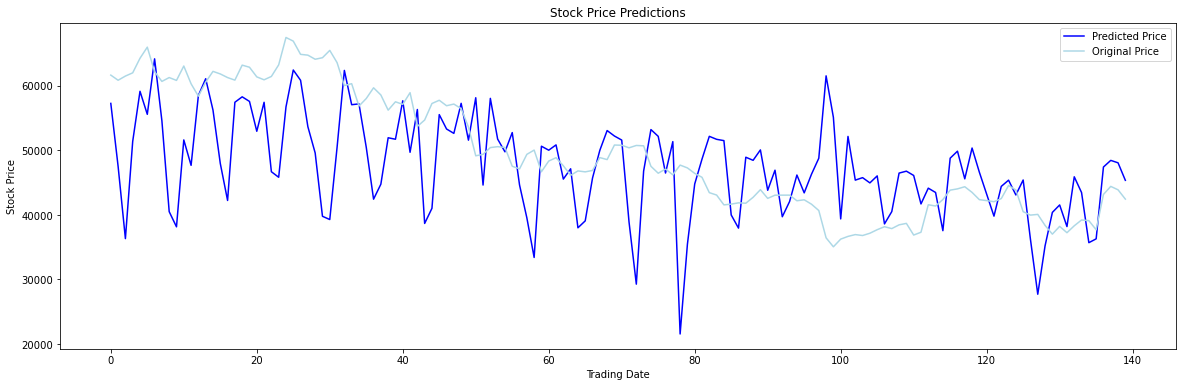

In [22]:
plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
plt.plot(y_test, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Prediction

In [30]:
predict_feature = feature_transform[-5:].mean()
predict_feature = pd.DataFrame(predict_feature)
predict_feature = predict_feature.T
predict_feature

Compound   Volume  FundingRate  Bitcoin_SVI  Cryptocurrency_SVI  \
0  0.525319  0.47366     0.135385     0.137817            0.249198   

   No. of Active Addresses  No. of Unique Addresses  Transactions  \
0                 0.548707                 0.539364      0.502639   

   Compound_lag_1  Volume_lag_1  ...  No. of Unique Addresses_lag_4  \
0        0.525319       0.47366  ...                       0.539364   

   Transactions_lag_4  Compound_lag_5  Volume_lag_5  FundingRate_lag_5  \
0            0.502639        0.525319       0.47366           0.135385   

   Bitcoin_SVI_lag_5  Cryptocurrency_SVI_lag_5  No. of Active Addresses_lag_5  \
0           0.137817                  0.249198                       0.548707   

   No. of Unique Addresses_lag_5  Transactions_lag_5  
0                       0.539364            0.502639  

[1 rows x 48 columns]

In [31]:
# Process the data for LSTM
testX =np.array(predict_feature)
predict_feature = testX.reshape(predict_feature.shape[0], 1, predict_feature.shape[1])

In [32]:
predicted_price = lstm.predict(predict_feature)

In [33]:
predicted_price[0][0]

45153.22

Reality: Bitcoin currency had a close price of USD 39,137.61 on 4 Mar 2022.

Prediced: Our model predicted the currency to have a close price of USD 45153.22 on 4 Mar 2022.